# Modeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as py
import scipy.cluster.hierarchy as sc

# Data Preparation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Distance Techniques
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

# Clustering Techniques
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Classification Techniques
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

np.random.seed(42)

# Pertinent Functions

### Functions for Data Preparation

In [ ]:
# Use the Information From Code #5 to Create a List of All Predictors Unassociated with the Target Variable
def obtainListofUnassociatedPredictors(listOfColumns):
    # Open the File of Associated Predictors
    with open("/content/drive/MyDrive/Thesis/Codes/Final Datasets/associated_predictors.txt", "r") as predictorsFile:
        associatedPredictors = [x.strip() for x in predictorsFile]
    
    unassociatedPredictors = set(listOfColumns) - set(associatedPredictors)
    
    # Drop 'Cert_or_Diploma', 'AssocDeg', 'BachDeg', and 'STEMDeg' Because They Are Redundant with the Target Variable
    for column in ["Cert_or_Diploma", "AssocDeg", "BachDeg", "STEMDeg"]:
        unassociatedPredictors.add(column)
    
    return list(unassociatedPredictors)


# Drop All Unneeded Columns From the Dataframe
def dropUnnecessaryColumns(dataframe, listOfColumns):
    # Columns with Only One Value or Only Used for EDA
    ## 9 Columns
    # CODE FILE A
    #columnsToDrop = ["AmerInd", "LEPServs", "Student_FullAddress", "Cert_or_Diploma", "HS_FullAddress", "Charter", "Magnet", 
    #                 "%_Hawaiian", "%_AmericanIndian"]
    
    # Also Includes Columns That Might Be Redundant with the Information of Others
    ## 14 Columns
    # CODE FILE B
    columnsToDrop = ["AmerInd", "LEPServs", "Student_FullAddress", "Cert_or_Diploma", "AssocDeg", "BachDeg", "STEMDeg",
                     "HS_FullAddress", "Charter", "Magnet", "NumStudents", "NumTeachers", "%_Hawaiian", "%_AmericanIndian"]
    
    # Columns Determined to Be Unassociated with the Predictor during EDA
    ## 45 Columns
    # CODE FILE C
    #columnsToDrop = obtainListofUnassociatedPredictors(listOfColumns)
    
    # Remove the Columns From the Dataset
    dataframe.drop(columnsToDrop, axis=1, inplace=True)
    
    return


# Encode the Ranked String Categoricals as an Integer Array
def ordinalEncoder(dataframe, listOfColumns):
    # Use the Encoder
    for column in listOfColumns:
        dataframe[column] = O_encoder.fit_transform(dataframe[column].values.reshape(-1,1))
    
    return


# Encode the Unranked String Categoricals as Binary Columns
def oneHotEncoder(encoder, column, dataframe):
    # Use the Encoder
    transformed = encoder.fit_transform(dataframe[column].values.reshape(-1,1))
    
    # Reconstruct the DataFrame
    dataframe[encoder.categories_[0]] = transformed.toarray()
    
    return dataframe


# Separate the DataFrame Into a Matrix of Predictors and an Array of the Target Variable
def createDataMatrixandTargetArray(dataframe):
    predictorsMatrix, targetArray = dataframe.iloc[:, :-1], dataframe.iloc[:, -1]
    
    # Return a List of the Matrix and Array
    return [predictorsMatrix, targetArray]

### Functions for Assessing Results

In [ ]:
# Compute the Percentage of Dropouts Identified by the Model
def computePercentage(identified, studentGroup):
    if studentGroup == "Dropouts":
        denominator = len(modelingData[modelingData.PS_Graduated == 1])
    elif studentGroup == "Graduates":
        denominator = len(modelingData[modelingData.PS_Graduated == 0])
    else:
        print("Invalid Entry.")
        
    percentage = (identified)/(denominator)
    
    percentage = percentage * 100
    
    percentage = "{:,.2f}".format(percentage)
    
    return percentage
        
# Look at Patterns in Categorical Predictors for the Model's Predictions of Graduates/Dropouts
def assessCategoricalPredictors(dataframe, predictorsList, compareColumn):
    for column in predictorsList:
        print(dataframe.groupby(compareColumn)[column].value_counts(), "\n")
        
    return

# Read In Data

### Modeling Data

In [ ]:
modelingData = pd.read_csv("/content/drive/MyDrive/Thesis/Codes/Final Datasets/cjb_final_dataset.csv", index_col="ID")
modelingData

,Gender,Hispanic,AmerInd,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,1,0,0,0,0,1,...,Low,High,High,Low,High,Low,High,1.527317,2.651641,0
1,1,1,0,0,0,0,0,0,0,2,...,Low,High,High,High,High,Low,High,3.227670,27.026511,1
2,0,1,0,0,0,0,0,0,0,3,...,Low,High,High,High,High,Low,High,1.803466,5.922479,0
3,0,0,0,0,1,0,0,0,0,1,...,Low,High,High,Low,High,Low,High,1.287508,20.718053,0
4,1,1,0,0,0,0,0,0,0,3,...,Low,High,Low,Low,High,Low,High,4.410934,2.378576,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,1,0,0,0,0,0,0,0,1,...,Low,High,Low,Low,Low,Low,High,19.355286,20.589324,0
120,1,0,0,0,0,1,0,0,0,1,...,Low,High,Low,Low,High,Low,High,22.010710,161.404493,0
121,0,1,0,0,0,0,0,0,0,1,...,Low,High,Low,Low,Low,Low,High,2.954628,18.060702,1


### Model Deployment

In [ ]:
modelDeploymentData = pd.read_csv("/content/drive/MyDrive/Thesis/Codes/Final Datasets/model_deployment_dataset.csv", index_col="ID")
modelDeploymentData

,Gender,Hispanic,AmerInd,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,1,0,0,0,0,1,...,High,High,High,Low,Low,Low,High,1.623791,4.237257,1
1,0,1,0,0,0,0,0,0,0,1,...,Low,High,High,Low,High,Low,High,20.716670,6.872459,0
2,0,0,0,1,0,0,0,0,0,1,...,Low,High,Low,Low,Low,Low,Low,4.704604,21.525485,1
3,0,0,0,1,0,0,0,0,0,1,...,Low,High,Low,Low,Low,Low,High,3.428077,17.439528,1
4,0,0,0,1,0,0,0,0,0,1,...,Low,High,Low,Low,High,Low,High,0.097676,1.376207,0
5,1,1,0,0,0,0,0,0,0,1,...,Low,High,High,High,High,Low,High,0.322020,12.419241,0
6,0,1,0,0,0,0,0,0,0,1,...,Low,Low,Low,Low,Low,Low,Low,4.901315,14.473225,1
7,1,1,0,0,0,0,0,0,0,1,...,Low,High,High,High,High,Low,High,23.025727,1.763638,1
8,0,1,0,0,0,0,0,0,0,1,...,Low,High,High,Low,High,Low,High,23.242655,2.558783,0


# Data Preparation

### Reformat the `PS_Graduated` Column

In [ ]:
print(modelingData.PS_Graduated.value_counts())
print()
print(modelDeploymentData.PS_Graduated.value_counts())

1    69
0    55
Name: PS_Graduated, dtype: int64

0    13
1     9
Name: PS_Graduated, dtype: int64


In [ ]:
# 1 Should Denote the Student Dropped Out
# 0 Should Denote the Student Graduated
modelingData["PS_Graduated"] = modelingData.PS_Graduated.transform(lambda x: 0 if x == 1 else 1)
modelDeploymentData["PS_Graduated"] = modelDeploymentData.PS_Graduated.transform(lambda x: 0 if x == 1 else 1)

# Verify the Columns Were Properly Modified
print(modelingData.PS_Graduated.value_counts())
print()
print(modelDeploymentData.PS_Graduated.value_counts())

0    69
1    55
Name: PS_Graduated, dtype: int64

1    13
0     9
Name: PS_Graduated, dtype: int64


### Remove Unnecessary Columns From the Datasets

In [ ]:
allColumns = modelingData.columns.values

# Modeling
dropUnnecessaryColumns(modelingData, allColumns)

# Model Deployment
dropUnnecessaryColumns(modelDeploymentData, allColumns)

In [ ]:
modelingData

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,1,11,...,Low,High,High,Low,High,Low,High,1.527317,2.651641,1
1,1,1,0,0,0,0,0,0,2,11,...,Low,High,High,High,High,Low,High,3.227670,27.026511,0
2,0,1,0,0,0,0,0,0,3,1,...,Low,High,High,High,High,Low,High,1.803466,5.922479,1
3,0,0,0,1,0,0,0,0,1,13,...,Low,High,High,Low,High,Low,High,1.287508,20.718053,1
4,1,1,0,0,0,0,0,0,3,11,...,Low,High,Low,Low,High,Low,High,4.410934,2.378576,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,1,0,0,0,0,0,0,1,13,...,Low,High,Low,Low,Low,Low,High,19.355286,20.589324,1
120,1,0,0,0,1,0,0,0,1,13,...,Low,High,Low,Low,High,Low,High,22.010710,161.404493,1
121,0,1,0,0,0,0,0,0,1,11,...,Low,High,Low,Low,Low,Low,High,2.954628,18.060702,0


In [ ]:
modelDeploymentData

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,1,0,0,0,0,1,11,...,High,High,High,Low,Low,Low,High,1.623791,4.237257,0
1,0,1,0,0,0,0,0,0,1,11,...,Low,High,High,Low,High,Low,High,20.716670,6.872459,1
2,0,0,1,0,0,0,0,0,1,13,...,Low,High,Low,Low,Low,Low,Low,4.704604,21.525485,0
3,0,0,1,0,0,0,0,0,1,1,...,Low,High,Low,Low,Low,Low,High,3.428077,17.439528,0
4,0,0,1,0,0,0,0,0,1,11,...,Low,High,Low,Low,High,Low,High,0.097676,1.376207,1
5,1,1,0,0,0,0,0,0,1,7,...,Low,High,High,High,High,Low,High,0.322020,12.419241,1
6,0,1,0,0,0,0,0,0,1,13,...,Low,Low,Low,Low,Low,Low,Low,4.901315,14.473225,0
7,1,1,0,0,0,0,0,0,1,13,...,Low,High,High,High,High,Low,High,23.025727,1.763638,0
8,0,1,0,0,0,0,0,0,1,11,...,Low,High,High,Low,High,Low,High,23.242655,2.558783,1


### Convert Variables to Their Expected Datatypes

#### Ordinal Variables

In [ ]:
# Initialize the Ordinal Encoder
O_encoder = OrdinalEncoder()

In [ ]:
# List of All Categorical Crime Variables for a High School's Area
hs_crime_categoricals = ["HS_TotalCrimesCateg", "HS_PersonalCrimesCateg", "HS_MurdersCateg", "HS_RapesCateg", 
                         "HS_RobberiesCateg", "HS_AssaultsCateg", "HS_PropertyCrimesCateg", "HS_BurglariesCateg",
                         "HS_LarceniesCateg", "HS_VehicleTheftsCateg"]

# List of All Categorical Crime Variables for a Student's Area
student_crime_categoricals = ["Student_TotalCrimesCateg", "Student_PersonalCrimesCateg", "Student_MurdersCateg", 
                              "Student_RapesCateg", "Student_RobberiesCateg", "Student_AssaultsCateg", 
                              "Student_PropertyCrimesCateg", "Student_BurglariesCateg", "Student_LarceniesCateg",
                              "Student_VehicleTheftsCateg"]

##### High School's Area

In [ ]:
modelingData.HS_TotalCrimesCateg.value_counts()

Low     97
High    27
Name: HS_TotalCrimesCateg, dtype: int64

In [ ]:
# Modeling
ordinalEncoder(modelingData, hs_crime_categoricals)

# Model Deployment
ordinalEncoder(modelDeploymentData, hs_crime_categoricals)

In [ ]:
modelingData.HS_TotalCrimesCateg.value_counts()

##  Low: 1.0
## High: 0.0

1.0    97
0.0    27
Name: HS_TotalCrimesCateg, dtype: int64

##### Student's Area

In [ ]:
# Modeling
ordinalEncoder(modelingData, student_crime_categoricals)

# Model Deployment
ordinalEncoder(modelDeploymentData, student_crime_categoricals)

In [ ]:
modelingData

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.527317,2.651641,1
1,1,1,0,0,0,0,0,0,2,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.227670,27.026511,0
2,0,1,0,0,0,0,0,0,3,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.803466,5.922479,1
3,0,0,0,1,0,0,0,0,1,13,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.287508,20.718053,1
4,1,1,0,0,0,0,0,0,3,11,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,4.410934,2.378576,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,1,0,0,0,0,0,0,1,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,19.355286,20.589324,1
120,1,0,0,0,1,0,0,0,1,13,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,22.010710,161.404493,1
121,0,1,0,0,0,0,0,0,1,11,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.954628,18.060702,0


In [ ]:
modelDeploymentData

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,1,0,0,0,0,1,11,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.623791,4.237257,0
1,0,1,0,0,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,20.716670,6.872459,1
2,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,4.704604,21.525485,0
3,0,0,1,0,0,0,0,0,1,1,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3.428077,17.439528,0
4,0,0,1,0,0,0,0,0,1,11,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.097676,1.376207,1
5,1,1,0,0,0,0,0,0,1,7,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322020,12.419241,1
6,0,1,0,0,0,0,0,0,1,13,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,4.901315,14.473225,0
7,1,1,0,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23.025727,1.763638,0
8,0,1,0,0,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,23.242655,2.558783,1


#### Nominal Variables

##### High School's Name

In [ ]:
columnOrderAfterEncoding_HSName = ["Gender", "Hispanic", "Asian", "Black", "White", "Hawaiian", "Multinational", 
                                   "LimitedEnglish", "Eligibility", "AcademNeed", "Grade_EnteredUB", "Participation", "GPA", 
                                   "HSGrad_Age", "AcademAch_ELA", "AcademAch_Math", "Employed", "CulturalAct", "CommServ", 
                                   "Student_ZIP", "Absences", "SAT_Reading", "SAT_Math", "SAT_Writing", "AP", "Honors", 
                                   "HS_SchoolName", "Barringer High School", "East Side High School", "Eastside High School", 
                                   "John F. Kennedy High School", "Malcolm X Shabazz High School", 
                                   "Passaic County Technical Institute", "Rosa L. Parks School of Fine and Performing Arts", 
                                   "School of Earth and Space Science", "School of Government and Public Administration", 
                                   "West Side High School", "HS_ZIP", "Title1_School", "Title1_SchoolWide",
                                   "StudentTeacherRatio", "NumFreeLunch", "NumReducedLunch", "%_Female", "%_Male", 
                                   "%_EconomDisadv", "%_w/Disabilities", "%_ELL", "%_Homeless", "%_FosterCare", "%_White", 
                                   "%_Hispanic", "%_Black", "%_Asian", "PS_SchoolName", "HS_CrimesIndex_2020", 
                                   "HS_PersonalCrimesIndex_2020", "HS_MurdersIndex_2020", "HS_RapesIndex_2020", 
                                   "HS_RobberiesIndex_2020", "HS_AssaultsIndex_2020", "HS_PropertyCrimesIndex_2020", 
                                   "HS_BurglariesIndex_2020", "HS_LarceniesIndex_2020", "HS_VehicleTheftsIndex_2020", 
                                   "HS_AreaPopulation_2020", "HS_Area", "HS_TotalCrimesCateg", "HS_PersonalCrimesCateg", 
                                   "HS_MurdersCateg", "HS_RapesCateg", "HS_RobberiesCateg", "HS_AssaultsCateg", 
                                   "HS_PropertyCrimesCateg", "HS_BurglariesCateg", "HS_LarceniesCateg", "HS_VehicleTheftsCateg",
                                   "Student_CrimesIndex_2020", "Student_PersonalCrimesIndex_2020", "Student_MurdersIndex_2020", 
                                   "Student_RapesIndex_2020", "Student_RobberiesIndex_2020", "Student_AssaultsIndex_2020", 
                                   "Student_PropertyCrimesIndex_2020", "Student_BurglariesIndex_2020",
                                   "Student_LarceniesIndex_2020", "Student_VehicleTheftsIndex_2020", 
                                   "Student_AreaPopulation_2020", "Student_Area", "Student_TotalCrimesCateg",
                                   "Student_PersonalCrimesCateg", "Student_MurdersCateg", "Student_RapesCateg", 
                                   "Student_RobberiesCateg", "Student_AssaultsCateg", "Student_PropertyCrimesCateg", 
                                   "Student_BurglariesCateg", "Student_LarceniesCateg", "Student_VehicleTheftsCateg",
                                   "Distance_to_HS", "Distance_to_PS", "PS_Graduated"]

In [ ]:
# Initialize the One Hot Encoder
HSName_OH_encoder = OneHotEncoder()


# Modeling
modelingData = oneHotEncoder(HSName_OH_encoder, "HS_SchoolName", modelingData)

# Reorder the DataFrame's Columns
modelingData = modelingData.reindex(columns=columnOrderAfterEncoding_HSName)
print("New Dimensions of the Modeling Dataset: ", modelingData.shape)



# Model Deployment
modelDeploymentData = oneHotEncoder(HSName_OH_encoder, "HS_SchoolName", modelDeploymentData)

# No Students From Passaic County Technical Institute or School of Government and Public Administration in This Dataset
modelDeploymentData["Passaic County Technical Institute"] = 0.0
modelDeploymentData["School of Government and Public Administration"] = 0.0

# Reorder the DataFrame's Columns
modelDeploymentData = modelDeploymentData.reindex(columns=columnOrderAfterEncoding_HSName)
print("New Dimensions of the Model Deployment Dataset: ", modelDeploymentData.shape)

New Dimensions of the Modeling Dataset:  (124, 102)
New Dimensions of the Model Deployment Dataset:  (22, 102)


##### College's Name

In [ ]:
columnOrderAfterEncoding_PSName = ["Gender", "Hispanic", "Asian", "Black", "White", "Hawaiian", "Multinational", 
                                   "LimitedEnglish", "Eligibility", "AcademNeed", "Grade_EnteredUB", "Participation", "GPA", 
                                   "HSGrad_Age", "AcademAch_ELA", "AcademAch_Math", "Employed", "CulturalAct", "CommServ", 
                                   "Student_ZIP", "Absences", "SAT_Reading", "SAT_Math", "SAT_Writing", "AP", "Honors", 
                                   "HS_SchoolName", "Barringer High School", "East Side High School", "Eastside High School", 
                                   "John F. Kennedy High School", "Malcolm X Shabazz High School", 
                                   "Passaic County Technical Institute", "Rosa L. Parks School of Fine and Performing Arts", 
                                   "School of Earth and Space Science", "School of Government and Public Administration", 
                                   "West Side High School", "HS_ZIP", "Title1_School", "Title1_SchoolWide",
                                   "StudentTeacherRatio", "NumFreeLunch", "NumReducedLunch", "%_Female", "%_Male", 
                                   "%_EconomDisadv", "%_w/Disabilities", "%_ELL", "%_Homeless", "%_FosterCare", "%_White", 
                                   "%_Hispanic", "%_Black", "%_Asian", "PS_SchoolName", "ALTIERUS CAREER EDUCATION", 
                                   "BERKELEY COLLEGE", "BLOOMFIELD COLLEGE", "CENTRAL CONNECTICUT STATE UNIV", 
                                   "COLLEGE OF NEW JERSEY (THE)", "COMMUNITY COLLEGE OF RI - WARWICK", "DAYTONA STATE COLLEGE", 
                                   "DEVRY UNIVERSITY", "DREW UNIVERSITY", "ENTERPRISE STATE COMMUNITY COLLEGE", 
                                   "ESSEX COUNTY COLLEGE", "FAIRLEIGH DICKINSON UNIV-TEANECK", "FORTIS INSTITUTE", 
                                   "FRANCIS MARION UNIVERSITY", "KEAN UNIVERSITY", "LINCOLN UNIVERSITY", 
                                   "MARYMOUNT MANHATTAN COLLEGE", "MIDDLESEX COUNTY COLLEGE", "MONTCLAIR STATE UNIVERSITY", 
                                   "NEW JERSEY INST OF TECHNOLOGY", "NORTH CAROLINA CENTRAL UNIVERSITY", "OAKWOOD UNIVERSITY", 
                                   "PASSAIC COUNTY COMMUNITY COLLEGE", "RAMAPO COLLEGE OF NEW JERSEY", "RIDER UNIVERSITY", 
                                   "ROWAN UNIVERSITY", "RUTGERS, THE STATE UNIVERSITY OF NJ", "SETON HALL UNIVERSITY",
                                   "STANFORD UNIVERSITY", "STEVENS INSTITUTE OF TECHNOLOGY", "STOCKTON UNIVERSITY",
                                   "SYRACUSE UNIVERSITY", "TEMPLE UNIVERSITY", "UNION COUNTY COLLEGE",
                                   "UNIVERSITY OF NEW HAVEN", "UNIVERSITY OF WISCONSIN-MADISON",
                                   "VAUGHN COLLEGE OF AERONAUTICS AND TECHNO", "VIRGINIA STATE UNIVERSITY", 
                                   "WILLIAM PATERSON UNIVERSITY", "HS_CrimesIndex_2020", "HS_PersonalCrimesIndex_2020", 
                                   "HS_MurdersIndex_2020", "HS_RapesIndex_2020", "HS_RobberiesIndex_2020", 
                                   "HS_AssaultsIndex_2020", "HS_PropertyCrimesIndex_2020", "HS_BurglariesIndex_2020", 
                                   "HS_LarceniesIndex_2020", "HS_VehicleTheftsIndex_2020", "HS_AreaPopulation_2020", "HS_Area", 
                                   "HS_TotalCrimesCateg", "HS_PersonalCrimesCateg", "HS_MurdersCateg", "HS_RapesCateg", 
                                   "HS_RobberiesCateg", "HS_AssaultsCateg", "HS_PropertyCrimesCateg", "HS_BurglariesCateg", 
                                   "HS_LarceniesCateg", "HS_VehicleTheftsCateg", "Student_CrimesIndex_2020", 
                                   "Student_PersonalCrimesIndex_2020", "Student_MurdersIndex_2020", "Student_RapesIndex_2020", 
                                   "Student_RobberiesIndex_2020", "Student_AssaultsIndex_2020", 
                                   "Student_PropertyCrimesIndex_2020", "Student_BurglariesIndex_2020", 
                                   "Student_LarceniesIndex_2020", "Student_VehicleTheftsIndex_2020", 
                                   "Student_AreaPopulation_2020", "Student_Area", "Student_TotalCrimesCateg",
                                   "Student_PersonalCrimesCateg", "Student_MurdersCateg", "Student_RapesCateg", 
                                   "Student_RobberiesCateg", "Student_AssaultsCateg", "Student_PropertyCrimesCateg", 
                                   "Student_BurglariesCateg", "Student_LarceniesCateg", "Student_VehicleTheftsCateg",
                                   "Distance_to_HS", "Distance_to_PS", "PS_Graduated"]

In [ ]:
# Initialize the One Hot Encoder
PSName_OH_encoder = OneHotEncoder()


# Modeling
modelingData = oneHotEncoder(PSName_OH_encoder, "PS_SchoolName", modelingData)

# No Students From Francis Marion University or Stevens Institute of Technology in This Dataset
modelingData["FRANCIS MARION UNIVERSITY"] = 0.0
modelingData["STEVENS INSTITUTE OF TECHNOLOGY"] = 0.0

# Reorder the DataFrame's Columns
modelingData = modelingData.reindex(columns=columnOrderAfterEncoding_PSName)
print("New Dimensions of the Modeling Dataset: ", modelingData.shape)



# Model Deployment
modelDeploymentData = oneHotEncoder(PSName_OH_encoder, "PS_SchoolName", modelDeploymentData)

# No Students From Altierus Career Education, Berkeley College, Bloomfield College, Central Connecticut State University,
#     The College of New Jersey, Community College of RI - Warwick, Daytona State College, Devry University, Drew University,
#     Enterprise State Community College, Fairleigh Dickinson Univ-Teaneck, Fortis Institute, Lincoln University, 
#     Marymount Manhattan College, Middlesex County College, North Carolina Central University, Oakwood University, 
#     Rider University, Rowan University, Seton Hall University, Stanford University, Stockton University, Syracuse University,
#     Temple University, University of Wisconsin-Madison, Vaughn College of Aeronautics and Technology, or 
#     Virginia State University in This Dataset
missing_colleges = ["ALTIERUS CAREER EDUCATION", "BERKELEY COLLEGE", "BLOOMFIELD COLLEGE", "CENTRAL CONNECTICUT STATE UNIV",
                    "COLLEGE OF NEW JERSEY (THE)", "COMMUNITY COLLEGE OF RI - WARWICK", "DAYTONA STATE COLLEGE", 
                    "DEVRY UNIVERSITY", "DREW UNIVERSITY", "ENTERPRISE STATE COMMUNITY COLLEGE", 
                    "FAIRLEIGH DICKINSON UNIV-TEANECK", "FORTIS INSTITUTE", "LINCOLN UNIVERSITY", "MARYMOUNT MANHATTAN COLLEGE",
                    "MIDDLESEX COUNTY COLLEGE", "NORTH CAROLINA CENTRAL UNIVERSITY", "OAKWOOD UNIVERSITY", "RIDER UNIVERSITY", 
                    "ROWAN UNIVERSITY", "SETON HALL UNIVERSITY", "STANFORD UNIVERSITY", "STOCKTON UNIVERSITY", 
                    "SYRACUSE UNIVERSITY", "TEMPLE UNIVERSITY", "UNIVERSITY OF WISCONSIN-MADISON", 
                    "VAUGHN COLLEGE OF AERONAUTICS AND TECHNO", "VIRGINIA STATE UNIVERSITY"]

for college in missing_colleges:
    modelDeploymentData[college] = 0.0

# Reorder the DataFrame's Columns
modelDeploymentData = modelDeploymentData.reindex(columns=columnOrderAfterEncoding_PSName)
print("New Dimensions of the Model Deployment Dataset: ", modelDeploymentData.shape)

New Dimensions of the Modeling Dataset:  (124, 141)
New Dimensions of the Model Deployment Dataset:  (22, 141)


##### High School's ZipCode

In [ ]:
columnOrderAfterEncoding_HSZIP = ["Gender", "Hispanic", "Asian", "Black", "White", "Hawaiian", "Multinational", 
                                  "LimitedEnglish", "Eligibility", "AcademNeed", "Grade_EnteredUB", "Participation", "GPA", 
                                  "HSGrad_Age", "AcademAch_ELA", "AcademAch_Math", "Employed", "CulturalAct", "CommServ", 
                                  "Student_ZIP", "Absences", "SAT_Reading", "SAT_Math", "SAT_Writing", "AP", "Honors", 
                                  "HS_SchoolName", "Barringer High School", "East Side High School", "Eastside High School", 
                                  "John F. Kennedy High School", "Malcolm X Shabazz High School", 
                                  "Passaic County Technical Institute", "Rosa L. Parks School of Fine and Performing Arts", 
                                  "School of Earth and Space Science", "School of Government and Public Administration", 
                                  "West Side High School", "HS_ZIP", "HS_07103", "HS_07104", "HS_07105", "HS_07108", "HS_07470",
                                  "HS_07501", "HS_07502", "HS_07505", "HS_07514", "Title1_School", "Title1_SchoolWide",
                                  "StudentTeacherRatio", "NumFreeLunch", "NumReducedLunch", "%_Female", "%_Male", 
                                  "%_EconomDisadv", "%_w/Disabilities", "%_ELL", "%_Homeless", "%_FosterCare", "%_White",
                                  "%_Hispanic", "%_Black", "%_Asian", "PS_SchoolName", "ALTIERUS CAREER EDUCATION", 
                                  "BERKELEY COLLEGE", "BLOOMFIELD COLLEGE", "CENTRAL CONNECTICUT STATE UNIV", 
                                  "COLLEGE OF NEW JERSEY (THE)", "COMMUNITY COLLEGE OF RI - WARWICK", "DAYTONA STATE COLLEGE",
                                  "DEVRY UNIVERSITY", "DREW UNIVERSITY", "ENTERPRISE STATE COMMUNITY COLLEGE", 
                                  "ESSEX COUNTY COLLEGE", "FAIRLEIGH DICKINSON UNIV-TEANECK", "FORTIS INSTITUTE", 
                                  "FRANCIS MARION UNIVERSITY", "KEAN UNIVERSITY", "LINCOLN UNIVERSITY", 
                                  "MARYMOUNT MANHATTAN COLLEGE", "MIDDLESEX COUNTY COLLEGE", "MONTCLAIR STATE UNIVERSITY", 
                                  "NEW JERSEY INST OF TECHNOLOGY", "NORTH CAROLINA CENTRAL UNIVERSITY", "OAKWOOD UNIVERSITY",
                                  "PASSAIC COUNTY COMMUNITY COLLEGE", "RAMAPO COLLEGE OF NEW JERSEY", "RIDER UNIVERSITY", 
                                  "ROWAN UNIVERSITY", "RUTGERS, THE STATE UNIVERSITY OF NJ", "SETON HALL UNIVERSITY",
                                  "STANFORD UNIVERSITY", "STEVENS INSTITUTE OF TECHNOLOGY", "STOCKTON UNIVERSITY",
                                  "SYRACUSE UNIVERSITY", "TEMPLE UNIVERSITY", "UNION COUNTY COLLEGE",
                                  "UNIVERSITY OF NEW HAVEN", "UNIVERSITY OF WISCONSIN-MADISON",
                                  "VAUGHN COLLEGE OF AERONAUTICS AND TECHNO", "VIRGINIA STATE UNIVERSITY", 
                                  "WILLIAM PATERSON UNIVERSITY", "HS_CrimesIndex_2020", "HS_PersonalCrimesIndex_2020",
                                  "HS_MurdersIndex_2020", "HS_RapesIndex_2020", "HS_RobberiesIndex_2020", 
                                  "HS_AssaultsIndex_2020", "HS_PropertyCrimesIndex_2020", "HS_BurglariesIndex_2020", 
                                  "HS_LarceniesIndex_2020", "HS_VehicleTheftsIndex_2020", "HS_AreaPopulation_2020", "HS_Area",
                                  "HS_TotalCrimesCateg", "HS_PersonalCrimesCateg", "HS_MurdersCateg", "HS_RapesCateg", 
                                  "HS_RobberiesCateg", "HS_AssaultsCateg", "HS_PropertyCrimesCateg", "HS_BurglariesCateg",
                                  "HS_LarceniesCateg", "HS_VehicleTheftsCateg", "Student_CrimesIndex_2020", 
                                  "Student_PersonalCrimesIndex_2020", "Student_MurdersIndex_2020", "Student_RapesIndex_2020", 
                                  "Student_RobberiesIndex_2020", "Student_AssaultsIndex_2020",
                                  "Student_PropertyCrimesIndex_2020", "Student_BurglariesIndex_2020", 
                                  "Student_LarceniesIndex_2020", "Student_VehicleTheftsIndex_2020", 
                                  "Student_AreaPopulation_2020", "Student_Area", "Student_TotalCrimesCateg",
                                  "Student_PersonalCrimesCateg", "Student_MurdersCateg", "Student_RapesCateg", 
                                  "Student_RobberiesCateg", "Student_AssaultsCateg", "Student_PropertyCrimesCateg", 
                                  "Student_BurglariesCateg", "Student_LarceniesCateg", "Student_VehicleTheftsCateg",
                                  "Distance_to_HS", "Distance_to_PS", "PS_Graduated"]

In [ ]:
# Initialize the One Hot Encoder
HSZIP_OH_encoder = OneHotEncoder()


# Modeling
modelingData = oneHotEncoder(HSZIP_OH_encoder, "HS_ZIP", modelingData)

# Rename the New Columns to Differentiate Them From the Student ZipCodes
HSZIPcolumns = {"#07103": "HS_07103", "#07104": "HS_07104", "#07105": "HS_07105", "#07108": "HS_07108", "#07470": "HS_07470", 
                     "#07501": "HS_07501", "#07502": "HS_07502", "#07505": "HS_07505", "#07514": "HS_07514"}
modelingData.rename(columns=HSZIPcolumns, inplace=True)
    
# Reorder the DataFrame's Columns
modelingData = modelingData.reindex(columns=columnOrderAfterEncoding_HSZIP)
print("New Dimensions of the Modeling Dataset: ", modelingData.shape)



# Model Deployment
modelDeploymentData = oneHotEncoder(HSZIP_OH_encoder, "HS_ZIP", modelDeploymentData)

# No High Schools From ZipCode 07470 in This Dataset
modelDeploymentData["#07470"] = 0.0

# Rename the New Columns to Differentiate Them From the Student ZipCodes
modelDeploymentData.rename(columns=HSZIPcolumns, inplace=True)

# Reorder the DataFrame's Columns
modelDeploymentData = modelDeploymentData.reindex(columns=columnOrderAfterEncoding_HSZIP)
print("New Dimensions of the Model Deployment Dataset: ", modelDeploymentData.shape)

New Dimensions of the Modeling Dataset:  (124, 150)
New Dimensions of the Model Deployment Dataset:  (22, 150)


##### Student's ZipCode

In [ ]:
columnOrderAfterEncoding_StudentZIP = ["Gender", "Hispanic", "Asian", "Black", "White", "Hawaiian", "Multinational", 
                                       "LimitedEnglish", "Eligibility", "AcademNeed", "Grade_EnteredUB", "Participation", "GPA",
                                       "HSGrad_Age", "AcademAch_ELA", "AcademAch_Math", "Employed", "CulturalAct", "CommServ", 
                                       "Student_ZIP", "Std_07011", "Std_07026", "Std_07103", "Std_07104", "Std_07105", 
                                       "Std_07106", "Std_07107", "Std_07108", "Std_07112", "Std_07114", "Std_07501", 
                                       "Std_07502", "Std_07503", "Std_07504", "Std_07505", "Std_07506", "Std_07513", 
                                       "Std_07514", "Std_07522", "Std_07524", "Absences", "SAT_Reading", "SAT_Math", 
                                       "SAT_Writing", "AP", "Honors", "HS_SchoolName", "Barringer High School", 
                                       "East Side High School", "Eastside High School", "John F. Kennedy High School", 
                                       "Malcolm X Shabazz High School", "Passaic County Technical Institute", 
                                       "Rosa L. Parks School of Fine and Performing Arts", "School of Earth and Space Science", 
                                       "School of Government and Public Administration", "West Side High School", "HS_ZIP", 
                                       "HS_07103", "HS_07104", "HS_07105", "HS_07108", "HS_07470", "HS_07501", "HS_07502", 
                                       "HS_07505", "HS_07514", "Title1_School", "Title1_SchoolWide", "StudentTeacherRatio", 
                                       "NumFreeLunch", "NumReducedLunch", "%_Female", "%_Male", "%_EconomDisadv", 
                                       "%_w/Disabilities", "%_ELL", "%_Homeless", "%_FosterCare", "%_White", "%_Hispanic", 
                                       "%_Black", "%_Asian", "PS_SchoolName", "ALTIERUS CAREER EDUCATION", "BERKELEY COLLEGE", 
                                       "BLOOMFIELD COLLEGE", "CENTRAL CONNECTICUT STATE UNIV", "COLLEGE OF NEW JERSEY (THE)", 
                                       "COMMUNITY COLLEGE OF RI - WARWICK", "DAYTONA STATE COLLEGE", "DEVRY UNIVERSITY", 
                                       "DREW UNIVERSITY", "ENTERPRISE STATE COMMUNITY COLLEGE", "ESSEX COUNTY COLLEGE", 
                                       "FAIRLEIGH DICKINSON UNIV-TEANECK", "FORTIS INSTITUTE", "FRANCIS MARION UNIVERSITY", 
                                       "KEAN UNIVERSITY", "LINCOLN UNIVERSITY",  "MARYMOUNT MANHATTAN COLLEGE", 
                                       "MIDDLESEX COUNTY COLLEGE", "MONTCLAIR STATE UNIVERSITY", 
                                       "NEW JERSEY INST OF TECHNOLOGY", "NORTH CAROLINA CENTRAL UNIVERSITY", 
                                       "OAKWOOD UNIVERSITY", "PASSAIC COUNTY COMMUNITY COLLEGE", "RAMAPO COLLEGE OF NEW JERSEY",
                                       "RIDER UNIVERSITY", "ROWAN UNIVERSITY", "RUTGERS, THE STATE UNIVERSITY OF NJ", 
                                       "SETON HALL UNIVERSITY", "STANFORD UNIVERSITY", "STEVENS INSTITUTE OF TECHNOLOGY", 
                                       "STOCKTON UNIVERSITY", "SYRACUSE UNIVERSITY", "TEMPLE UNIVERSITY", 
                                       "UNION COUNTY COLLEGE", "UNIVERSITY OF NEW HAVEN", "UNIVERSITY OF WISCONSIN-MADISON",
                                       "VAUGHN COLLEGE OF AERONAUTICS AND TECHNO", "VIRGINIA STATE UNIVERSITY", 
                                       "WILLIAM PATERSON UNIVERSITY", "HS_CrimesIndex_2020", "HS_PersonalCrimesIndex_2020",
                                       "HS_MurdersIndex_2020", "HS_RapesIndex_2020", "HS_RobberiesIndex_2020", 
                                       "HS_AssaultsIndex_2020", "HS_PropertyCrimesIndex_2020", "HS_BurglariesIndex_2020", 
                                       "HS_LarceniesIndex_2020", "HS_VehicleTheftsIndex_2020", "HS_AreaPopulation_2020",
                                       "HS_Area", "HS_TotalCrimesCateg", "HS_PersonalCrimesCateg", "HS_MurdersCateg", 
                                       "HS_RapesCateg", "HS_RobberiesCateg", "HS_AssaultsCateg", "HS_PropertyCrimesCateg", 
                                       "HS_BurglariesCateg", "HS_LarceniesCateg", "HS_VehicleTheftsCateg", 
                                       "Student_CrimesIndex_2020", "Student_PersonalCrimesIndex_2020", 
                                       "Student_MurdersIndex_2020", "Student_RapesIndex_2020", "Student_RobberiesIndex_2020", 
                                       "Student_AssaultsIndex_2020", "Student_PropertyCrimesIndex_2020", 
                                       "Student_BurglariesIndex_2020", "Student_LarceniesIndex_2020", 
                                       "Student_VehicleTheftsIndex_2020", "Student_AreaPopulation_2020", "Student_Area", 
                                       "Student_TotalCrimesCateg", "Student_PersonalCrimesCateg", "Student_MurdersCateg", 
                                       "Student_RapesCateg", "Student_RobberiesCateg", "Student_AssaultsCateg", 
                                       "Student_PropertyCrimesCateg", "Student_BurglariesCateg", "Student_LarceniesCateg", 
                                       "Student_VehicleTheftsCateg", "Distance_to_HS", "Distance_to_PS", "PS_Graduated"]

In [ ]:
# Initialize the One Hot Encoder
StudentZIP_OH_encoder = OneHotEncoder()


# Modeling
modelingData = oneHotEncoder(StudentZIP_OH_encoder, "Student_ZIP", modelingData)

# No Students From ZipCodes 07011, 07106, or 07506 in This Dataset
modelingData["#07011"] = 0.0
modelingData["#07106"] = 0.0
modelingData["#07506"] = 0.0
  
# Rename the New Columns to Differentiate Them From the High School ZipCodes
StudentZIPcolumns = {"#07011": "Std_07011", "#07026": "Std_07026", "#07103": "Std_07103", "#07104": "Std_07104", 
                     "#07105": "Std_07105", "#07106": "Std_07106", "#07107": "Std_07107", "#07108": "Std_07108", 
                     "#07112": "Std_07112", "#07114": "Std_07114", "#07501": "Std_07501", "#07502": "Std_07502", 
                     "#07503": "Std_07503", "#07504": "Std_07504", "#07505": "Std_07505", "#07506": "Std_07506", 
                     "#07513": "Std_07513", "#07514": "Std_07514", "#07522": "Std_07522", "#07524": "Std_07524"}
modelingData.rename(columns=StudentZIPcolumns, inplace=True)

# Reorder the DataFrame's Columns
modelingData = modelingData.reindex(columns=columnOrderAfterEncoding_StudentZIP)
print("New Dimensions of the Modeling Dataset: ", modelingData.shape)



# Model Deployment
modelDeploymentData = oneHotEncoder(StudentZIP_OH_encoder, "Student_ZIP", modelDeploymentData)

# No High Schools From ZipCodes 07026, 07103, 07104, 07105, 07112, 07504, 07505, or 07522 in This Dataset
missing_StdZIPs = ["#07026", "#07103", "#07104", "#07105","#07112","#07504", "#07505","#07522"]
for ZipCode in missing_StdZIPs:
    modelDeploymentData[ZipCode] = 0.0

# Rename the New Columns to Differentiate Them From the High School ZipCodes
modelDeploymentData.rename(columns=StudentZIPcolumns, inplace=True)

# Reorder the DataFrame's Columns
modelDeploymentData = modelDeploymentData.reindex(columns=columnOrderAfterEncoding_StudentZIP)
print("New Dimensions of the Model Deployment Dataset: ", modelDeploymentData.shape)

New Dimensions of the Modeling Dataset:  (124, 170)
New Dimensions of the Model Deployment Dataset:  (22, 170)


# Data Partitioning

### Create Training,  Validation, and Testing Sets

In [ ]:
train, valANDtest = train_test_split(modelingData, test_size=.3, random_state=42)
print(train.shape)

(86, 170)


In [ ]:
validation, test = train_test_split(valANDtest, test_size=.3, random_state=42)
print(validation.shape)
print(test.shape)

(26, 170)
(12, 170)


### Separate the Predictors and the Target Variable

In [ ]:
# Model Deployment
separated_deployment = createDataMatrixandTargetArray(modelDeploymentData)
modelDeploymentData_X, modelDeploymentData_y = separated_deployment[0], separated_deployment[1]
print("Size of modelDeploymentData_X: ", modelDeploymentData_X.shape)
print("Size of modelDeploymentData_y: ", modelDeploymentData_y.shape, "\n")

# Modeling
## All
separated_modeling = createDataMatrixandTargetArray(modelingData)
modelingData_X, modelingData_y = separated_modeling[0], separated_modeling[1]
print("Size of modelingData_X: ", modelingData_X.shape)
print("Size of modelingData_y: ", modelingData_y.shape, "\n")

## Training
separated_training = createDataMatrixandTargetArray(train)
train_X, train_y = separated_training[0], separated_training[1]
print("Size of train_X: ", train_X.shape)
print("Size of train_y: ", train_y.shape, "\n")

## Validation
separated_validation = createDataMatrixandTargetArray(validation)
validation_X, validation_y = separated_validation[0], separated_validation[1]
print("Size of validation_X: ", validation_X.shape)
print("Size of validation_y: ", validation_y.shape, "\n")

## Testing
separated_testing = createDataMatrixandTargetArray(test)
test_X, test_y = separated_testing[0], separated_testing[1]
print("Size of test_X: ", test_X.shape)
print("Size of test_y: ", test_y.shape)

Size of modelDeploymentData_X:  (22, 169)
Size of modelDeploymentData_y:  (22,) 

Size of modelingData_X:  (124, 169)
Size of modelingData_y:  (124,) 

Size of train_X:  (86, 169)
Size of train_y:  (86,) 

Size of validation_X:  (26, 169)
Size of validation_y:  (26,) 

Size of test_X:  (12, 169)
Size of test_y:  (12,)


### Standardize the Data Matricies

In [ ]:
# Drop the Remaining String Columns (One-Hot Encoding Above)
## 4 Columns
stringColumns = ["HS_SchoolName", "PS_SchoolName", "HS_ZIP", "Student_ZIP"]

for dataframe in [modelDeploymentData_X, modelingData, modelingData_X, train_X, validation_X, test_X]:
    dataframe.drop(stringColumns, axis=1, inplace=True)

In [ ]:
# Initialize the Scaler
scaler = StandardScaler()

# Model Deployment
modelDeploymentData_X_scaled = scaler.fit_transform(modelDeploymentData_X, modelDeploymentData_y)
print("Size of modelDeploymentData_X_scaled: ", modelDeploymentData_X_scaled.shape)
print("Size of modelDeploymentData_y: ", modelDeploymentData_y.shape, "\n")

# Modeling
## All
modelingData_scaled = scaler.fit_transform(modelingData)
print("Size of modelingData_scaled: ", modelingData_scaled.shape)
modelingData_X_scaled = scaler.fit_transform(modelingData_X, modelingData_y)
print("Size of modelingData_X_scaled: ", modelingData_X_scaled.shape)
print("Size of modelingData_y: ", modelingData_y.shape, "\n")

## Training
train_X_scaled = scaler.fit_transform(train_X, train_y)
print("Size of train_X_scaled: ", train_X_scaled.shape)
print("Size of train_y: ", train_y.shape, "\n")

## Validation
validation_X_scaled = scaler.fit_transform(validation_X, validation_y)
print("Size of validation_X_scaled: ", validation_X_scaled.shape)
print("Size of validation_y: ", validation_y.shape, "\n")

## Testing
test_X_scaled = scaler.fit_transform(test_X, test_y)
print("Size of test_X_scaled: ", test_X_scaled.shape)
print("Size of test_y: ", test_y.shape)

Size of modelDeploymentData_X_scaled:  (22, 165)
Size of modelDeploymentData_y:  (22,) 

Size of modelingData_scaled:  (124, 166)
Size of modelingData_X_scaled:  (124, 165)
Size of modelingData_y:  (124,) 

Size of train_X_scaled:  (86, 165)
Size of train_y:  (86,) 

Size of validation_X_scaled:  (26, 165)
Size of validation_y:  (26,) 

Size of test_X_scaled:  (12, 165)
Size of test_y:  (12,)


In [ ]:
modelingData.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 0 to 123
Data columns (total 166 columns):
 #    Column                                            Dtype  
---   ------                                            -----  
 0    Gender                                            int64  
 1    Hispanic                                          int64  
 2    Asian                                             int64  
 3    Black                                             int64  
 4    White                                             int64  
 5    Hawaiian                                          int64  
 6    Multinational                                     int64  
 7    LimitedEnglish                                    int64  
 8    Eligibility                                       int64  
 9    AcademNeed                                        int64  
 10   Grade_EnteredUB                                   int64  
 11   Participation                                     int64 

# Distanced-Based Techniques

### kNN

<font color=red>Minimal Difference Between Scaled and Unscaled<br> $\therefore$ Use Unscaled Data</font>

In [ ]:
distanceOutliers = set()

#### Attempt #1

##### Full, Unscaled

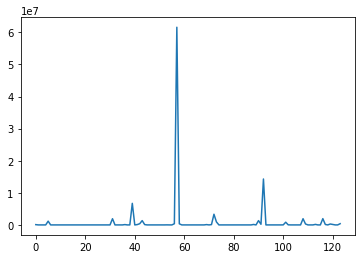

In [ ]:
# Initialize the Model
kNN_1 = NearestNeighbors(n_neighbors = 3)

# Fit the Model
kNN_1.fit(modelingData)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_1, indexes_1 = kNN_1.kneighbors(modelingData)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_1.mean(axis=1))

In [ ]:
# Choose the Cutoff
outlierIndices_1 = np.where(distances_1.mean(axis=1) > (0.1 * 10**7))
distanceOutliers.update(outlierIndices_1[0])
print("Number of Outliers: ", len(outlierIndices_1[0]))
print("Outliers: ", outlierIndices_1, "\n")

Number of Outliers:  10
Outliers:  (array([  5,  31,  39,  43,  57,  72,  90,  92, 108, 116]),) 



In [ ]:
outliers_1 = modelingData.iloc[outlierIndices_1]
outliers_1

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650735,1277.060391,0
31,1,0,0,1,0,0,0,0,1,5,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.033103,775.667925,1
39,1,0,0,1,0,0,0,0,1,2,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4.602228,781.374872,1
43,1,0,0,1,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.390346,85.289272,1
57,0,1,0,0,0,0,0,0,1,13,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.171033,7.658454,0
72,1,0,0,1,0,0,0,0,1,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.263438,18.169620,1
90,1,1,0,0,1,0,1,0,1,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.373845,17.769683,0
92,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.880210,19.629317,1
108,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.677924,2.130889,1


#### Attempt #2

##### Full, Scaled

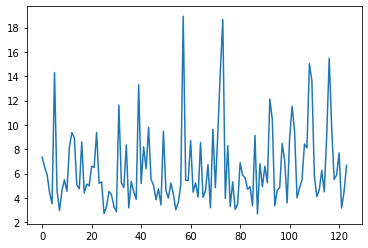

In [ ]:
# Initialize the Model
kNN_2 = NearestNeighbors(n_neighbors = 3)

# Fit the Model
kNN_2.fit(modelingData_scaled)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_2, indexes_2 = kNN_2.kneighbors(modelingData_scaled)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_2.mean(axis=1))

In [ ]:
# Choose the Cutoff
outlierIndices_2 = np.where(distances_2.mean(axis=1) > 10)
distanceOutliers.update(outlierIndices_2[0])
print("Number of Outliers: ", len(outlierIndices_2[0]))
print("Outliers: ", outlierIndices_2, "\n")

Number of Outliers:  12
Outliers:  (array([  5,  31,  39,  57,  72,  73,  92,  93, 101, 108, 109, 116]),) 



In [ ]:
outliers_2 = pd.DataFrame(modelingData_scaled).iloc[outlierIndices_2]
outliers_2

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
5,-1.120065,-0.863990,2.153222,-0.767948,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,0.964940,...,0.384900,-0.090167,-0.614636,-1.13855,-0.398596,-11.090537,-0.090167,-0.676269,2.497844,-0.892805
31,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,-1.739072,...,0.384900,-0.090167,-0.614636,0.87831,2.508808,0.090167,-0.090167,-0.512888,1.397829,1.120065
39,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,-2.753076,...,0.384900,-0.090167,1.626978,0.87831,2.508808,0.090167,-0.090167,-0.209243,1.410350,1.120065
57,-1.120065,1.157421,-0.464420,-0.767948,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,0.964940,...,0.384900,-0.090167,-0.614636,0.87831,-0.398596,0.090167,-0.090167,-0.614775,-0.287121,-0.892805
72,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,-1.063069,...,-2.598076,-0.090167,-0.614636,-1.13855,-0.398596,0.090167,-0.090167,-0.485664,-0.264060,1.120065
73,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,-1.063069,...,0.384900,11.090537,1.626978,0.87831,2.508808,0.090167,11.090537,1.352801,1.198359,1.120065
92,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,0.288937,...,0.384900,-0.090167,-0.614636,-1.13855,-0.398596,0.090167,-0.090167,-0.649148,-0.260858,1.120065
93,-1.120065,1.157421,-0.464420,-0.767948,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,0.964940,...,0.384900,-0.090167,-0.614636,-1.13855,-0.398596,0.090167,-0.090167,-0.609496,8.693524,1.120065
101,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,-2.753076,...,0.384900,-0.090167,-0.614636,-1.13855,-0.398596,0.090167,-0.090167,-0.608350,-0.291717,-0.892805
108,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,0.288937,...,0.384900,-0.090167,-0.614636,0.87831,2.508808,0.090167,-0.090167,-0.673056,-0.299248,1.120065


In [ ]:
modelingData_y.iloc[outlierIndices_2]

ID
5      0
31     1
39     1
57     0
72     1
73     1
92     1
93     1
101    0
108    1
109    1
116    0
Name: PS_Graduated, dtype: int64

#### Attempt #3

##### Just Predictors, Unscaled

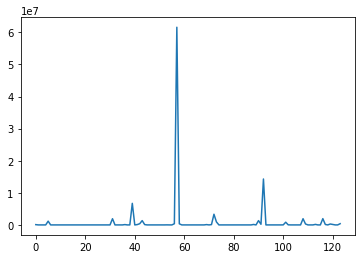

In [ ]:
# Initialize the Model
kNN_3 = NearestNeighbors(n_neighbors = 3)

# Fit the Model
kNN_3.fit(modelingData_X)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_3, indexes_3 = kNN_3.kneighbors(modelingData_X)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_3.mean(axis=1))

In [ ]:
# Choose the Cutoff
outlierIndices_3 = np.where(distances_3.mean(axis=1) > (0.1 * 10**7))
distanceOutliers.update(outlierIndices_3[0])
print("Number of Outliers: ", len(outlierIndices_3[0]))
print("Outliers: ", outlierIndices_3, "\n")

Number of Outliers:  10
Outliers:  (array([  5,  31,  39,  43,  57,  72,  90,  92, 108, 116]),) 



In [ ]:
outliers_3 = modelingData.iloc[outlierIndices_3]
outliers_3

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650735,1277.060391,0
31,1,0,0,1,0,0,0,0,1,5,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.033103,775.667925,1
39,1,0,0,1,0,0,0,0,1,2,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4.602228,781.374872,1
43,1,0,0,1,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.390346,85.289272,1
57,0,1,0,0,0,0,0,0,1,13,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.171033,7.658454,0
72,1,0,0,1,0,0,0,0,1,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.263438,18.169620,1
90,1,1,0,0,1,0,1,0,1,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.373845,17.769683,0
92,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.880210,19.629317,1
108,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.677924,2.130889,1


#### Attempt #4

##### Just Predictors, Scaled

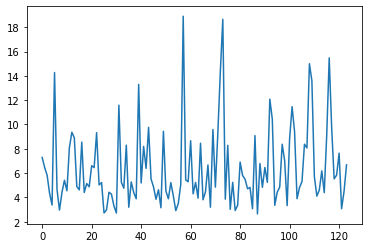

In [ ]:
# Initialize the Model
kNN_4 = NearestNeighbors(n_neighbors = 3)

# Fit the Model
kNN_4.fit(modelingData_X_scaled)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_4, indexes_4 = kNN_4.kneighbors(modelingData_X_scaled)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_4.mean(axis=1))

In [ ]:
# Choose the Cutoff
outlierIndices_4 = np.where(distances_4.mean(axis=1) > 10)
distanceOutliers.update(outlierIndices_4[0])
print("Number of Outliers: ", len(outlierIndices_4[0]))
print("Outliers: ", outlierIndices_4, "\n")

Number of Outliers:  12
Outliers:  (array([  5,  31,  39,  57,  72,  73,  92,  93, 101, 108, 109, 116]),) 



In [ ]:
outliers_4 = pd.DataFrame(modelingData_scaled).iloc[outlierIndices_4]
outliers_4

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
5,-1.120065,-0.863990,2.153222,-0.767948,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,0.964940,...,0.384900,-0.090167,-0.614636,-1.13855,-0.398596,-11.090537,-0.090167,-0.676269,2.497844,-0.892805
31,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,-1.739072,...,0.384900,-0.090167,-0.614636,0.87831,2.508808,0.090167,-0.090167,-0.512888,1.397829,1.120065
39,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,-2.753076,...,0.384900,-0.090167,1.626978,0.87831,2.508808,0.090167,-0.090167,-0.209243,1.410350,1.120065
57,-1.120065,1.157421,-0.464420,-0.767948,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,0.964940,...,0.384900,-0.090167,-0.614636,0.87831,-0.398596,0.090167,-0.090167,-0.614775,-0.287121,-0.892805
72,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,-1.063069,...,-2.598076,-0.090167,-0.614636,-1.13855,-0.398596,0.090167,-0.090167,-0.485664,-0.264060,1.120065
73,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,-1.063069,...,0.384900,11.090537,1.626978,0.87831,2.508808,0.090167,11.090537,1.352801,1.198359,1.120065
92,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,0.288937,...,0.384900,-0.090167,-0.614636,-1.13855,-0.398596,0.090167,-0.090167,-0.649148,-0.260858,1.120065
93,-1.120065,1.157421,-0.464420,-0.767948,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,0.964940,...,0.384900,-0.090167,-0.614636,-1.13855,-0.398596,0.090167,-0.090167,-0.609496,8.693524,1.120065
101,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,-2.753076,...,0.384900,-0.090167,-0.614636,-1.13855,-0.398596,0.090167,-0.090167,-0.608350,-0.291717,-0.892805
108,0.892805,-0.863990,-0.464420,1.302172,-0.425385,-0.090167,-0.412082,-0.244600,-0.503646,0.288937,...,0.384900,-0.090167,-0.614636,0.87831,2.508808,0.090167,-0.090167,-0.673056,-0.299248,1.120065


In [ ]:
modelingData_y.iloc[outlierIndices_4]

ID
5      0
31     1
39     1
57     0
72     1
73     1
92     1
93     1
101    0
108    1
109    1
116    0
Name: PS_Graduated, dtype: int64

#### Attempt #5

##### Just Predictors, Unscaled

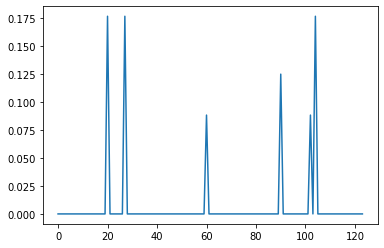

In [ ]:
classifier_1 = KNeighborsClassifier(n_neighbors = 1)
classifier_1.fit(modelingData_X, modelingData_y)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_c1, indexes_c1 = classifier_1.kneighbors(modelingData_X)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_c1.mean(axis=1))

In [ ]:
# Choose the Cutoff
outlierIndices_c1 = np.where(distances_c1.mean(axis=1) > 0.075)
distanceOutliers.update(outlierIndices_c1[0])
print("Number of Outliers: ", len(outlierIndices_c1[0]))
print("Outliers: ", outlierIndices_c1, "\n")

Number of Outliers:  6
Outliers:  (array([ 20,  27,  60,  90, 102, 104]),) 



In [ ]:
outliers_c1 = modelingData.iloc[outlierIndices_c1]
outliers_c1

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
20,0,0,1,0,0,0,0,1,2,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,3.009992,86.917957,0
27,0,0,0,0,0,0,0,0,2,11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.923336,39.873409,0
60,1,1,0,0,0,0,0,0,2,11,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.485374,294.125542,1
90,1,1,0,0,1,0,1,0,1,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.373845,17.769683,0
102,1,1,0,1,0,0,1,0,1,11,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.103962,20.485916,0
104,1,1,0,0,0,0,0,0,1,11,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.232218,5.221399,0


#### Attempt #6

##### Just Predictors, Scaled

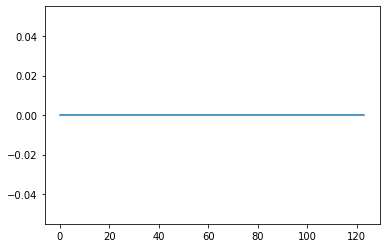

In [ ]:
classifier_2 = KNeighborsClassifier(n_neighbors = 1)
classifier_2.fit(modelingData_X_scaled, modelingData_y)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_c2, indexes_c2 = classifier_2.kneighbors(modelingData_X_scaled)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_c2.mean(axis=1))

<font color=royalblue>**So, no outliers.**</font>

#### Attempt #7

##### Just Predictors, Unscaled

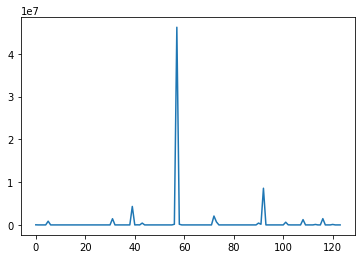

In [ ]:
classifier_3 = KNeighborsClassifier(n_neighbors = 2)
classifier_3.fit(modelingData_X, modelingData_y)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_c3, indexes_c3 = classifier_3.kneighbors(modelingData_X)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_c3.mean(axis=1))

In [ ]:
# Choose the Cutoff
outlierIndices_c3 = np.where(distances_c3.mean(axis=1) > (0.1 * 10**7))
distanceOutliers.update(outlierIndices_c3[0])
print("Number of Outliers: ", len(outlierIndices_c3[0]))
print("Outliers: ", outlierIndices_c3, "\n")

Number of Outliers:  7
Outliers:  (array([ 31,  39,  57,  72,  92, 108, 116]),) 



In [ ]:
outliers_c3 = modelingData.iloc[outlierIndices_c3]
outliers_c3

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
31,1,0,0,1,0,0,0,0,1,5,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.033103,775.667925,1
39,1,0,0,1,0,0,0,0,1,2,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4.602228,781.374872,1
57,0,1,0,0,0,0,0,0,1,13,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.171033,7.658454,0
72,1,0,0,1,0,0,0,0,1,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.263438,18.169620,1
92,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.880210,19.629317,1
108,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.677924,2.130889,1
116,0,1,0,0,1,0,1,1,1,13,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.269518,1.303180,0


#### Attempt #8

##### Just Predictors, Unscaled

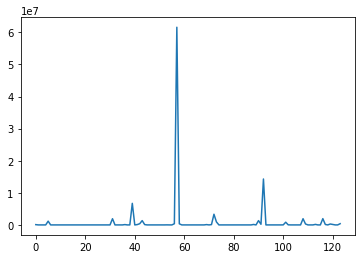

In [ ]:
classifier_4 = KNeighborsClassifier(n_neighbors = 3)
classifier_4.fit(modelingData_X, modelingData_y)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_c4, indexes_c4 = classifier_4.kneighbors(modelingData_X)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_c4.mean(axis=1))

In [ ]:
# Choose the Cutoff
outlierIndices_c4 = np.where(distances_c4.mean(axis=1) > (0.1 * 10**7))
distanceOutliers.update(outlierIndices_c4[0])
print("Number of Outliers: ", len(outlierIndices_c4[0]))
print("Outliers: ", outlierIndices_c4, "\n")

Number of Outliers:  10
Outliers:  (array([  5,  31,  39,  43,  57,  72,  90,  92, 108, 116]),) 



In [ ]:
outliers_c4 = modelingData.iloc[outlierIndices_c4]
outliers_c4

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650735,1277.060391,0
31,1,0,0,1,0,0,0,0,1,5,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.033103,775.667925,1
39,1,0,0,1,0,0,0,0,1,2,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4.602228,781.374872,1
43,1,0,0,1,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.390346,85.289272,1
57,0,1,0,0,0,0,0,0,1,13,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.171033,7.658454,0
72,1,0,0,1,0,0,0,0,1,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.263438,18.169620,1
90,1,1,0,0,1,0,1,0,1,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.373845,17.769683,0
92,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.880210,19.629317,1
108,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.677924,2.130889,1


#### Attempt #9

##### Just Predictors, Unscaled

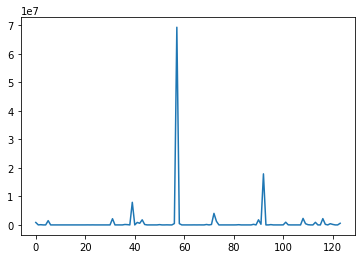

In [ ]:
classifier_5 = KNeighborsClassifier(n_neighbors = 4)
classifier_5.fit(modelingData_X, modelingData_y)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_c5, indexes_c5 = classifier_5.kneighbors(modelingData_X)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_c5.mean(axis=1))

In [ ]:
# Choose the Cutoff
outlierIndices_c5 = np.where(distances_c5.mean(axis=1) > (0.1 * 10**7))
distanceOutliers.update(outlierIndices_c5[0])
print("Number of Outliers: ", len(outlierIndices_c5[0]))
print("Outliers: ", outlierIndices_c5, "\n")

Number of Outliers:  11
Outliers:  (array([  5,  31,  39,  43,  57,  72,  73,  90,  92, 108, 116]),) 



In [ ]:
outliers_c5 = modelingData.iloc[outlierIndices_c5]
outliers_c5

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650735,1277.060391,0
31,1,0,0,1,0,0,0,0,1,5,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.033103,775.667925,1
39,1,0,0,1,0,0,0,0,1,2,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4.602228,781.374872,1
43,1,0,0,1,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.390346,85.289272,1
57,0,1,0,0,0,0,0,0,1,13,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.171033,7.658454,0
72,1,0,0,1,0,0,0,0,1,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.263438,18.169620,1
73,1,0,0,1,0,0,0,0,1,7,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,17.818640,684.748440,1
90,1,1,0,0,1,0,1,0,1,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.373845,17.769683,0
92,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.880210,19.629317,1


### Pruning

#### Attempt #1

##### Full, Unscaled

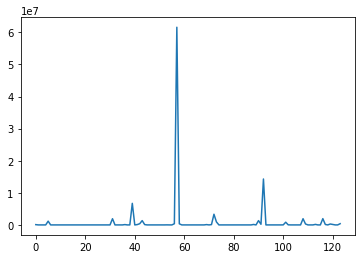

In [ ]:
# Initialize the Model
prune_1 = NearestNeighbors(n_neighbors = 3, radius = 1.5, algorithm = "kd_tree", leaf_size = 20)

# Fit the Model
prune_1.fit(modelingData)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_p1, indexes_p1 = prune_1.kneighbors(modelingData)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_p1.mean(axis=1))

In [ ]:
# Choose the Cutoff
outlierIndices_p1 = np.where(distances_p1.mean(axis=1) > (0.1 * 10**7))
distanceOutliers.update(outlierIndices_p1[0])
print("Number of Outliers: ", len(outlierIndices_p1[0]))
print("Outliers: ", outlierIndices_p1, "\n")

Number of Outliers:  10
Outliers:  (array([  5,  31,  39,  43,  57,  72,  90,  92, 108, 116]),) 



In [ ]:
outliers_p1 = modelingData.iloc[outlierIndices_p1]
outliers_p1

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650735,1277.060391,0
31,1,0,0,1,0,0,0,0,1,5,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.033103,775.667925,1
39,1,0,0,1,0,0,0,0,1,2,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4.602228,781.374872,1
43,1,0,0,1,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.390346,85.289272,1
57,0,1,0,0,0,0,0,0,1,13,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.171033,7.658454,0
72,1,0,0,1,0,0,0,0,1,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.263438,18.169620,1
90,1,1,0,0,1,0,1,0,1,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.373845,17.769683,0
92,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.880210,19.629317,1
108,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.677924,2.130889,1


#### Attempt #2

##### Full, Unscaled

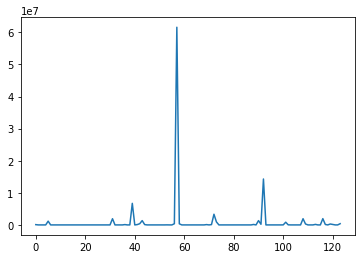

In [ ]:
# Initialize the Model
prune_2 = NearestNeighbors(n_neighbors = 3, radius = 10, algorithm = "kd_tree", leaf_size = 5)

# Fit the Model
prune_2.fit(modelingData)

# Extract the: (0) Distances Between Data Points and (1) Associated Index Values
distances_p2, indexes_p2 = prune_2.kneighbors(modelingData)

# Plot the Average of the k-Distances for Each Observation
plt.plot(distances_p2.mean(axis=1))

In [ ]:
# Choose the Cutoff
outlierIndices_p2 = np.where(distances_p2.mean(axis=1) > (0.1 * 10**7))
distanceOutliers.update(outlierIndices_p2[0])
print("Number of Outliers: ", len(outlierIndices_p2[0]))
print("Outliers: ", outlierIndices_p2, "\n")

Number of Outliers:  10
Outliers:  (array([  5,  31,  39,  43,  57,  72,  90,  92, 108, 116]),) 



In [ ]:
outliers_p2 = modelingData.iloc[outlierIndices_p2]
outliers_p2

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650735,1277.060391,0
31,1,0,0,1,0,0,0,0,1,5,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.033103,775.667925,1
39,1,0,0,1,0,0,0,0,1,2,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4.602228,781.374872,1
43,1,0,0,1,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.390346,85.289272,1
57,0,1,0,0,0,0,0,0,1,13,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.171033,7.658454,0
72,1,0,0,1,0,0,0,0,1,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.263438,18.169620,1
90,1,1,0,0,1,0,1,0,1,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.373845,17.769683,0
92,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.880210,19.629317,1
108,1,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.677924,2.130889,1


### Results

In [ ]:
print("Number of Outliers: ", len(distanceOutliers))

Number of Outliers:  19


In [ ]:
distanceOutliers_df = modelingData.iloc[list(distanceOutliers)]
distanceOutliers_df

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650735,1277.060391,0
20,0,0,1,0,0,0,0,1,2,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,3.009992,86.917957,0
27,0,0,0,0,0,0,0,0,2,11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.923336,39.873409,0
31,1,0,0,1,0,0,0,0,1,5,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.033103,775.667925,1
39,1,0,0,1,0,0,0,0,1,2,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4.602228,781.374872,1
43,1,0,0,1,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.390346,85.289272,1
57,0,1,0,0,0,0,0,0,1,13,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.171033,7.658454,0
60,1,1,0,0,0,0,0,0,2,11,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.485374,294.125542,1
72,1,0,0,1,0,0,0,0,1,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.263438,18.169620,1


In [ ]:
print("Number of Dropouts: ", len(distanceOutliers_df[distanceOutliers_df.PS_Graduated == 1]))
print("Number of Graduates: ", len(distanceOutliers_df[distanceOutliers_df.PS_Graduated == 0]))

Number of Dropouts:  10
Number of Graduates:  9


In [ ]:
dropoutPercentage = computePercentage(len(distanceOutliers_df[distanceOutliers_df.PS_Graduated == 1]), "Dropouts")
graduatePercentage = computePercentage(len(distanceOutliers_df[distanceOutliers_df.PS_Graduated == 0]), "Graduates")

print("This Model Identified " + str(dropoutPercentage) + "% of the College Dropouts. \n")
print("This Model Also Identified " + str(graduatePercentage) + "% of the College Graduates.")

This Model Identified 18.18% of the College Dropouts. 

This Model Also Identified 13.04% of the College Graduates.


In [ ]:
threshold = round(0.2 * len(distanceOutliers_df))
print("20% of the Outliers Is Equivalent to " + str(threshold) + " students.")

20% of the Outliers Is Equivalent to 4 students.


In [ ]:
# Comprehensive List of All 41 Categorical Variables (Excluding One-Hot Encoded Predictors)
categoricals = ["Gender", "Hispanic", "Asian", "Black", "White", "Hawaiian", "Multinational", "LimitedEnglish", "Eligibility", 
                "AcademNeed", "Grade_EnteredUB", "Participation", "AcademAch_ELA", "AcademAch_Math", "Employed", "CulturalAct", 
                "CommServ", "AP", "Honors", "Title1_School", "Title1_SchoolWide", "HS_TotalCrimesCateg", 
                "HS_PersonalCrimesCateg", "HS_MurdersCateg", "HS_RapesCateg", "HS_RobberiesCateg", "HS_AssaultsCateg", 
                "HS_PropertyCrimesCateg", "HS_BurglariesCateg", "HS_LarceniesCateg", "HS_VehicleTheftsCateg", 
                "Student_TotalCrimesCateg", "Student_PersonalCrimesCateg", "Student_MurdersCateg", 
                "Student_RapesCateg", "Student_RobberiesCateg", "Student_AssaultsCateg", "Student_PropertyCrimesCateg", 
                "Student_BurglariesCateg", "Student_LarceniesCateg", "Student_VehicleTheftsCateg"]
   
assessCategoricalPredictors(distanceOutliers_df, categoricals, "PS_Graduated")

PS_Graduated  Gender
0             0         5
              1         4
1             1         8
              0         2
Name: Gender, dtype: int64 

PS_Graduated  Hispanic
0             1           5
              0           4
1             0           7
              1           3
Name: Hispanic, dtype: int64 

PS_Graduated  Asian
0             0         7
              1         2
1             0        10
Name: Asian, dtype: int64 

PS_Graduated  Black
0             0        7
              1        2
1             1        7
              0        3
Name: Black, dtype: int64 

PS_Graduated  White
0             0         7
              1         2
1             0        10
Name: White, dtype: int64 

PS_Graduated  Hawaiian
0             0            9
1             0           10
Name: Hawaiian, dtype: int64 

PS_Graduated  Multinational
0             0                 6
              1                 3
1             0                10
Name: Multinational, dtype: int64 

PS

In [ ]:
studentZIPs = ["Std_07011", "Std_07026", "Std_07103", "Std_07104", "Std_07105", "Std_07106", "Std_07107", "Std_07108", 
               "Std_07112", "Std_07114", "Std_07501", "Std_07502", "Std_07503", "Std_07504", "Std_07505", "Std_07506",
               "Std_07513", "Std_07514", "Std_07522", "Std_07524"]

assessCategoricalPredictors(distanceOutliers_df, studentZIPs, "PS_Graduated")

PS_Graduated  Std_07011
0             0.0           9
1             0.0          10
Name: Std_07011, dtype: int64 

PS_Graduated  Std_07026
0             0.0          9
1             0.0          9
              1.0          1
Name: Std_07026, dtype: int64 

PS_Graduated  Std_07103
0             0.0          9
1             0.0          9
              1.0          1
Name: Std_07103, dtype: int64 

PS_Graduated  Std_07104
0             0.0          9
1             0.0          9
              1.0          1
Name: Std_07104, dtype: int64 

PS_Graduated  Std_07105
0             0.0          9
1             0.0          9
              1.0          1
Name: Std_07105, dtype: int64 

PS_Graduated  Std_07106
0             0.0           9
1             0.0          10
Name: Std_07106, dtype: int64 

PS_Graduated  Std_07107
0             0.0          9
1             0.0          9
              1.0          1
Name: Std_07107, dtype: int64 

PS_Graduated  Std_07108
0             0.0           8

In [ ]:
HSZIPs = ["HS_07103", "HS_07104", "HS_07105", "HS_07108", "HS_07470", "HS_07501", "HS_07502", "HS_07505", "HS_07514"]

assessCategoricalPredictors(distanceOutliers_df, HSZIPs, "PS_Graduated")

PS_Graduated  HS_07103
0             0.0         9
1             0.0         9
              1.0         1
Name: HS_07103, dtype: int64 

PS_Graduated  HS_07104
0             0.0         9
1             0.0         9
              1.0         1
Name: HS_07104, dtype: int64 

PS_Graduated  HS_07105
0             0.0         9
1             0.0         8
              1.0         2
Name: HS_07105, dtype: int64 

PS_Graduated  HS_07108
0             0.0         8
              1.0         1
1             0.0         7
              1.0         3
Name: HS_07108, dtype: int64 

PS_Graduated  HS_07470
0             0.0          8
              1.0          1
1             0.0         10
Name: HS_07470, dtype: int64 

PS_Graduated  HS_07501
0             0.0          7
              1.0          2
1             0.0         10
Name: HS_07501, dtype: int64 

PS_Graduated  HS_07502
0             0.0         6
              1.0         3
1             0.0         8
              1.0         2
Nam

In [ ]:
highSchools = ["Barringer High School", "East Side High School", "Eastside High School", "John F. Kennedy High School", 
               "Malcolm X Shabazz High School", "Passaic County Technical Institute", 
               "Rosa L. Parks School of Fine and Performing Arts", "School of Earth and Space Science", 
               "School of Government and Public Administration", "West Side High School"]

assessCategoricalPredictors(distanceOutliers_df, highSchools, "PS_Graduated")

PS_Graduated  Barringer High School
0             0.0                      9
1             0.0                      9
              1.0                      1
Name: Barringer High School, dtype: int64 

PS_Graduated  East Side High School
0             0.0                      9
1             0.0                      8
              1.0                      2
Name: East Side High School, dtype: int64 

PS_Graduated  Eastside High School
0             0.0                      8
              1.0                      1
1             0.0                     10
Name: Eastside High School, dtype: int64 

PS_Graduated  John F. Kennedy High School
0             0.0                            6
              1.0                            3
1             0.0                            8
              1.0                            2
Name: John F. Kennedy High School, dtype: int64 

PS_Graduated  Malcolm X Shabazz High School
0             0.0                              8
              1.0   

In [ ]:
collegesList = ["ALTIERUS CAREER EDUCATION", "BERKELEY COLLEGE", "BLOOMFIELD COLLEGE", "CENTRAL CONNECTICUT STATE UNIV", 
                "COLLEGE OF NEW JERSEY (THE)", "COMMUNITY COLLEGE OF RI - WARWICK", "DAYTONA STATE COLLEGE", "DEVRY UNIVERSITY",
                "DREW UNIVERSITY", "ENTERPRISE STATE COMMUNITY COLLEGE", "ESSEX COUNTY COLLEGE", 
                "FAIRLEIGH DICKINSON UNIV-TEANECK", "FORTIS INSTITUTE", "FRANCIS MARION UNIVERSITY", "KEAN UNIVERSITY", 
                "LINCOLN UNIVERSITY", "MARYMOUNT MANHATTAN COLLEGE", "MIDDLESEX COUNTY COLLEGE", "MONTCLAIR STATE UNIVERSITY", 
                "NEW JERSEY INST OF TECHNOLOGY", "NORTH CAROLINA CENTRAL UNIVERSITY", "OAKWOOD UNIVERSITY", 
                "PASSAIC COUNTY COMMUNITY COLLEGE", "RAMAPO COLLEGE OF NEW JERSEY", "RIDER UNIVERSITY", "ROWAN UNIVERSITY", 
                "RUTGERS, THE STATE UNIVERSITY OF NJ", "SETON HALL UNIVERSITY", "STANFORD UNIVERSITY",
                "STEVENS INSTITUTE OF TECHNOLOGY", "STOCKTON UNIVERSITY", "SYRACUSE UNIVERSITY", "TEMPLE UNIVERSITY", 
                "UNION COUNTY COLLEGE", "UNIVERSITY OF NEW HAVEN", "UNIVERSITY OF WISCONSIN-MADISON", 
                "VAUGHN COLLEGE OF AERONAUTICS AND TECHNO", "VIRGINIA STATE UNIVERSITY", "WILLIAM PATERSON UNIVERSITY"]

assessCategoricalPredictors(distanceOutliers_df, collegesList, "PS_Graduated")

PS_Graduated  ALTIERUS CAREER EDUCATION
0             0.0                          9
1             0.0                          8
              1.0                          2
Name: ALTIERUS CAREER EDUCATION, dtype: int64 

PS_Graduated  BERKELEY COLLEGE
0             0.0                 9
1             0.0                 8
              1.0                 2
Name: BERKELEY COLLEGE, dtype: int64 

PS_Graduated  BLOOMFIELD COLLEGE
0             0.0                    9
1             0.0                   10
Name: BLOOMFIELD COLLEGE, dtype: int64 

PS_Graduated  CENTRAL CONNECTICUT STATE UNIV
0             0.0                                9
1             0.0                               10
Name: CENTRAL CONNECTICUT STATE UNIV, dtype: int64 

PS_Graduated  COLLEGE OF NEW JERSEY (THE)
0             0.0                             8
              1.0                             1
1             0.0                            10
Name: COLLEGE OF NEW JERSEY (THE), dtype: int64 

PS_Graduate

<font color=royalblue>The results show:
- Female students are more likely to drop out of college
- African American/Black students are more likely to drop out of college
- Students who first joined Upward Bound as a 9th grader are more likely to drop out of college
- Students who participate in community service in high school are more likely to drop out of college 
- Students from high schools that are Title I school-wide are more likely to drop out of college</font>

In [ ]:
# Comprehensive List of All 48 Continuous Variables
continuous = ["GPA", "HSGrad_Age", "Absences", "SAT_Reading", "SAT_Math", "SAT_Writing", "StudentTeacherRatio", "NumFreeLunch", 
              "NumReducedLunch", "%_Female", "%_Male", "%_EconomDisadv", "%_w/Disabilities", "%_ELL", "%_Homeless", 
              "%_FosterCare", "%_White", "%_Hispanic", "%_Black", "%_Asian", "%_Hawaiian", "%_AmericanIndian", 
              "HS_CrimesIndex_2020", "HS_PersonalCrimesIndex_2020", "HS_MurdersIndex_2020","HS_RapesIndex_2020", 
              "HS_RobberiesIndex_2020", "HS_AssaultsIndex_2020", "HS_PropertyCrimesIndex_2020", "HS_BurglariesIndex_2020", 
              "HS_LarceniesIndex_2020", "HS_VehicleTheftsIndex_2020", "HS_AreaPopulation_2020", "HS_Area", 
              "Student_CrimesIndex_2020", "Student_PersonalCrimesIndex_2020", "Student_MurdersIndex_2020", 
              "Student_RapesIndex_2020", "Student_RobberiesIndex_2020", "Student_AssaultsIndex_2020", 
              "Student_PropertyCrimesIndex_2020", "Student_BurglariesIndex_2020", "Student_LarceniesIndex_2020", 
              "Student_VehicleTheftsIndex_2020", "Student_AreaPopulation_2020", "Student_Area", "Distance_to_HS", 
              "Distance_to_PS"]

# Create a DataFrame of the Outliers with Only the Continuous Predictiors and PS_Graduated
distanceOutliers_continuous = distanceOutliers_df.drop(categoricals, axis=1)
distanceOutliers_continuous.drop(studentZIPs, axis=1, inplace=True)
distanceOutliers_continuous.drop(HSZIPs, axis=1, inplace=True)
distanceOutliers_continuous.drop(highSchools, axis=1, inplace=True)
distanceOutliers_continuous.drop(collegesList, axis=1, inplace=True)
distanceOutliers_continuous

,GPA,HSGrad_Age,Absences,SAT_Reading,SAT_Math,SAT_Writing,StudentTeacherRatio,NumFreeLunch,NumReducedLunch,%_Female,...,Student_AssaultsIndex_2020,Student_PropertyCrimesIndex_2020,Student_BurglariesIndex_2020,Student_LarceniesIndex_2020,Student_VehicleTheftsIndex_2020,Student_AreaPopulation_2020,Student_Area,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
5,3.788000,6479,5,440,520,520,13.450000,310.75,0.000000,44.625000,...,166.0,170.0,188.0,156.0,245.0,1674.0,8.768255e+05,0.650735,1277.060391,0
20,3.932000,6569,7,580,360,434,13.450000,310.75,0.000000,44.625000,...,97.0,78.0,99.0,65.0,136.0,19067.0,8.120610e+06,3.009992,86.917957,0
27,3.490000,6594,6,390,450,420,10.000000,221.00,14.000000,46.000000,...,240.0,112.0,137.0,70.0,381.0,25973.0,6.369931e+06,1.923336,39.873409,0
31,2.500000,6631,9,420,477,434,10.000000,221.00,14.000000,46.000000,...,126.0,90.0,86.0,55.0,364.0,51735.0,1.256741e+07,2.033103,775.667925,1
39,2.100000,6452,10,420,477,434,10.000000,221.00,14.000000,46.000000,...,55.0,72.0,45.0,61.0,199.0,48894.0,2.120364e+07,4.602228,781.374872,1
43,3.763000,6570,7,370,520,370,11.900000,111.00,0.000000,37.500000,...,196.0,120.0,177.0,99.0,179.0,34962.0,7.265109e+06,0.390346,85.289272,1
57,3.920000,6688,8,420,477,434,11.900000,1663.00,304.000000,56.000000,...,184.0,95.0,175.0,65.0,169.0,21038.0,3.816374e+06,1.171033,7.658454,0
60,4.171800,6420,7,420,530,500,13.450000,310.75,0.000000,44.625000,...,184.0,95.0,175.0,65.0,169.0,21038.0,3.816374e+06,0.485374,294.125542,1
72,3.000000,6379,7,370,390,340,13.700000,837.00,76.000000,44.500000,...,211.0,118.0,120.0,83.0,386.0,34463.0,9.675036e+06,2.263438,18.169620,1


##### Check If Dropout Value Is 20% Above or 20% Below the Graduate Value

In [ ]:
distanceOutliers_groupedContinuous = distanceOutliers_continuous.groupby("PS_Graduated").agg("mean")

In [ ]:
# First Third of the Predictors
distanceOutliers_groupedContinuous.iloc[:, :16]

,GPA,HSGrad_Age,Absences,SAT_Reading,SAT_Math,SAT_Writing,StudentTeacherRatio,NumFreeLunch,NumReducedLunch,%_Female,%_Male,%_EconomDisadv,%_w/Disabilities,%_ELL,%_Homeless,%_FosterCare
PS_Graduated,,,,,,,,,,,,,,,,
0,3.606356,6691.111111,6.888889,450.0,460.555556,451.555556,12.309259,420.805556,37.185185,49.060185,50.939815,64.133333,16.333333,17.712037,0.818519,0.260185
1,3.032480,6578.000000,9.000000,397.0,458.800000,403.600000,12.380000,520.050000,59.700000,44.875000,55.125000,68.070000,19.480000,17.195000,1.250000,0.595000


In [ ]:
distanceOutliers_groupedContinuous.iloc[:, :16].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

GPA                    0
HSGrad_Age             0
Absences               1
SAT_Reading            0
SAT_Math               0
SAT_Writing            0
StudentTeacherRatio    0
NumFreeLunch           1
NumReducedLunch        1
%_Female               0
%_Male                 0
%_EconomDisadv         0
%_w/Disabilities       0
%_ELL                  0
%_Homeless             1
%_FosterCare           1
dtype: int64

In [ ]:
# Middle Third of the Predictors
distanceOutliers_groupedContinuous.iloc[:, 16:32]

,%_White,%_Hispanic,%_Black,%_Asian,HS_CrimesIndex_2020,HS_PersonalCrimesIndex_2020,HS_MurdersIndex_2020,HS_RapesIndex_2020,HS_RobberiesIndex_2020,HS_AssaultsIndex_2020,HS_PropertyCrimesIndex_2020,HS_BurglariesIndex_2020,HS_LarceniesIndex_2020,HS_VehicleTheftsIndex_2020,HS_AreaPopulation_2020,HS_Area
PS_Graduated,,,,,,,,,,,,,,,,
0,4.45,61.388889,28.764815,5.248148,109.444444,179.444444,262.666667,70.777778,341.888889,131.222222,98.111111,131.666667,79.333333,175.888889,23869.111111,1.686518e+07
1,7.31,43.500000,46.340000,2.810000,114.000000,207.400000,460.600000,91.600000,391.700000,148.500000,99.000000,111.900000,71.400000,281.600000,29368.300000,9.270478e+06


In [ ]:
distanceOutliers_groupedContinuous.iloc[:, 16:32].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

%_White                        1
%_Hispanic                     1
%_Black                        1
%_Asian                        1
HS_CrimesIndex_2020            0
HS_PersonalCrimesIndex_2020    0
HS_MurdersIndex_2020           1
HS_RapesIndex_2020             1
HS_RobberiesIndex_2020         0
HS_AssaultsIndex_2020          0
HS_PropertyCrimesIndex_2020    0
HS_BurglariesIndex_2020        0
HS_LarceniesIndex_2020         0
HS_VehicleTheftsIndex_2020     1
HS_AreaPopulation_2020         1
HS_Area                        1
dtype: int64

In [ ]:
# Final Third of the Predictors
distanceOutliers_groupedContinuous.iloc[:, 32:]

,Student_CrimesIndex_2020,Student_PersonalCrimesIndex_2020,Student_MurdersIndex_2020,Student_RapesIndex_2020,Student_RobberiesIndex_2020,Student_AssaultsIndex_2020,Student_PropertyCrimesIndex_2020,Student_BurglariesIndex_2020,Student_LarceniesIndex_2020,Student_VehicleTheftsIndex_2020,Student_AreaPopulation_2020,Student_Area,Distance_to_HS,Distance_to_PS
PS_Graduated,,,,,,,,,,,,,,
0,119.555556,216.444444,305.222222,74.555556,417.333333,158.444444,103.888889,145.777778,81.666667,193.222222,19380.555556,5.540966e+06,1.884448,162.428188
1,112.900000,199.900000,362.500000,80.400000,379.000000,145.300000,98.500000,113.700000,76.200000,240.400000,33048.100000,1.244836e+07,4.942816,701.289190


In [ ]:
distanceOutliers_groupedContinuous.iloc[:, 32:].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

Student_CrimesIndex_2020            0
Student_PersonalCrimesIndex_2020    0
Student_MurdersIndex_2020           0
Student_RapesIndex_2020             0
Student_RobberiesIndex_2020         0
Student_AssaultsIndex_2020          0
Student_PropertyCrimesIndex_2020    0
Student_BurglariesIndex_2020        1
Student_LarceniesIndex_2020         0
Student_VehicleTheftsIndex_2020     1
Student_AreaPopulation_2020         1
Student_Area                        1
Distance_to_HS                      1
Distance_to_PS                      1
dtype: int64

<font color=royalblue>The results show:
- Students with a larger number of absences are more likely to drop out of college
- Students from high schools with a larger population of Free Lunch students are more likely to drop out of college
- Students from high schools with a larger population of Reduced Lunch students are more likely to drop out of college
- Students from high schools with a larger proportion of homeless students are more likely to drop out of college
- Students from high schools with a larger proportion of students in Foster Care are more likely to drop out of college
- Students from high schools with a larger proportion of White students are more likely to drop out of college
- Students from high schools with a larger proportion of African American/Black students are more likely to drop out of college
- Students from high schools in areas with higher personal crime rates are more likely to drop out of college
- Students from high schools in areas with higher murder crime rates are more likely to drop out of college
- Students from high schools in areas with higher rape crime rates are more likely to drop out of college
- Students from high schools in areas with higher robbery crime rates are more likely to drop out of college
- Students from high schools in areas with higher vehicle theft crime rates are more likely to drop out of college
- Students from high schools in more populous areas are more likely to drop out of college
- Students who live in areas with higher murder crime rates are more likely to drop out of college
- Students who live in areas with higher vehicle theft crime rates are more likely to drop out of college
- Students who live in more populous areas are more likely to drop out of college
- Students who live in larger areas are more likely to drop out of college
- Students who attend high school farther away from home are more likely to drop out of college
- Students who attend college farther away from home are more likely to drop out of college</font>

<font color=mediumorchid>The results show:
- Students from high schools with a larger proportion of Hispanic students are more likely to graduate college
- Students from high schools with a larger proportion of Asian students are more likely to graduate college
- Students from high schools in areas with higher burglary crime rates are more likely to graduate college
- Students from high schools in larger areas are more likely to graduate college
- Students who live in areas with higher robbery crime rates are more likely to graduate college
- Students who live in areas with higher burglary crime rates are more likely to graduate college</font>

# Clustering-Based Techniques

### k-Means

<font color=red>Obvious Difference Between Scaled and Unscaled; more diverse with scaled<br> $\therefore$ Use Scaled Data</font>

#### Attempt #1

##### Full, Unscaled

In [ ]:
kmeans1 = KMeans(n_clusters = 2, random_state = 42)
y_pred_kmeans1 = kmeans1.fit_predict(modelingData)
print("Predicted Number of Dropouts: ", np.sum(y_pred_kmeans1))
print("Predicted Number of Graduates: ", len(y_pred_kmeans1) - np.sum(y_pred_kmeans1))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_kmeans1 - modelingData_y)))

y_pred_kmeans1

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
kmeans1.n_features_in_

166

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_kmeans1))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_kmeans1))
print("Precision: ", precision_score(modelingData_y, y_pred_kmeans1))
print("Recall: ", recall_score(modelingData_y, y_pred_kmeans1))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_kmeans1))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### <font color=limegreen>Attempt #2</font>

##### Full, Scaled

In [ ]:
y_pred_kmeans2 = kmeans1.fit_predict(modelingData_scaled)
print("Predicted Number of Dropouts: ", np.sum(y_pred_kmeans2))
print("Predicted Number of Graduates: ", len(y_pred_kmeans2) - np.sum(y_pred_kmeans2))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_kmeans2 - modelingData_y)))

y_pred_kmeans2

Predicted Number of Dropouts:  20
Predicted Number of Graduates:  104
Number of Incorrect Predictions:  53


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
kmeans1.n_features_in_

166

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_kmeans2))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_kmeans2))
print("Precision: ", precision_score(modelingData_y, y_pred_kmeans2))
print("Recall: ", recall_score(modelingData_y, y_pred_kmeans2))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_kmeans2))

Area Under the Curve:  0.5347826086956522
Accuracy_Score:  0.5725806451612904
Precision:  0.55
Recall:  0.2

 Confusion Matrix: 
  [[60  9]
 [44 11]]


#### Attempt #3

##### Just Predictors, Unscaled

In [ ]:
y_pred_kmeans3 = kmeans1.fit_predict(modelingData_X)
print("Predicted Number of Dropouts: ", np.sum(y_pred_kmeans3))
print("Predicted Number of Graduates: ", len(y_pred_kmeans3) - np.sum(y_pred_kmeans3))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_kmeans3 - modelingData_y)))

y_pred_kmeans3

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
kmeans1.n_features_in_

165

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_kmeans3))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_kmeans3))
print("Precision: ", precision_score(modelingData_y, y_pred_kmeans3))
print("Recall: ", recall_score(modelingData_y, y_pred_kmeans3))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_kmeans3))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #4

##### Just Predictors, Scaled

In [ ]:
y_pred_kmeans4 = kmeans1.fit_predict(modelingData_X_scaled)
print("Predicted Number of Dropouts: ", np.sum(y_pred_kmeans4))
print("Predicted Number of Graduates: ", len(y_pred_kmeans4) - np.sum(y_pred_kmeans4))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_kmeans4 - modelingData_y)))

y_pred_kmeans4

Predicted Number of Dropouts:  20
Predicted Number of Graduates:  104
Number of Incorrect Predictions:  53


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
kmeans1.n_features_in_

165

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_kmeans4))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_kmeans4))
print("Precision: ", precision_score(modelingData_y, y_pred_kmeans4))
print("Recall: ", recall_score(modelingData_y, y_pred_kmeans4))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_kmeans4))

Area Under the Curve:  0.5347826086956522
Accuracy_Score:  0.5725806451612904
Precision:  0.55
Recall:  0.2

 Confusion Matrix: 
  [[60  9]
 [44 11]]


#### Attempt #5

##### Full, Scaled

In [ ]:
kmeans2 = KMeans(n_clusters = 2, max_iter = 1000, random_state = 42)
y_pred_kmeans5 = kmeans2.fit_predict(modelingData_scaled)
print("Predicted Number of Dropouts: ", np.sum(y_pred_kmeans5))
print("Predicted Number of Graduates: ", len(y_pred_kmeans5) - np.sum(y_pred_kmeans5))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_kmeans5 - modelingData_y)))

y_pred_kmeans5

Predicted Number of Dropouts:  20
Predicted Number of Graduates:  104
Number of Incorrect Predictions:  53


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
kmeans2.n_features_in_

166

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_kmeans5))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_kmeans5))
print("Precision: ", precision_score(modelingData_y, y_pred_kmeans5))
print("Recall: ", recall_score(modelingData_y, y_pred_kmeans5))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_kmeans5))

Area Under the Curve:  0.5347826086956522
Accuracy_Score:  0.5725806451612904
Precision:  0.55
Recall:  0.2

 Confusion Matrix: 
  [[60  9]
 [44 11]]


#### Attempt #6

##### Full, Scaled

In [ ]:
kmeans3 = KMeans(n_clusters = 2, max_iter = 1000, tol = 0.00001, random_state = 42)
y_pred_kmeans6 = kmeans3.fit_predict(modelingData_scaled)
print("Predicted Number of Dropouts: ", np.sum(y_pred_kmeans6))
print("Predicted Number of Graduates: ", len(y_pred_kmeans6) - np.sum(y_pred_kmeans6))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_kmeans6 - modelingData_y)))

y_pred_kmeans6

Predicted Number of Dropouts:  20
Predicted Number of Graduates:  104
Number of Incorrect Predictions:  53


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_kmeans6))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_kmeans6))
print("Precision: ", precision_score(modelingData_y, y_pred_kmeans6))
print("Recall: ", recall_score(modelingData_y, y_pred_kmeans6))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_kmeans6))

Area Under the Curve:  0.5347826086956522
Accuracy_Score:  0.5725806451612904
Precision:  0.55
Recall:  0.2

 Confusion Matrix: 
  [[60  9]
 [44 11]]


#### Attempt #7

##### Full, Scaled

In [ ]:
kmeans4 = KMeans(n_clusters = 2, n_init = 20, random_state = 42)
y_pred_kmeans7 = kmeans4.fit_predict(modelingData_scaled)
print("Predicted Number of Dropouts: ", np.sum(y_pred_kmeans7))
print("Predicted Number of Graduates: ", len(y_pred_kmeans7) - np.sum(y_pred_kmeans7))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_kmeans7 - modelingData_y)))

y_pred_kmeans7

Predicted Number of Dropouts:  20
Predicted Number of Graduates:  104
Number of Incorrect Predictions:  53


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_kmeans7))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_kmeans7))
print("Precision: ", precision_score(modelingData_y, y_pred_kmeans7))
print("Recall: ", recall_score(modelingData_y, y_pred_kmeans7))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_kmeans7))

Area Under the Curve:  0.5347826086956522
Accuracy_Score:  0.5725806451612904
Precision:  0.55
Recall:  0.2

 Confusion Matrix: 
  [[60  9]
 [44 11]]


#### Attempt #8

##### Full, Scaled

In [ ]:
kmeans5 = KMeans(n_clusters = 2, random_state = 42, algorithm = "full")
y_pred_kmeans8 = kmeans5.fit_predict(modelingData_scaled)
print("Predicted Number of Dropouts: ", np.sum(y_pred_kmeans8))
print("Predicted Number of Graduates: ", len(y_pred_kmeans8) - np.sum(y_pred_kmeans8))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_kmeans8 - modelingData_y)))

y_pred_kmeans8

Predicted Number of Dropouts:  20
Predicted Number of Graduates:  104
Number of Incorrect Predictions:  53


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_kmeans8))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_kmeans8))
print("Precision: ", precision_score(modelingData_y, y_pred_kmeans8))
print("Recall: ", recall_score(modelingData_y, y_pred_kmeans8))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_kmeans8))

Area Under the Curve:  0.5347826086956522
Accuracy_Score:  0.5725806451612904
Precision:  0.55
Recall:  0.2

 Confusion Matrix: 
  [[60  9]
 [44 11]]


#### Results

In [ ]:
best_kmeans = y_pred_kmeans2

kMeansOutliers_df = modelingData.copy()
kMeansOutliers_df["kMeansValue"] = best_kmeans
kMeansOutliers_df

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated,kMeansValue
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,1,11,...,0.0,0.0,1.0,0.0,1.0,0.0,1.527317,2.651641,1,0
1,1,1,0,0,0,0,0,0,2,11,...,0.0,0.0,0.0,0.0,1.0,0.0,3.227670,27.026511,0,0
2,0,1,0,0,0,0,0,0,3,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.803466,5.922479,1,0
3,0,0,0,1,0,0,0,0,1,13,...,0.0,0.0,1.0,0.0,1.0,0.0,1.287508,20.718053,1,0
4,1,1,0,0,0,0,0,0,3,11,...,0.0,1.0,1.0,0.0,1.0,0.0,4.410934,2.378576,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,1,0,0,0,0,0,0,1,13,...,0.0,1.0,1.0,1.0,1.0,0.0,19.355286,20.589324,1,0
120,1,0,0,0,1,0,0,0,1,13,...,0.0,1.0,1.0,0.0,1.0,0.0,22.010710,161.404493,1,0
121,0,1,0,0,0,0,0,0,1,11,...,0.0,1.0,1.0,1.0,1.0,0.0,2.954628,18.060702,0,0


In [ ]:
threshold = round(0.2 * len(kMeansOutliers_df))
print("20% of the Outliers Is Equivalent to " + str(threshold) + " students.")

20% of the Outliers Is Equivalent to 25 students.


In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, best_kmeans))
print("Accuracy_Score: ", accuracy_score(modelingData_y, best_kmeans))
print("Precision: ", precision_score(modelingData_y, best_kmeans))
print("Recall: ", recall_score(modelingData_y, best_kmeans))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, best_kmeans))

Area Under the Curve:  0.5347826086956522
Accuracy_Score:  0.5725806451612904
Precision:  0.55
Recall:  0.2

 Confusion Matrix: 
  [[60  9]
 [44 11]]


In [ ]:
assessCategoricalPredictors(kMeansOutliers_df, categoricals, "kMeansValue")

kMeansValue  Gender
0            1         60
             0         44
1            0         11
             1          9
Name: Gender, dtype: int64 

kMeansValue  Hispanic
0            0           52
             1           52
1            0           19
             1            1
Name: Hispanic, dtype: int64 

kMeansValue  Asian
0            0        82
             1        22
1            0        20
Name: Asian, dtype: int64 

kMeansValue  Black
0            0        76
             1        28
1            1        18
             0         2
Name: Black, dtype: int64 

kMeansValue  White
0            0        86
             1        18
1            0        19
             1         1
Name: White, dtype: int64 

kMeansValue  Hawaiian
0            0           103
             1             1
1            0            20
Name: Hawaiian, dtype: int64 

kMeansValue  Multinational
0            0                87
             1                17
1            0                19


In [ ]:
assessCategoricalPredictors(kMeansOutliers_df, studentZIPs, "kMeansValue")

kMeansValue  Std_07011
0            0.0          104
1            0.0           20
Name: Std_07011, dtype: int64 

kMeansValue  Std_07026
0            0.0          103
             1.0            1
1            0.0           20
Name: Std_07026, dtype: int64 

kMeansValue  Std_07103
0            0.0          104
1            0.0           15
             1.0            5
Name: Std_07103, dtype: int64 

kMeansValue  Std_07104
0            0.0          104
1            0.0           19
             1.0            1
Name: Std_07104, dtype: int64 

kMeansValue  Std_07105
0            0.0          104
1            0.0           19
             1.0            1
Name: Std_07105, dtype: int64 

kMeansValue  Std_07106
0            0.0          104
1            0.0           20
Name: Std_07106, dtype: int64 

kMeansValue  Std_07107
0            0.0          104
1            0.0           19
             1.0            1
Name: Std_07107, dtype: int64 

kMeansValue  Std_07108
0            0.0      

In [ ]:
assessCategoricalPredictors(kMeansOutliers_df, HSZIPs, "kMeansValue")

kMeansValue  HS_07103
0            0.0         104
1            0.0          19
             1.0           1
Name: HS_07103, dtype: int64 

kMeansValue  HS_07104
0            0.0         104
1            0.0          19
             1.0           1
Name: HS_07104, dtype: int64 

kMeansValue  HS_07105
0            0.0         74
             1.0         30
1            0.0         20
Name: HS_07105, dtype: int64 

kMeansValue  HS_07108
0            0.0         104
1            1.0          18
             0.0           2
Name: HS_07108, dtype: int64 

kMeansValue  HS_07470
0            0.0         103
             1.0           1
1            0.0          20
Name: HS_07470, dtype: int64 

kMeansValue  HS_07501
0            0.0         102
             1.0           2
1            0.0          20
Name: HS_07501, dtype: int64 

kMeansValue  HS_07502
0            0.0         56
             1.0         48
1            0.0         20
Name: HS_07502, dtype: int64 

kMeansValue  HS_07505
0   

In [ ]:
assessCategoricalPredictors(kMeansOutliers_df, highSchools, "kMeansValue")

kMeansValue  Barringer High School
0            0.0                      104
1            0.0                       19
             1.0                        1
Name: Barringer High School, dtype: int64 

kMeansValue  East Side High School
0            0.0                      74
             1.0                      30
1            0.0                      20
Name: East Side High School, dtype: int64 

kMeansValue  Eastside High School
0            0.0                     103
             1.0                       1
1            0.0                      20
Name: Eastside High School, dtype: int64 

kMeansValue  John F. Kennedy High School
0            0.0                            56
             1.0                            48
1            0.0                            20
Name: John F. Kennedy High School, dtype: int64 

kMeansValue  Malcolm X Shabazz High School
0            0.0                              104
1            1.0                               18
             0.0  

In [ ]:
assessCategoricalPredictors(kMeansOutliers_df, collegesList, "kMeansValue")

kMeansValue  ALTIERUS CAREER EDUCATION
0            0.0                          104
1            0.0                           18
             1.0                            2
Name: ALTIERUS CAREER EDUCATION, dtype: int64 

kMeansValue  BERKELEY COLLEGE
0            0.0                 104
1            0.0                  18
             1.0                   2
Name: BERKELEY COLLEGE, dtype: int64 

kMeansValue  BLOOMFIELD COLLEGE
0            0.0                   103
             1.0                     1
1            0.0                    18
             1.0                     2
Name: BLOOMFIELD COLLEGE, dtype: int64 

kMeansValue  CENTRAL CONNECTICUT STATE UNIV
0            0.0                               104
1            0.0                                19
             1.0                                 1
Name: CENTRAL CONNECTICUT STATE UNIV, dtype: int64 

kMeansValue  COLLEGE OF NEW JERSEY (THE)
0            0.0                            99
             1.0            

<font color=mediumorchid>The results show:
- Students who are both low income and first generation are more likely to graduate college
- Students from predominately low income communities are more likely to graduate college
- Students who are interested in math and/or science are more likely to graduate college
- Students who first joined Upward Bound as a 9th or 10th grader are more likely to graduate college
- Students who only participate in Upward Bound during the academic year are more likely to graduate college
- Students who are inactive in Upward Bound during their senior year are more likely to graduate college
- Students who achieve proficiency in ELA are more likely to graduate college
- Students who achieve proficiency in math are more likely to graduate college
- Students who are unemployed in high school are more likely to graduate college
- Students who participate in cultural activities in high school are more likely to graduate college
- Students who take at least one Honors class are more likely to graduate college
- Students from high schools that are Title I are more likely to graduate college
- Students from high schools in areas of high personal crimes are more likely to graduate college
- Students from high schools in areas of high murder crimes are more likely to graduate college
- Students from high schools in areas of low rape crimes are more likely to graduate college
- Students from high schools in areas of high robbery crimes are more likely to graduate college
- Students from high schools in areas of low property crimes are more likely to graduate college
- Students from high schools in areas of low larceny crimes are more likely to graduate college
- Students from high schools in areas of high vehicle theft crimes are more likely to graduate college
- Students who live in areas of high personal crimes are more likely to graduate college
- Students who live in areas of high murder crimes are more likely to graduate college
- Students who live in areas of low rape crimes are more likely to graduate college
- Students who live in areas of high robbery crimes are more likely to graduate college
- Students who live in areas of low property crimes are more likely to graduate college
- Students who live in areas of high burglary crimes are more likely to graduate college
- Students who live in areas of low larceny crimes are more likely to graduate college
- Students who live in areas of high vehicle theft crimes are more likely to graduate college</font>

In [ ]:
# Create a DataFrame of the Outliers with Only the Continuous Predictiors and PS_Graduated
kMeansOutliers_continuous = kMeansOutliers_df.drop(categoricals, axis=1)
kMeansOutliers_continuous.drop(studentZIPs, axis=1, inplace=True)
kMeansOutliers_continuous.drop(HSZIPs, axis=1, inplace=True)
kMeansOutliers_continuous.drop(highSchools, axis=1, inplace=True)
kMeansOutliers_continuous.drop(collegesList, axis=1, inplace=True)
kMeansOutliers_continuous

,GPA,HSGrad_Age,Absences,SAT_Reading,SAT_Math,SAT_Writing,StudentTeacherRatio,NumFreeLunch,NumReducedLunch,%_Female,...,Student_PropertyCrimesIndex_2020,Student_BurglariesIndex_2020,Student_LarceniesIndex_2020,Student_VehicleTheftsIndex_2020,Student_AreaPopulation_2020,Student_Area,Distance_to_HS,Distance_to_PS,PS_Graduated,kMeansValue
ID,,,,,,,,,,,,,,,,,,,,,
0,3.370,6564,7,520,610,470,11.90,111.00,0.0,37.500,...,95.0,175.0,65.0,169.0,21038.0,3816374.384,1.527317,2.651641,1,0
1,2.710,6769,1,420,477,434,13.45,310.75,0.0,44.625,...,120.0,188.0,91.0,208.0,12392.0,3769562.775,3.227670,27.026511,0,0
2,2.440,6474,7,420,490,410,8.50,120.00,14.0,69.000,...,120.0,177.0,99.0,179.0,34962.0,7265109.163,1.803466,5.922479,1,0
3,3.446,6633,3,460,490,490,13.45,310.75,0.0,44.625,...,95.0,175.0,65.0,169.0,21038.0,3816374.384,1.287508,20.718053,1,0
4,3.760,6522,9,420,477,434,8.50,120.00,14.0,69.000,...,66.0,112.0,44.0,140.0,15052.0,4034220.467,4.410934,2.378576,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2.061,7138,10,420,477,434,13.60,1307.00,222.0,45.000,...,78.0,99.0,65.0,136.0,19067.0,8120610.007,19.355286,20.589324,1,0
120,3.105,6668,1,400,450,340,13.60,1307.00,222.0,45.000,...,66.0,112.0,44.0,140.0,15052.0,4034220.467,22.010710,161.404493,1,0
121,4.550,6553,7,490,600,480,13.45,310.75,0.0,44.625,...,78.0,99.0,65.0,136.0,19067.0,8120610.007,2.954628,18.060702,0,0


##### Check If Dropout Value Is 20% Above or 20% Below the Graduate Value

In [ ]:
kMeansOutliers_groupedContinuous = kMeansOutliers_continuous.groupby("kMeansValue").agg("mean")

In [ ]:
# First Third of the Predictors
kMeansOutliers_groupedContinuous.iloc[:, :16]

,GPA,HSGrad_Age,Absences,SAT_Reading,SAT_Math,SAT_Writing,StudentTeacherRatio,NumFreeLunch,NumReducedLunch,%_Female,%_Male,%_EconomDisadv,%_w/Disabilities,%_ELL,%_Homeless,%_FosterCare
kMeansValue,,,,,,,,,,,,,,,,
0,3.486659,6628.548077,9.394231,435.288462,483.711538,440.538462,12.558974,569.653846,69.410256,48.814103,51.185897,69.103846,16.240385,23.340705,0.685256,0.120833
1,3.024300,6633.800000,9.050000,402.500000,461.500000,414.000000,10.390000,258.450000,18.150000,46.100000,53.900000,62.205000,23.820000,2.425000,1.885000,1.315000


In [ ]:
kMeansOutliers_groupedContinuous.iloc[:, :16].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

GPA                    0
HSGrad_Age             0
Absences               0
SAT_Reading            0
SAT_Math               0
SAT_Writing            0
StudentTeacherRatio    0
NumFreeLunch           1
NumReducedLunch        1
%_Female               0
%_Male                 0
%_EconomDisadv         0
%_w/Disabilities       1
%_ELL                  1
%_Homeless             1
%_FosterCare           1
dtype: int64

In [ ]:
# Middle Third of the Predictors
kMeansOutliers_groupedContinuous.iloc[:, 16:32]

,%_White,%_Hispanic,%_Black,%_Asian,HS_CrimesIndex_2020,HS_PersonalCrimesIndex_2020,HS_MurdersIndex_2020,HS_RapesIndex_2020,HS_RobberiesIndex_2020,HS_AssaultsIndex_2020,HS_PropertyCrimesIndex_2020,HS_BurglariesIndex_2020,HS_LarceniesIndex_2020,HS_VehicleTheftsIndex_2020,HS_AreaPopulation_2020,HS_Area
kMeansValue,,,,,,,,,,,,,,,,
0,11.418269,63.048077,19.615705,5.896474,83.182692,120.961538,149.75,62.182692,230.240385,86.740385,77.336538,100.817308,59.451923,162.990385,25551.278846,1.000256e+07
1,0.285000,13.865000,85.765000,0.070000,139.300000,312.750000,849.55,148.350000,556.900000,232.850000,111.200000,133.600000,69.900000,380.400000,27685.600000,6.845060e+06


In [ ]:
kMeansOutliers_groupedContinuous.iloc[:, 16:32].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

%_White                        1
%_Hispanic                     1
%_Black                        1
%_Asian                        1
HS_CrimesIndex_2020            1
HS_PersonalCrimesIndex_2020    1
HS_MurdersIndex_2020           1
HS_RapesIndex_2020             1
HS_RobberiesIndex_2020         1
HS_AssaultsIndex_2020          1
HS_PropertyCrimesIndex_2020    1
HS_BurglariesIndex_2020        1
HS_LarceniesIndex_2020         0
HS_VehicleTheftsIndex_2020     1
HS_AreaPopulation_2020         0
HS_Area                        1
dtype: int64

In [ ]:
# Final Third of the Predictors
kMeansOutliers_groupedContinuous.iloc[:, 32:-1]

,Student_CrimesIndex_2020,Student_PersonalCrimesIndex_2020,Student_MurdersIndex_2020,Student_RapesIndex_2020,Student_RobberiesIndex_2020,Student_AssaultsIndex_2020,Student_PropertyCrimesIndex_2020,Student_BurglariesIndex_2020,Student_LarceniesIndex_2020,Student_VehicleTheftsIndex_2020,Student_AreaPopulation_2020,Student_Area,Distance_to_HS,Distance_to_PS
kMeansValue,,,,,,,,,,,,,,
0,108.288462,190.557692,231.875,72.298077,363.528846,140.644231,94.836538,146.663462,72.432692,165.894231,20063.461538,5.021939e+06,7.305908,134.716601
1,132.600000,285.200000,756.550,124.900000,527.250000,206.400000,107.900000,119.650000,71.050000,365.450000,30521.750000,1.007874e+07,1.519577,158.357727


In [ ]:
kMeansOutliers_groupedContinuous.iloc[:, 32:-1].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

Student_CrimesIndex_2020            1
Student_PersonalCrimesIndex_2020    1
Student_MurdersIndex_2020           1
Student_RapesIndex_2020             1
Student_RobberiesIndex_2020         1
Student_AssaultsIndex_2020          1
Student_PropertyCrimesIndex_2020    0
Student_BurglariesIndex_2020        0
Student_LarceniesIndex_2020         0
Student_VehicleTheftsIndex_2020     1
Student_AreaPopulation_2020         1
Student_Area                        1
Distance_to_HS                      1
Distance_to_PS                      0
dtype: int64

<font color=royalblue>The results show:
- Students from high schools with a larger proportion of students with disabilities are more likely to drop out of college
- Students from high schools with a larger proportion of homeless students are more likely to drop out of college
- Students from high schools with a larger proportion of students in Foster Care are more likely to drop out of college
- Students from high schools with a larger proportion of African American/Black students are more likely to drop out of college
- Students from high schools in areas with higher crime rates are more likely to drop out of college
- Students from high schools in areas with higher personal crime rates are more likely to drop out of college
- Students from high schools in areas with higher murder crime rates are more likely to drop out of college
- Students from high schools in areas with higher rape crime rates are more likely to drop out of college
- Students from high schools in areas with higher robbery crime rates are more likely to drop out of college
- Students from high schools in areas with higher assault crime rates are more likely to drop out of college
- Students from high schools in areas with higher property crime rates are more likely to drop out of college
- Students from high schools in areas with higher burglary crime rates are more likely to drop out of college
- Students from high schools in areas with higher vehicle theft crime rates are more likely to drop out of college
- Students who live in areas with higher crime rates are more likely to drop out of college
- Students who live in areas with higher personal crime rates are more likely to drop out of college
- Students who live in areas with higher murder crime rates are more likely to drop out of college
- Students who live in areas with higher rape crime rates are more likely to drop out of college
- Students who live in areas with higher robbery crime rates are more likely to drop out of college
- Students who live in areas with higher assault crime rates are more likely to drop out of college
- Students who live in areas with higher vehicle theft crime rates are more likely to drop out of college
- Students who live in more populous areas are more likely to drop out of college
- Students who live in larger areas are more likely to drop out of college</font>

<font color=mediumorchid>The results show:
- Students from high schools with a larger population of Free Lunch students are more likely to graduate college
- Students from high schools with a larger population of Reduced Lunch students are more likely to graduate college
- Students from high schools with a larger proportion of ELL students are more likely to graduate college
- Students from high schools with a larger proportion of White students are more likely to graduate college
- Students from high schools with a larger proportion of Hispanic students are more likely to graduate college
- Students from high schools with a larger proportion of Asian students are more likely to graduate college
- Students from high schools in larger areas are more likely to graduate college
- Students who live in areas with higher burglary crime rates are more likely to graduate college
- Students who attend high school farther away from home are more likely to graduate college</font>

### Agglomerative/Hierarchical

<font color=red>Obvious Difference Between Scaled and Unscaled; more diverse with scaled<br> $\therefore$ Use Scaled Data</font>

#### Attempt #1

##### Full, Unscaled

Text(0, 0.5, 'Euclidean distance')

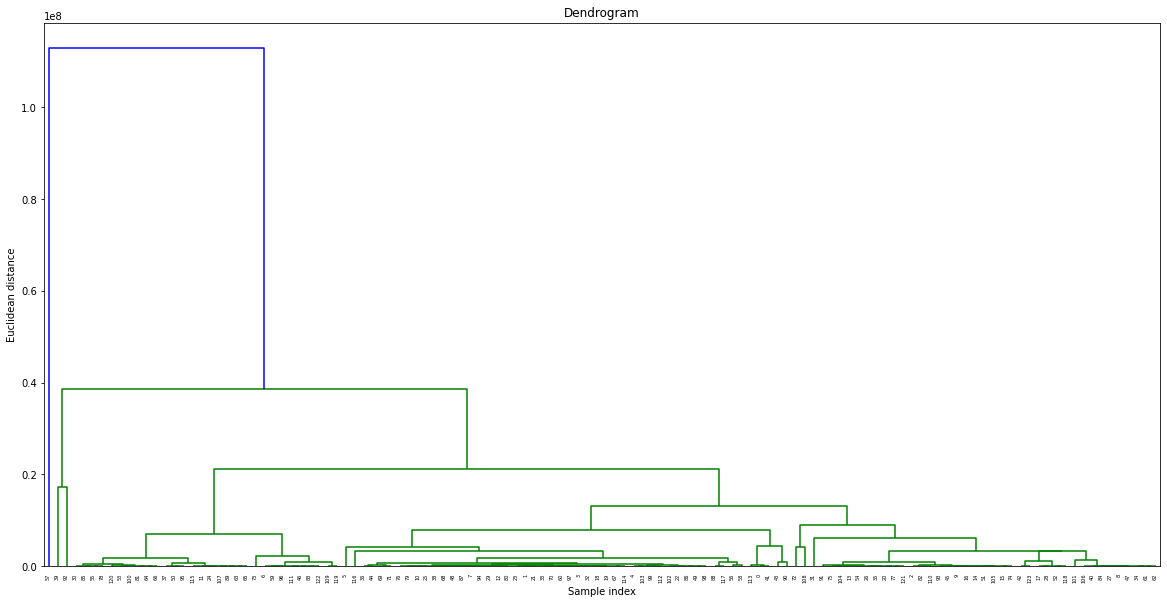

In [ ]:
# Plot the Dendrogram
plt.figure(figsize=(20, 10))

# Create the Dendrogram
sc.dendrogram(sc.linkage(modelingData, method = "complete"))  
plt.title("Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Euclidean distance")

In [ ]:
hier_1 = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "complete")
hier_1.fit_predict(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_1.labels_))
print("Predicted Number of Graduates: ", len(hier_1.labels_) - np.sum(hier_1.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_1.labels_ - modelingData_y)))

hier_1.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_1.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_1.labels_))
print("Precision: ", precision_score(modelingData_y, hier_1.labels_))
print("Recall: ", recall_score(modelingData_y, hier_1.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_1.labels_))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #2

##### Full, Unscaled

Text(0, 0.5, 'Euclidean distance')

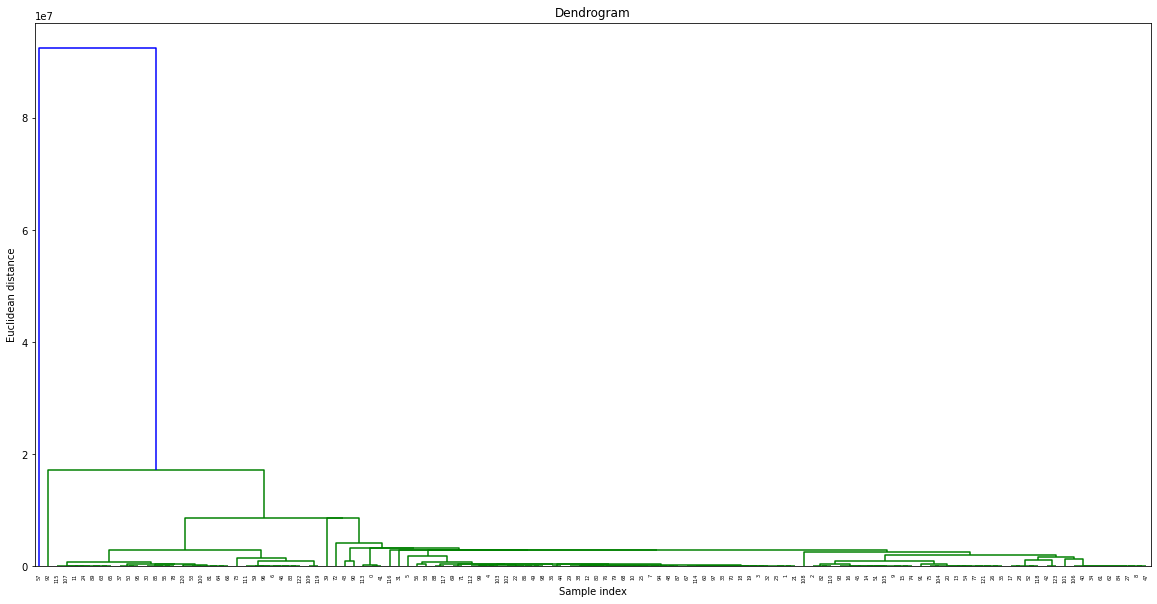

In [ ]:
# Plot the Dendrogram
plt.figure(figsize=(20, 10))

# Create the Dendrogram
sc.dendrogram(sc.linkage(modelingData, method = "single"))
plt.title("Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Euclidean distance")

In [ ]:
hier_2 = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "single")
hier_2.fit_predict(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_2.labels_))
print("Predicted Number of Graduates: ", len(hier_2.labels_) - np.sum(hier_2.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_2.labels_ - modelingData_y)))

hier_2.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_2.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_2.labels_))
print("Precision: ", precision_score(modelingData_y, hier_2.labels_))
print("Recall: ", recall_score(modelingData_y, hier_2.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_2.labels_))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #3

##### Full, Unscaled

Text(0, 0.5, 'Euclidean distance')

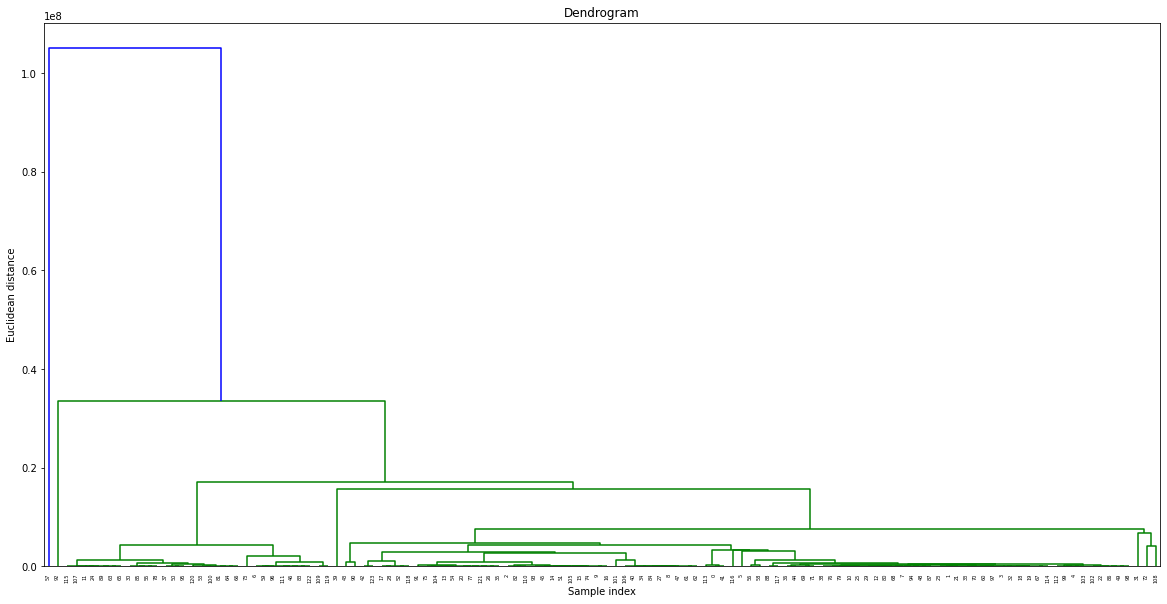

In [ ]:
# Plot the Dendrogram
plt.figure(figsize=(20, 10))

# Create the Dendrogram
sc.dendrogram(sc.linkage(modelingData, method = "average"))
plt.title("Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Euclidean distance")

In [ ]:
hier_3 = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "average")
hier_3.fit_predict(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_3.labels_))
print("Predicted Number of Graduates: ", len(hier_3.labels_) - np.sum(hier_3.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_3.labels_ - modelingData_y)))

hier_3.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_3.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_3.labels_))
print("Precision: ", precision_score(modelingData_y, hier_3.labels_))
print("Recall: ", recall_score(modelingData_y, hier_3.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_3.labels_))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #4

##### Full, Scaled

Text(0, 0.5, 'Euclidean distance')

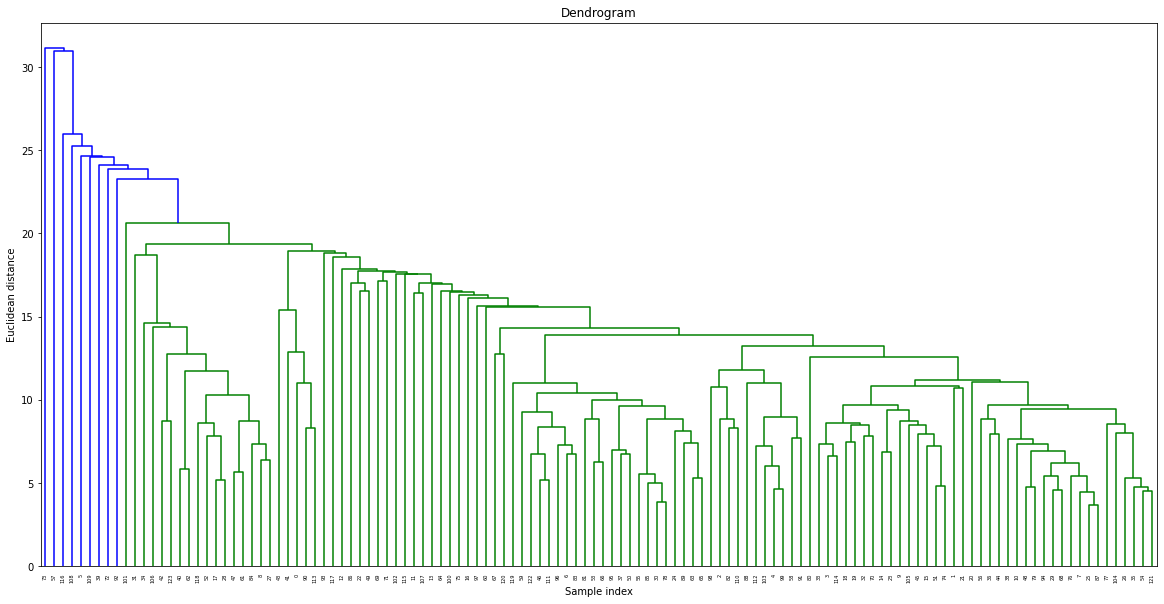

In [ ]:
# Plot the Dendrogram
plt.figure(figsize=(20, 10))

# Create the Dendrogram
sc.dendrogram(sc.linkage(modelingData_scaled, method = "average"))  
plt.title("Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Euclidean distance")

In [ ]:
hier_4 = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "average")
hier_4.fit_predict(modelingData_scaled)
print("Predicted Number of Dropouts: ", np.sum(hier_4.labels_))
print("Predicted Number of Graduates: ", len(hier_4.labels_) - np.sum(hier_4.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_4.labels_ - modelingData_y)))

hier_4.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  54


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_4.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_4.labels_))
print("Precision: ", precision_score(modelingData_y, hier_4.labels_))
print("Recall: ", recall_score(modelingData_y, hier_4.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_4.labels_))

Area Under the Curve:  0.509090909090909
Accuracy_Score:  0.5645161290322581
Precision:  1.0
Recall:  0.01818181818181818

 Confusion Matrix: 
  [[69  0]
 [54  1]]


#### Attempt #5

##### Just Predictors, Unscaled

Text(0, 0.5, 'Euclidean distance')

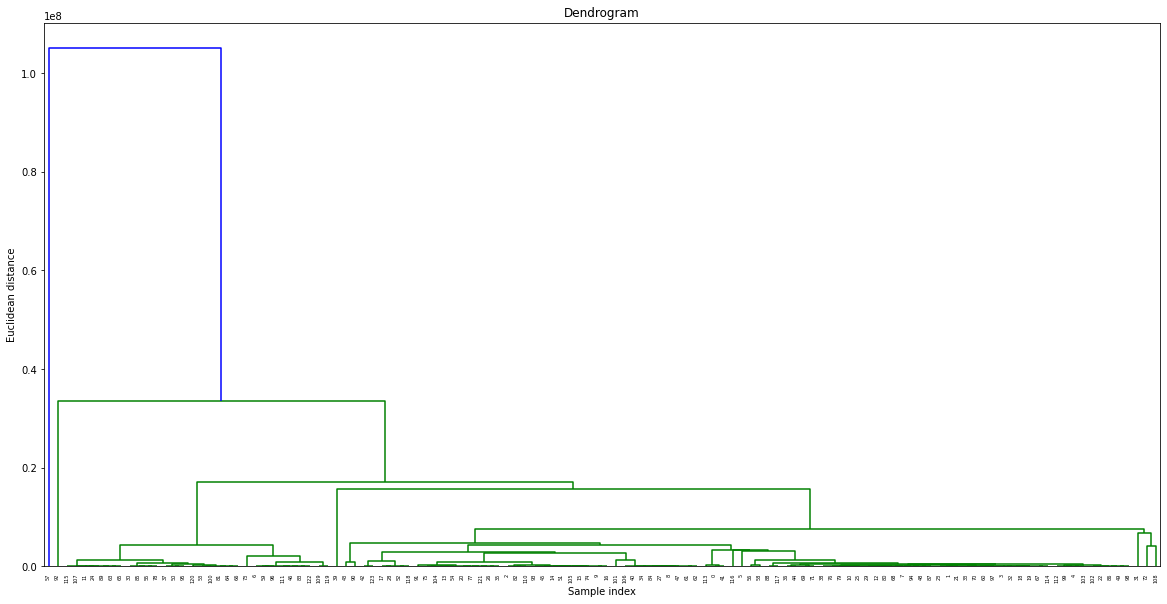

In [ ]:
# Plot the Dendrogram
plt.figure(figsize=(20, 10))

# Create the Dendrogram
sc.dendrogram(sc.linkage(modelingData_X, method = "average"))  
plt.title("Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Euclidean distance")

In [ ]:
hier_5 = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "average")
hier_5.fit_predict(modelingData_X)
print("Predicted Number of Dropouts: ", np.sum(hier_5.labels_))
print("Predicted Number of Graduates: ", len(hier_5.labels_) - np.sum(hier_5.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_5.labels_ - modelingData_y)))

hier_5.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_5.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_5.labels_))
print("Precision: ", precision_score(modelingData_y, hier_5.labels_))
print("Recall: ", recall_score(modelingData_y, hier_5.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_5.labels_))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #6

##### Just Predictors, Scaled

Text(0, 0.5, 'Euclidean distance')

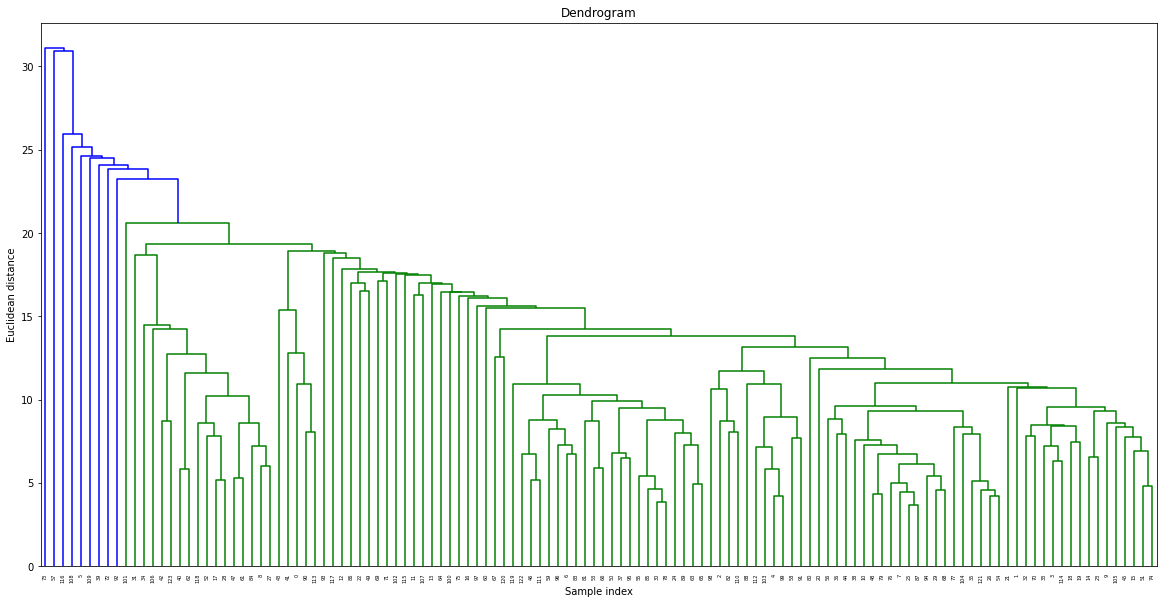

In [ ]:
# Plot the Dendrogram
plt.figure(figsize=(20, 10))

# Create the Dendrogram
sc.dendrogram(sc.linkage(modelingData_X_scaled, method = "average"))  
plt.title("Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Euclidean distance")

In [ ]:
hier_6 = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "average")
hier_6.fit_predict(modelingData_X_scaled)
print("Predicted Number of Dropouts: ", np.sum(hier_6.labels_))
print("Predicted Number of Graduates: ", len(hier_6.labels_) - np.sum(hier_6.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_6.labels_ - modelingData_y)))

hier_6.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  54


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_6.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_6.labels_))
print("Precision: ", precision_score(modelingData_y, hier_6.labels_))
print("Recall: ", recall_score(modelingData_y, hier_6.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_6.labels_))

Area Under the Curve:  0.509090909090909
Accuracy_Score:  0.5645161290322581
Precision:  1.0
Recall:  0.01818181818181818

 Confusion Matrix: 
  [[69  0]
 [54  1]]


#### Attempt #7

##### Full, Unscaled

In [ ]:
hier_7 = AgglomerativeClustering(n_clusters = 2, affinity = "l1", linkage = "average")
hier_7.fit_predict(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_7.labels_))
print("Predicted Number of Graduates: ", len(hier_7.labels_) - np.sum(hier_7.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_7.labels_ - modelingData_y)))

hier_7.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_7.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_7.labels_))
print("Precision: ", precision_score(modelingData_y, hier_7.labels_))
print("Recall: ", recall_score(modelingData_y, hier_7.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_7.labels_))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #8

##### Full, Unscaled

In [ ]:
hier_8 = AgglomerativeClustering(n_clusters = 2, affinity = "l1", linkage = "single")
hier_8.fit_predict(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_8.labels_))
print("Predicted Number of Graduates: ", len(hier_8.labels_) - np.sum(hier_8.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_8.labels_ - modelingData_y)))

hier_8.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_8.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_8.labels_))
print("Precision: ", precision_score(modelingData_y, hier_8.labels_))
print("Recall: ", recall_score(modelingData_y, hier_8.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_8.labels_))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #9

##### Full, Unscaled

In [ ]:
hier_9 = AgglomerativeClustering(n_clusters = 2, affinity = "l1", linkage = "complete")
hier_9.fit_predict(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_9.labels_))
print("Predicted Number of Graduates: ", len(hier_9.labels_) - np.sum(hier_9.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_9.labels_ - modelingData_y)))

hier_9.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_9.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_9.labels_))
print("Precision: ", precision_score(modelingData_y, hier_9.labels_))
print("Recall: ", recall_score(modelingData_y, hier_9.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_9.labels_))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #10

##### Full, Unscaled

In [ ]:
hier_10 = AgglomerativeClustering(n_clusters = 2, affinity = "l2", linkage = "average")
hier_10.fit(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_10.labels_))
print("Predicted Number of Graduates: ", len(hier_10.labels_) - np.sum(hier_10.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_10.labels_ - modelingData_y)))

hier_10.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_10.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_10.labels_))
print("Precision: ", precision_score(modelingData_y, hier_10.labels_))
print("Recall: ", recall_score(modelingData_y, hier_10.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_10.labels_))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #11

##### Full, Unscaled

In [ ]:
hier_11 = AgglomerativeClustering(n_clusters = 2, affinity = "manhattan", linkage = "average")
hier_11.fit(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_11.labels_))
print("Predicted Number of Graduates: ", len(hier_11.labels_) - np.sum(hier_11.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_11.labels_ - modelingData_y)))

hier_11.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_11.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_11.labels_))
print("Precision: ", precision_score(modelingData_y, hier_11.labels_))
print("Recall: ", recall_score(modelingData_y, hier_11.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_11.labels_))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #12

##### Full, Unscaled

In [ ]:
hier_12 = AgglomerativeClustering(n_clusters = 2, affinity = "cosine", linkage = "average")
hier_12.fit(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_12.labels_))
print("Predicted Number of Graduates: ", len(hier_12.labels_) - np.sum(hier_12.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_12.labels_ - modelingData_y)))

hier_12.labels_

Predicted Number of Dropouts:  33
Predicted Number of Graduates:  91
Number of Incorrect Predictions:  54


array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_12.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_12.labels_))
print("Precision: ", precision_score(modelingData_y, hier_12.labels_))
print("Recall: ", recall_score(modelingData_y, hier_12.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_12.labels_))

Area Under the Curve:  0.5386034255599472
Accuracy_Score:  0.5645161290322581
Precision:  0.5151515151515151
Recall:  0.3090909090909091

 Confusion Matrix: 
  [[53 16]
 [38 17]]


#### <font color=limegreen>Attempt #13</font>

##### Full, Scaled

In [ ]:
hier_13 = AgglomerativeClustering(n_clusters = 2, affinity = "cosine", linkage = "average")
hier_13.fit(modelingData_scaled)
print("Predicted Number of Dropouts: ", np.sum(hier_13.labels_))
print("Predicted Number of Graduates: ", len(hier_13.labels_) - np.sum(hier_13.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_13.labels_ - modelingData_y)))

hier_13.labels_

Predicted Number of Dropouts:  45
Predicted Number of Graduates:  79
Number of Incorrect Predictions:  54


array([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_13.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_13.labels_))
print("Precision: ", precision_score(modelingData_y, hier_13.labels_))
print("Recall: ", recall_score(modelingData_y, hier_13.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_13.labels_))

Area Under the Curve:  0.5496706192358367
Accuracy_Score:  0.5645161290322581
Precision:  0.5111111111111111
Recall:  0.41818181818181815

 Confusion Matrix: 
  [[47 22]
 [32 23]]


#### Attempt #14

##### Full, Unscaled

In [ ]:
hier_14 = AgglomerativeClustering(n_clusters = 2, affinity = "cosine", linkage = "single")
hier_14.fit(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_14.labels_))
print("Predicted Number of Graduates: ", len(hier_14.labels_) - np.sum(hier_14.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_14.labels_ - modelingData_y)))

hier_14.labels_

Predicted Number of Dropouts:  7
Predicted Number of Graduates:  117
Number of Incorrect Predictions:  50


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_14.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_14.labels_))
print("Precision: ", precision_score(modelingData_y, hier_14.labels_))
print("Recall: ", recall_score(modelingData_y, hier_14.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_14.labels_))

Area Under the Curve:  0.5472990777338603
Accuracy_Score:  0.5967741935483871
Precision:  0.8571428571428571
Recall:  0.10909090909090909

 Confusion Matrix: 
  [[68  1]
 [49  6]]


#### Attempt #15

##### Full, Scaled

In [ ]:
hier_15 = AgglomerativeClustering(n_clusters = 2, affinity = "cosine", linkage = "single")
hier_15.fit(modelingData_scaled)
print("Predicted Number of Dropouts: ", np.sum(hier_15.labels_))
print("Predicted Number of Graduates: ", len(hier_15.labels_) - np.sum(hier_15.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_15.labels_ - modelingData_y)))

hier_15.labels_

Predicted Number of Dropouts:  1
Predicted Number of Graduates:  123
Number of Incorrect Predictions:  56


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_15.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_15.labels_))
print("Precision: ", precision_score(modelingData_y, hier_15.labels_))
print("Recall: ", recall_score(modelingData_y, hier_15.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_15.labels_))

Area Under the Curve:  0.4927536231884058
Accuracy_Score:  0.5483870967741935
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[68  1]
 [55  0]]


#### Attempt #16

##### Full, Unscaled

In [ ]:
hier_16 = AgglomerativeClustering(n_clusters = 2, affinity = "cosine", linkage = "complete")
hier_16.fit(modelingData)
print("Predicted Number of Dropouts: ", np.sum(hier_16.labels_))
print("Predicted Number of Graduates: ", len(hier_16.labels_) - np.sum(hier_16.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_16.labels_ - modelingData_y)))

hier_16.labels_

Predicted Number of Dropouts:  36
Predicted Number of Graduates:  88
Number of Incorrect Predictions:  55


array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_16.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_16.labels_))
print("Precision: ", precision_score(modelingData_y, hier_16.labels_))
print("Recall: ", recall_score(modelingData_y, hier_16.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_16.labels_))

Area Under the Curve:  0.5332015810276679
Accuracy_Score:  0.5564516129032258
Precision:  0.5
Recall:  0.32727272727272727

 Confusion Matrix: 
  [[51 18]
 [37 18]]


#### Attempt #17

##### Full, Scaled

In [ ]:
hier_17 = AgglomerativeClustering(n_clusters = 2, affinity = "cosine", linkage = "complete")
hier_17.fit(modelingData_scaled)
print("Predicted Number of Dropouts: ", np.sum(hier_17.labels_))
print("Predicted Number of Graduates: ", len(hier_17.labels_) - np.sum(hier_17.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_17.labels_ - modelingData_y)))

hier_17.labels_

Predicted Number of Dropouts:  45
Predicted Number of Graduates:  79
Number of Incorrect Predictions:  54


array([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_17.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_17.labels_))
print("Precision: ", precision_score(modelingData_y, hier_17.labels_))
print("Recall: ", recall_score(modelingData_y, hier_17.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_17.labels_))

Area Under the Curve:  0.5496706192358367
Accuracy_Score:  0.5645161290322581
Precision:  0.5111111111111111
Recall:  0.41818181818181815

 Confusion Matrix: 
  [[47 22]
 [32 23]]


#### Attempt #18

##### Just Predictors, Scaled

In [ ]:
hier_18 = AgglomerativeClustering(n_clusters = 2, affinity = "cosine", linkage = "complete")
hier_18.fit(modelingData_X_scaled)
print("Predicted Number of Dropouts: ", np.sum(hier_18.labels_))
print("Predicted Number of Graduates: ", len(hier_18.labels_) - np.sum(hier_18.labels_))
print("Number of Incorrect Predictions: ", np.sum(abs(hier_18.labels_ - modelingData_y)))

hier_18.labels_

Predicted Number of Dropouts:  45
Predicted Number of Graduates:  79
Number of Incorrect Predictions:  54


array([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, hier_18.labels_))
print("Accuracy_Score: ", accuracy_score(modelingData_y, hier_18.labels_))
print("Precision: ", precision_score(modelingData_y, hier_18.labels_))
print("Recall: ", recall_score(modelingData_y, hier_18.labels_))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, hier_18.labels_))

Area Under the Curve:  0.5496706192358367
Accuracy_Score:  0.5645161290322581
Precision:  0.5111111111111111
Recall:  0.41818181818181815

 Confusion Matrix: 
  [[47 22]
 [32 23]]


#### Results

In [ ]:
best_hierarch = hier_13.labels_

hierarchOutliers_df = modelingData.copy()
hierarchOutliers_df["hierarchValue"] = best_hierarch
hierarchOutliers_df

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated,hierarchValue
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,1,11,...,0.0,0.0,1.0,0.0,1.0,0.0,1.527317,2.651641,1,1
1,1,1,0,0,0,0,0,0,2,11,...,0.0,0.0,0.0,0.0,1.0,0.0,3.227670,27.026511,0,0
2,0,1,0,0,0,0,0,0,3,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.803466,5.922479,1,1
3,0,0,0,1,0,0,0,0,1,13,...,0.0,0.0,1.0,0.0,1.0,0.0,1.287508,20.718053,1,0
4,1,1,0,0,0,0,0,0,3,11,...,0.0,1.0,1.0,0.0,1.0,0.0,4.410934,2.378576,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,1,0,0,0,0,0,0,1,13,...,0.0,1.0,1.0,1.0,1.0,0.0,19.355286,20.589324,1,0
120,1,0,0,0,1,0,0,0,1,13,...,0.0,1.0,1.0,0.0,1.0,0.0,22.010710,161.404493,1,0
121,0,1,0,0,0,0,0,0,1,11,...,0.0,1.0,1.0,1.0,1.0,0.0,2.954628,18.060702,0,0


In [ ]:
threshold = round(0.2 * len(hierarchOutliers_df))
print("20% of the Outliers Is Equivalent to " + str(threshold) + " students.")

20% of the Outliers Is Equivalent to 25 students.


In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, best_hierarch))
print("Accuracy_Score: ", accuracy_score(modelingData_y, best_hierarch))
print("Precision: ", precision_score(modelingData_y, best_hierarch))
print("Recall: ", recall_score(modelingData_y, best_hierarch))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, best_hierarch))

Area Under the Curve:  0.5496706192358367
Accuracy_Score:  0.5645161290322581
Precision:  0.5111111111111111
Recall:  0.41818181818181815

 Confusion Matrix: 
  [[47 22]
 [32 23]]


In [ ]:
assessCategoricalPredictors(hierarchOutliers_df, categoricals, "hierarchValue")

hierarchValue  Gender
0              1         46
               0         33
1              1         23
               0         22
Name: Gender, dtype: int64 

hierarchValue  Hispanic
0              0           40
               1           39
1              0           31
               1           14
Name: Hispanic, dtype: int64 

hierarchValue  Asian
0              0        57
               1        22
1              0        45
Name: Asian, dtype: int64 

hierarchValue  Black
0              0        64
               1        15
1              1        31
               0        14
Name: Black, dtype: int64 

hierarchValue  White
0              0        65
               1        14
1              0        40
               1         5
Name: White, dtype: int64 

hierarchValue  Hawaiian
0              0           79
1              0           44
               1            1
Name: Hawaiian, dtype: int64 

hierarchValue  Multinational
0              0                68
         

In [ ]:
assessCategoricalPredictors(hierarchOutliers_df, studentZIPs, "hierarchValue")

hierarchValue  Std_07011
0              0.0          79
1              0.0          45
Name: Std_07011, dtype: int64 

hierarchValue  Std_07026
0              0.0          78
               1.0           1
1              0.0          45
Name: Std_07026, dtype: int64 

hierarchValue  Std_07103
0              0.0          79
1              0.0          40
               1.0           5
Name: Std_07103, dtype: int64 

hierarchValue  Std_07104
0              0.0          79
1              0.0          44
               1.0           1
Name: Std_07104, dtype: int64 

hierarchValue  Std_07105
0              0.0          79
1              0.0          44
               1.0           1
Name: Std_07105, dtype: int64 

hierarchValue  Std_07106
0              0.0          79
1              0.0          45
Name: Std_07106, dtype: int64 

hierarchValue  Std_07107
0              0.0          79
1              0.0          44
               1.0           1
Name: Std_07107, dtype: int64 

hierarchValu

In [ ]:
assessCategoricalPredictors(hierarchOutliers_df, HSZIPs, "hierarchValue")

hierarchValue  HS_07103
0              0.0         79
1              0.0         44
               1.0          1
Name: HS_07103, dtype: int64 

hierarchValue  HS_07104
0              0.0         79
1              0.0         44
               1.0          1
Name: HS_07104, dtype: int64 

hierarchValue  HS_07105
0              0.0         49
               1.0         30
1              0.0         45
Name: HS_07105, dtype: int64 

hierarchValue  HS_07108
0              0.0         79
1              0.0         27
               1.0         18
Name: HS_07108, dtype: int64 

hierarchValue  HS_07470
0              0.0         78
               1.0          1
1              0.0         45
Name: HS_07470, dtype: int64 

hierarchValue  HS_07501
0              0.0         79
1              0.0         43
               1.0          2
Name: HS_07501, dtype: int64 

hierarchValue  HS_07502
0              1.0         48
               0.0         31
1              0.0         45
Name: HS_07502, 

In [ ]:
assessCategoricalPredictors(hierarchOutliers_df, highSchools, "hierarchValue")

hierarchValue  Barringer High School
0              0.0                      79
1              0.0                      44
               1.0                       1
Name: Barringer High School, dtype: int64 

hierarchValue  East Side High School
0              0.0                      49
               1.0                      30
1              0.0                      45
Name: East Side High School, dtype: int64 

hierarchValue  Eastside High School
0              0.0                     79
1              0.0                     44
               1.0                      1
Name: Eastside High School, dtype: int64 

hierarchValue  John F. Kennedy High School
0              1.0                            48
               0.0                            31
1              0.0                            45
Name: John F. Kennedy High School, dtype: int64 

hierarchValue  Malcolm X Shabazz High School
0              0.0                              79
1              0.0                     

In [ ]:
assessCategoricalPredictors(hierarchOutliers_df, collegesList, "hierarchValue")

hierarchValue  ALTIERUS CAREER EDUCATION
0              0.0                          79
1              0.0                          43
               1.0                           2
Name: ALTIERUS CAREER EDUCATION, dtype: int64 

hierarchValue  BERKELEY COLLEGE
0              0.0                 79
1              0.0                 43
               1.0                  2
Name: BERKELEY COLLEGE, dtype: int64 

hierarchValue  BLOOMFIELD COLLEGE
0              0.0                   79
1              0.0                   42
               1.0                    3
Name: BLOOMFIELD COLLEGE, dtype: int64 

hierarchValue  CENTRAL CONNECTICUT STATE UNIV
0              0.0                               79
1              0.0                               44
               1.0                                1
Name: CENTRAL CONNECTICUT STATE UNIV, dtype: int64 

hierarchValue  COLLEGE OF NEW JERSEY (THE)
0              0.0                            74
               1.0                         

<font color=mediumorchid>The results show:
- Students who are both low income and first generation are more likely to graduate college
- Students from predominately low income communities are more likely to graduate college
- Students with an interest in math and/or science are more likely to graduate college
- Students who first joined Upward Bound as a 9th or 10th grader are more likely to graduate college
- Students who only participate in Upward Bound during the academic year are more likely to graduate college
- Students who are inactive in Upward Bound during their senior year are more likely to graduate college
- Students who achieve proficiency in ELA are more likely to graduate college
- Students who achieve proficiency in math are more likely to graduate college
- Students who are unemployed in high schoool are more likely to graduate college
- Students who participate in cultural activities in high school are more likely to graduate college
- Students who take at least one Honors course are more likely to graduate college
- Students from high schools that are Title I are more likely to graduate college
- Students from high schools that are Title I school-wide are more likely to graduate college
- Students from high schools in areas of high personal crimes are more likely to graduate college
- Students from high schools in areas of high murder crimes are more likely to graduate college
- Students from high schools in areas of low rape crimes are more likely to graduate college
- Students from high schools in areas of high robbery crimes are more likely to graduate college
- Students from high schools in areas of high assault crimes are more likely to graduate college
- Students from high schools in areas of high burglary crimes are more likely to graduate college
- Students from high schools in areas of low larceny crimes are more likely to graduate college
- Students from high schools in areas of high vehicle theft crimes are more likely to graduate college
- Students who live in areas of high personal crimes are more likely to graduate college
- Students who live in areas of high murder crimes are more likely to graduate college
- Students who live in areas of low rape crimes are more likely to graduate college
- Students who live in areas of high robbery crimes are more likely to graduate college
- Students who live in areas of high burglary crimes are more likely to graduate college
- Students who live in areas of low larceny crimes are more likely to graduate college
- Students who live in areas of high vehicle theft crimes are more likely to graduate college</font>

In [ ]:
# Create a DataFrame of the Outliers with Only the Continuous Predictiors and PS_Graduated
hierarchOutliers_continuous = hierarchOutliers_df.drop(categoricals, axis=1)
hierarchOutliers_continuous.drop(studentZIPs, axis=1, inplace=True)
hierarchOutliers_continuous.drop(HSZIPs, axis=1, inplace=True)
hierarchOutliers_continuous.drop(highSchools, axis=1, inplace=True)
hierarchOutliers_continuous.drop(collegesList, axis=1, inplace=True)
hierarchOutliers_continuous

,GPA,HSGrad_Age,Absences,SAT_Reading,SAT_Math,SAT_Writing,StudentTeacherRatio,NumFreeLunch,NumReducedLunch,%_Female,...,Student_PropertyCrimesIndex_2020,Student_BurglariesIndex_2020,Student_LarceniesIndex_2020,Student_VehicleTheftsIndex_2020,Student_AreaPopulation_2020,Student_Area,Distance_to_HS,Distance_to_PS,PS_Graduated,hierarchValue
ID,,,,,,,,,,,,,,,,,,,,,
0,3.370,6564,7,520,610,470,11.90,111.00,0.0,37.500,...,95.0,175.0,65.0,169.0,21038.0,3816374.384,1.527317,2.651641,1,1
1,2.710,6769,1,420,477,434,13.45,310.75,0.0,44.625,...,120.0,188.0,91.0,208.0,12392.0,3769562.775,3.227670,27.026511,0,0
2,2.440,6474,7,420,490,410,8.50,120.00,14.0,69.000,...,120.0,177.0,99.0,179.0,34962.0,7265109.163,1.803466,5.922479,1,1
3,3.446,6633,3,460,490,490,13.45,310.75,0.0,44.625,...,95.0,175.0,65.0,169.0,21038.0,3816374.384,1.287508,20.718053,1,0
4,3.760,6522,9,420,477,434,8.50,120.00,14.0,69.000,...,66.0,112.0,44.0,140.0,15052.0,4034220.467,4.410934,2.378576,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2.061,7138,10,420,477,434,13.60,1307.00,222.0,45.000,...,78.0,99.0,65.0,136.0,19067.0,8120610.007,19.355286,20.589324,1,0
120,3.105,6668,1,400,450,340,13.60,1307.00,222.0,45.000,...,66.0,112.0,44.0,140.0,15052.0,4034220.467,22.010710,161.404493,1,0
121,4.550,6553,7,490,600,480,13.45,310.75,0.0,44.625,...,78.0,99.0,65.0,136.0,19067.0,8120610.007,2.954628,18.060702,0,0


##### Check If Dropout Value Is 20% Above or 20% Below the Graduate Value

In [ ]:
hierarchOutliers_groupedContinuous = hierarchOutliers_continuous.groupby("hierarchValue").agg("mean")

In [ ]:
# First Third of the Predictors
hierarchOutliers_groupedContinuous.iloc[:, :16]

,GPA,HSGrad_Age,Absences,SAT_Reading,SAT_Math,SAT_Writing,StudentTeacherRatio,NumFreeLunch,NumReducedLunch,%_Female,%_Male,%_EconomDisadv,%_w/Disabilities,%_ELL,%_Homeless,%_FosterCare
hierarchValue,,,,,,,,,,,,,,,,
0,3.518882,6633.430380,9.594937,430.632911,487.000000,438.354430,13.487342,706.189873,88.151899,44.911392,55.088608,69.874684,16.431646,28.630380,0.760759,0.151899
1,3.224596,6622.311111,8.888889,428.888889,468.066667,432.577778,9.965185,191.644444,13.725926,54.459259,45.540741,64.684444,19.273333,4.758519,1.085926,0.597037


In [ ]:
hierarchOutliers_groupedContinuous.iloc[:, :16].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

GPA                    0
HSGrad_Age             0
Absences               0
SAT_Reading            0
SAT_Math               0
SAT_Writing            0
StudentTeacherRatio    1
NumFreeLunch           1
NumReducedLunch        1
%_Female               1
%_Male                 0
%_EconomDisadv         0
%_w/Disabilities       0
%_ELL                  1
%_Homeless             1
%_FosterCare           1
dtype: int64

In [ ]:
# Middle Third of the Predictors
hierarchOutliers_groupedContinuous.iloc[:, 16:32]

,%_White,%_Hispanic,%_Black,%_Asian,HS_CrimesIndex_2020,HS_PersonalCrimesIndex_2020,HS_MurdersIndex_2020,HS_RapesIndex_2020,HS_RobberiesIndex_2020,HS_AssaultsIndex_2020,HS_PropertyCrimesIndex_2020,HS_BurglariesIndex_2020,HS_LarceniesIndex_2020,HS_VehicleTheftsIndex_2020,HS_AreaPopulation_2020,HS_Area
hierarchValue,,,,,,,,,,,,,,,,
0,14.637975,62.581013,15.312658,7.411392,71.949367,95.151899,121.721519,58.670886,179.341772,67.278481,68.417722,85.582278,51.075949,161.037975,28388.949367,1.194081e+07
1,0.817778,42.008889,56.569630,0.647407,127.844444,251.511111,509.977778,106.644444,464.777778,185.844444,108.044444,142.133333,78.800000,263.044444,21518.177778,5.196528e+06


In [ ]:
hierarchOutliers_groupedContinuous.iloc[:, 16:32].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

%_White                        1
%_Hispanic                     1
%_Black                        1
%_Asian                        1
HS_CrimesIndex_2020            1
HS_PersonalCrimesIndex_2020    1
HS_MurdersIndex_2020           1
HS_RapesIndex_2020             1
HS_RobberiesIndex_2020         1
HS_AssaultsIndex_2020          1
HS_PropertyCrimesIndex_2020    1
HS_BurglariesIndex_2020        1
HS_LarceniesIndex_2020         1
HS_VehicleTheftsIndex_2020     1
HS_AreaPopulation_2020         1
HS_Area                        1
dtype: int64

In [ ]:
# Final Third of the Predictors
hierarchOutliers_groupedContinuous.iloc[:, 32:-1]

,Student_CrimesIndex_2020,Student_PersonalCrimesIndex_2020,Student_MurdersIndex_2020,Student_RapesIndex_2020,Student_RobberiesIndex_2020,Student_AssaultsIndex_2020,Student_PropertyCrimesIndex_2020,Student_BurglariesIndex_2020,Student_LarceniesIndex_2020,Student_VehicleTheftsIndex_2020,Student_AreaPopulation_2020,Student_Area,Distance_to_HS,Distance_to_PS
hierarchValue,,,,,,,,,,,,,,
0,107.189873,189.126582,229.417722,70.911392,361.708861,139.367089,93.746835,144.759494,71.64557,164.139241,20345.898734,5.084718e+06,9.010984,129.942759
1,121.022222,235.133333,469.377778,98.111111,439.488889,172.111111,102.555556,138.000000,73.20000,257.666667,24215.755556,7.159195e+06,1.740850,153.604513


In [ ]:
hierarchOutliers_groupedContinuous.iloc[:, 32:-1].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

Student_CrimesIndex_2020            0
Student_PersonalCrimesIndex_2020    1
Student_MurdersIndex_2020           1
Student_RapesIndex_2020             1
Student_RobberiesIndex_2020         1
Student_AssaultsIndex_2020          1
Student_PropertyCrimesIndex_2020    0
Student_BurglariesIndex_2020        0
Student_LarceniesIndex_2020         0
Student_VehicleTheftsIndex_2020     1
Student_AreaPopulation_2020         0
Student_Area                        1
Distance_to_HS                      1
Distance_to_PS                      0
dtype: int64

<font color=royalblue>The results show:
- Students from high schools with a larger proportion of students in Foster Care are more likely to drop out of college
- Students from high schools with a larger proportion of African American/Black students are more likely to drop out of college
- Students from high schools in areas with higher crime rates are more likely to drop out of college
- Students from high schools in areas with higher personal crime rates are more likely to drop out of college
- Students from high schools in areas with higher murder crime rates are more likely to drop out of college
- Students from high schools in areas with higher robbery crime rates are more likely to drop out of college
- Students from high schools in areas with higher assault crime rates are more likely to drop out of college
- Students from high schools in areas with higher property crime rates are more likely to drop out of college
- Students from high schools in areas with higher burglary crime rates are more likely to drop out of college
- Students from high schools in areas with higher larceny crime rates are more likely to drop out of college    
- Students from high schools in areas with higher vehicle theft crime rates are more likely to drop out of college   
- Students who live in larger areas are more likely to drop out of college</font>


<font color=mediumorchid>The results show:
- Students from high schools with a larger population of Free Lunch students are more likely to graduate college
- Students from high schools with a larger population of Reduced Lunch students are more likely to graduate college
- Students from high schools with a larger proportion of ELL students are more likely to graduate college
- Students from high schools with a larger proportion of White students are more likely to graduate college
- Students from high schools with a larger proportion of Asian students are more likely to graduate college
- Students from high schools in more populous areas are more likely to graduate college
- Students from high schools in larger areas are more likely to graduate college
- Students who live in areas with higher personal crime rates are more likely to graduate college
- Students who live in areas with higher murder crime rates are more likely to graduate college
- Students who live in areas with higher robbery crime rates are more likely to graduate college
- Students who attend high school farther away from home are more likely to graduate college</font>

### Gaussian Mixture Models

<font color=red>Obvious Difference Between Scaled and Unscaled; more diverse with scaled<br> $\therefore$ Use Scaled Data</font>

In [ ]:
GMMOutliers = set()

#### Attempt #1

##### Full, Unscaled

In [ ]:
# Train Gaussian Mixture Models with Various Values of 𝑘 and Measure Their AIC & BIC
GMMs_per_k1 = [GaussianMixture(n_components = k, n_init = 10, random_state = 42, reg_covar = 1e-3).fit(modelingData)
                  for k in range(1, 11)] # 1 to 10 clusters

bics1 = [model.bic(modelingData) for model in GMMs_per_k1]
aics1 = [model.aic(modelingData) for model in GMMs_per_k1]

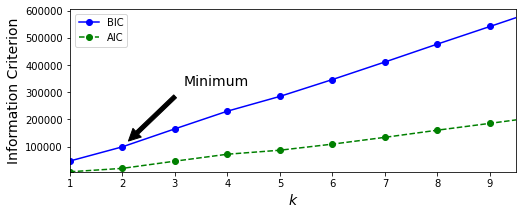

In [ ]:
#Graph the AIC & BIC Values 
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics1, "bo-", label="BIC")
plt.plot(range(1, 11), aics1, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics1) - 50, np.max(bics1) + 50])
plt.annotate('Minimum',
             xy=(2, bics1[1]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

In [ ]:
# Fit the GMM with 2 Clusters
GMM_1 = GaussianMixture(n_components = 2, n_init = 10, random_state = 42, reg_covar = 1e-4)
y_pred_GMM1 = GMM_1.fit_predict(modelingData)
print("Predicted Number of Dropouts: ", np.sum(y_pred_GMM1))
print("Predicted Number of Graduates: ", len(y_pred_GMM1) - np.sum(y_pred_GMM1))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_GMM1 - modelingData_y)))

y_pred_GMM1

Predicted Number of Dropouts:  31
Predicted Number of Graduates:  93
Number of Incorrect Predictions:  52


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_GMM1))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_GMM1))
print("Precision: ", precision_score(modelingData_y, y_pred_GMM1))
print("Recall: ", recall_score(modelingData_y, y_pred_GMM1))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_GMM1))

Area Under the Curve:  0.5530961791831357
Accuracy_Score:  0.5806451612903226
Precision:  0.5483870967741935
Recall:  0.3090909090909091

 Confusion Matrix: 
  [[55 14]
 [38 17]]


In [ ]:
# Identify the Outliers
densities1 = GMM_1.score_samples(modelingData)
density1_threshold = np.percentile(densities1, 33) # Research Shows One-Third of College Students Drop Out
anomalies1 = modelingData[densities1 < density1_threshold]
GMMOutliers.update(anomalies1.index.values)
anomalies1

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
2,0,1,0,0,0,0,0,0,3,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.803466,5.922479,1
5,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650735,1277.060391,0
9,0,1,0,0,0,0,0,1,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.252961,19.449132,1
12,0,0,1,0,0,0,0,1,1,1,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.771976,30.357090,0
13,1,0,0,0,1,0,0,1,1,7,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,3.474206,17.041089,0
16,0,0,1,0,0,0,0,0,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.051948,29.363966,0
20,0,0,1,0,0,0,0,1,2,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,3.009992,86.917957,0
21,1,0,1,0,0,0,0,1,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.922676,19.596591,0
22,0,0,0,1,0,0,0,0,1,10,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.708301,497.051898,1


#### <font color=limegreen>Attempt #2</font>

##### Full, Scaled

In [ ]:
# Train Gaussian Mixture Models with Various Values of 𝑘 and Measure Their AIC & BIC
GMMs_per_k2 = [GaussianMixture(n_components = k, n_init = 10, random_state = 42).fit(modelingData_scaled)
                  for k in range(1, 11)] # 1 to 10 clusters

bics2 = [model.bic(modelingData_scaled) for model in GMMs_per_k2]
aics2 = [model.aic(modelingData_scaled) for model in GMMs_per_k2]

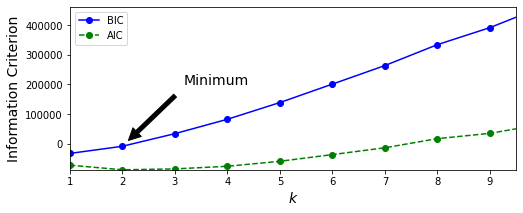

In [ ]:
#Graph the AIC & BIC Values 
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics2, "bo-", label="BIC")
plt.plot(range(1, 11), aics2, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics2) - 50, np.max(bics2) + 50])
plt.annotate('Minimum',
             xy=(2, bics2[1]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

In [ ]:
# Fit the GMM with 2 Clusters
GMM_2 = GaussianMixture(n_components = 2, n_init = 10, random_state = 42)
y_pred_GMM2 = GMM_2.fit_predict(modelingData_scaled)
print("Predicted Number of Dropouts: ", np.sum(y_pred_GMM2))
print("Predicted Number of Graduates: ", len(y_pred_GMM2) - np.sum(y_pred_GMM2))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_GMM2 - modelingData_y)))

y_pred_GMM2

Predicted Number of Dropouts:  68
Predicted Number of Graduates:  56
Number of Incorrect Predictions:  47


array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_GMM2))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_GMM2))
print("Precision: ", precision_score(modelingData_y, y_pred_GMM2))
print("Recall: ", recall_score(modelingData_y, y_pred_GMM2))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_GMM2))

Area Under the Curve:  0.6280632411067194
Accuracy_Score:  0.6209677419354839
Precision:  0.5588235294117647
Recall:  0.6909090909090909

 Confusion Matrix: 
  [[39 30]
 [17 38]]


In [ ]:
# Identify the Outliers
densities2 = GMM_2.score_samples(modelingData_scaled)
density2_threshold = np.percentile(densities2, 33) # Research Shows One-Third of College Students Drop Out
anomalies2 = modelingData[densities2 < density2_threshold]
GMMOutliers.update(anomalies2.index.values)
anomalies2

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.527317,2.651641,1
8,1,0,0,1,0,0,0,0,2,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.611439,3.422135,1
11,1,1,0,0,1,0,1,0,1,7,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,20.022856,10.614917,1
17,1,0,0,1,0,0,0,0,1,11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.423447,39.038531,0
22,0,0,0,1,0,0,0,0,1,10,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.708301,497.051898,1
27,0,0,0,0,0,0,0,0,2,11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.923336,39.873409,0
31,1,0,0,1,0,0,0,0,1,5,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.033103,775.667925,1
34,0,0,0,1,0,0,0,0,1,13,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.447086,161.734584,1
39,1,0,0,1,0,0,0,0,1,2,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4.602228,781.374872,1


#### Attempt #3

##### Just Predictors, Unscaled

In [ ]:
# Train Gaussian Mixture Models with Various Values of 𝑘 and Measure Their AIC & BIC
GMMs_per_k3 = [GaussianMixture(n_components = k, n_init = 10, random_state = 42, reg_covar = 1e-3).fit(modelingData_X)
                  for k in range(1, 11)] # 1 to 10 clusters

bics3 = [model.bic(modelingData_X) for model in GMMs_per_k3]
aics3 = [model.aic(modelingData_X) for model in GMMs_per_k3]

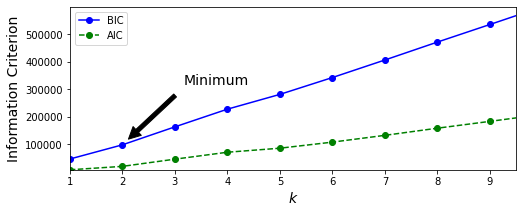

In [ ]:
#Graph the AIC & BIC Values 
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics3, "bo-", label="BIC")
plt.plot(range(1, 11), aics3, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics3) - 50, np.max(bics3) + 50])
plt.annotate('Minimum',
             xy=(2, bics3[1]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

In [ ]:
# Fit the GMM with 2 Clusters
GMM_3 = GaussianMixture(n_components = 2, n_init = 10, random_state = 42, reg_covar = 1e-4)
y_pred_GMM3 = GMM_3.fit_predict(modelingData_X)
print("Predicted Number of Dropouts: ", np.sum(y_pred_GMM3))
print("Predicted Number of Graduates: ", len(y_pred_GMM3) - np.sum(y_pred_GMM3))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_GMM3 - modelingData_y)))

y_pred_GMM3

Predicted Number of Dropouts:  31
Predicted Number of Graduates:  93
Number of Incorrect Predictions:  52


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_GMM3))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_GMM3))
print("Precision: ", precision_score(modelingData_y, y_pred_GMM3))
print("Recall: ", recall_score(modelingData_y, y_pred_GMM3))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_GMM3))

Area Under the Curve:  0.5530961791831357
Accuracy_Score:  0.5806451612903226
Precision:  0.5483870967741935
Recall:  0.3090909090909091

 Confusion Matrix: 
  [[55 14]
 [38 17]]


In [ ]:
# Identify the Outliers
densities3 = GMM_3.score_samples(modelingData_X)
density3_threshold = np.percentile(densities3, 33) # Research Shows One-Third of College Students Drop Out
anomalies3 = modelingData[densities3 < density3_threshold]
GMMOutliers.update(anomalies3.index.values)
anomalies3

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
2,0,1,0,0,0,0,0,0,3,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.803466,5.922479,1
5,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650735,1277.060391,0
9,0,1,0,0,0,0,0,1,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.252961,19.449132,1
12,0,0,1,0,0,0,0,1,1,1,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.771976,30.357090,0
13,1,0,0,0,1,0,0,1,1,7,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,3.474206,17.041089,0
16,0,0,1,0,0,0,0,0,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.051948,29.363966,0
20,0,0,1,0,0,0,0,1,2,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,3.009992,86.917957,0
21,1,0,1,0,0,0,0,1,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.922676,19.596591,0
22,0,0,0,1,0,0,0,0,1,10,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.708301,497.051898,1


#### Attempt #4

##### Just Predictors, Scaled

In [ ]:
# Train Gaussian Mixture Models with Various Values of 𝑘 and Measure Their AIC & BIC
GMMs_per_k4 = [GaussianMixture(n_components = k, n_init = 10, random_state = 42).fit(modelingData_X_scaled)
                  for k in range(1, 11)] # 1 to 10 clusters

bics4 = [model.bic(modelingData_X_scaled) for model in GMMs_per_k4]
aics4 = [model.aic(modelingData_X_scaled) for model in GMMs_per_k4]

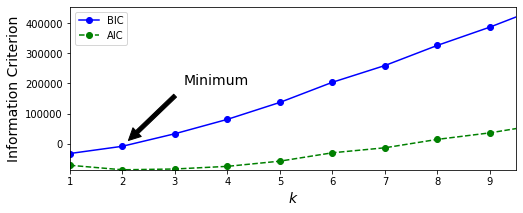

In [ ]:
#Graph the AIC & BIC Values 
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics4, "bo-", label="BIC")
plt.plot(range(1, 11), aics4, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics4) - 50, np.max(bics4) + 50])
plt.annotate('Minimum',
             xy=(2, bics4[1]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

In [ ]:
# Fit the GMM with 2 Clusters
GMM_4 = GaussianMixture(n_components = 2, n_init = 10, random_state = 42)
y_pred_GMM4 = GMM_4.fit_predict(modelingData_X_scaled)
print("Predicted Number of Dropouts: ", np.sum(y_pred_GMM4))
print("Predicted Number of Graduates: ", len(y_pred_GMM4) - np.sum(y_pred_GMM4))
print("Number of Incorrect Predictions: ", np.sum(abs(y_pred_GMM4 - modelingData_y)))

y_pred_GMM4

Predicted Number of Dropouts:  68
Predicted Number of Graduates:  56
Number of Incorrect Predictions:  47


array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, y_pred_GMM4))
print("Accuracy_Score: ", accuracy_score(modelingData_y, y_pred_GMM4))
print("Precision: ", precision_score(modelingData_y, y_pred_GMM4))
print("Recall: ", recall_score(modelingData_y, y_pred_GMM4))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, y_pred_GMM4))

Area Under the Curve:  0.6280632411067194
Accuracy_Score:  0.6209677419354839
Precision:  0.5588235294117647
Recall:  0.6909090909090909

 Confusion Matrix: 
  [[39 30]
 [17 38]]


In [ ]:
# Identify the Outliers
densities4 = GMM_4.score_samples(modelingData_X_scaled)
density4_threshold = np.percentile(densities4, 33) # Research Shows One-Third of College Students Drop Out
anomalies4 = modelingData[densities4 < density4_threshold]
GMMOutliers.update(anomalies4.index.values)
anomalies4

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.527317,2.651641,1
8,1,0,0,1,0,0,0,0,2,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.611439,3.422135,1
11,1,1,0,0,1,0,1,0,1,7,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,20.022856,10.614917,1
17,1,0,0,1,0,0,0,0,1,11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.423447,39.038531,0
22,0,0,0,1,0,0,0,0,1,10,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.708301,497.051898,1
27,0,0,0,0,0,0,0,0,2,11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.923336,39.873409,0
31,1,0,0,1,0,0,0,0,1,5,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.033103,775.667925,1
34,0,0,0,1,0,0,0,0,1,13,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.447086,161.734584,1
39,1,0,0,1,0,0,0,0,1,2,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4.602228,781.374872,1


#### Results A

In [ ]:
print("Number of Outliers: ", len(GMMOutliers))

Number of Outliers:  64


In [ ]:
GMMOutliers_df = modelingData.iloc[list(GMMOutliers)]
GMMOutliers_df

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RapesCateg,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,1,11,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.527317,2.651641,1
2,0,1,0,0,0,0,0,0,3,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.803466,5.922479,1
5,0,0,1,0,0,0,0,0,1,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650735,1277.060391,0
8,1,0,0,1,0,0,0,0,2,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.611439,3.422135,1
9,0,1,0,0,0,0,0,1,1,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.252961,19.449132,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,0,0,0,1,0,1,1,0,2,11,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.959701,4.243514,0
118,1,0,0,1,0,0,0,0,1,6,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.600865,5.799941,0
119,0,1,0,0,0,0,0,0,1,13,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,19.355286,20.589324,1


In [ ]:
print("Number of Dropouts: ", len(GMMOutliers_df[GMMOutliers_df.PS_Graduated == 1]))
print("Number of Graduates: ", len(GMMOutliers_df[GMMOutliers_df.PS_Graduated == 0]))

Number of Dropouts:  38
Number of Graduates:  26


In [ ]:
dropoutPercentage = computePercentage(len(GMMOutliers_df[GMMOutliers_df.PS_Graduated == 1]), "Dropouts")
graduatePercentage = computePercentage(len(GMMOutliers_df[GMMOutliers_df.PS_Graduated == 0]), "Graduates")

print("This Model Identified " + str(dropoutPercentage) + "% of the College Dropouts. \n")
print("This Model Also Identified " + str(graduatePercentage) + "% of the College Graduates.")

This Model Identified 69.09% of the College Dropouts. 

This Model Also Identified 37.68% of the College Graduates.


In [ ]:
threshold = round(0.2 * len(GMMOutliers_df))
print("20% of the Outliers Is Equivalent to " + str(threshold) + " students.")

20% of the Outliers Is Equivalent to 13 students.


In [ ]:
assessCategoricalPredictors(GMMOutliers_df, categoricals, "PS_Graduated")

PS_Graduated  Gender
0             1         14
              0         12
1             1         21
              0         17
Name: Gender, dtype: int64 

PS_Graduated  Hispanic
0             0           14
              1           12
1             0           23
              1           15
Name: Hispanic, dtype: int64 

PS_Graduated  Asian
0             0        21
              1         5
1             0        38
Name: Asian, dtype: int64 

PS_Graduated  Black
0             0        18
              1         8
1             1        23
              0        15
Name: Black, dtype: int64 

PS_Graduated  White
0             0        21
              1         5
1             0        34
              1         4
Name: White, dtype: int64 

PS_Graduated  Hawaiian
0             0           25
              1            1
1             0           38
Name: Hawaiian, dtype: int64 

PS_Graduated  Multinational
0             0                20
              1                 6
1    

In [ ]:
assessCategoricalPredictors(GMMOutliers_df, studentZIPs, "PS_Graduated")

PS_Graduated  Std_07011
0             0.0          26
1             0.0          38
Name: Std_07011, dtype: int64 

PS_Graduated  Std_07026
0             0.0          26
1             0.0          37
              1.0           1
Name: Std_07026, dtype: int64 

PS_Graduated  Std_07103
0             0.0          24
              1.0           2
1             0.0          37
              1.0           1
Name: Std_07103, dtype: int64 

PS_Graduated  Std_07104
0             0.0          26
1             0.0          37
              1.0           1
Name: Std_07104, dtype: int64 

PS_Graduated  Std_07105
0             0.0          26
1             0.0          37
              1.0           1
Name: Std_07105, dtype: int64 

PS_Graduated  Std_07106
0             0.0          26
1             0.0          38
Name: Std_07106, dtype: int64 

PS_Graduated  Std_07107
0             0.0          26
1             0.0          37
              1.0           1
Name: Std_07107, dtype: int64 

PS_Gradu

In [ ]:
assessCategoricalPredictors(GMMOutliers_df, HSZIPs, "PS_Graduated")

PS_Graduated  HS_07103
0             0.0         26
1             0.0         37
              1.0          1
Name: HS_07103, dtype: int64 

PS_Graduated  HS_07104
0             0.0         26
1             0.0         37
              1.0          1
Name: HS_07104, dtype: int64 

PS_Graduated  HS_07105
0             0.0         22
              1.0          4
1             0.0         25
              1.0         13
Name: HS_07105, dtype: int64 

PS_Graduated  HS_07108
0             0.0         23
              1.0          3
1             0.0         29
              1.0          9
Name: HS_07108, dtype: int64 

PS_Graduated  HS_07470
0             0.0         25
              1.0          1
1             0.0         38
Name: HS_07470, dtype: int64 

PS_Graduated  HS_07501
0             0.0         24
              1.0          2
1             0.0         38
Name: HS_07501, dtype: int64 

PS_Graduated  HS_07502
0             0.0         15
              1.0         11
1             0

In [ ]:
assessCategoricalPredictors(GMMOutliers_df, highSchools, "PS_Graduated")

PS_Graduated  Barringer High School
0             0.0                      26
1             0.0                      37
              1.0                       1
Name: Barringer High School, dtype: int64 

PS_Graduated  East Side High School
0             0.0                      22
              1.0                       4
1             0.0                      25
              1.0                      13
Name: East Side High School, dtype: int64 

PS_Graduated  Eastside High School
0             0.0                     25
              1.0                      1
1             0.0                     38
Name: Eastside High School, dtype: int64 

PS_Graduated  John F. Kennedy High School
0             0.0                            15
              1.0                            11
1             0.0                            34
              1.0                             4
Name: John F. Kennedy High School, dtype: int64 

PS_Graduated  Malcolm X Shabazz High School
0             0.0

In [ ]:
assessCategoricalPredictors(GMMOutliers_df, collegesList, "PS_Graduated")

PS_Graduated  ALTIERUS CAREER EDUCATION
0             0.0                          26
1             0.0                          36
              1.0                           2
Name: ALTIERUS CAREER EDUCATION, dtype: int64 

PS_Graduated  BERKELEY COLLEGE
0             0.0                 26
1             0.0                 36
              1.0                  2
Name: BERKELEY COLLEGE, dtype: int64 

PS_Graduated  BLOOMFIELD COLLEGE
0             0.0                   24
              1.0                    2
1             0.0                   38
Name: BLOOMFIELD COLLEGE, dtype: int64 

PS_Graduated  CENTRAL CONNECTICUT STATE UNIV
0             0.0                               26
1             0.0                               37
              1.0                                1
Name: CENTRAL CONNECTICUT STATE UNIV, dtype: int64 

PS_Graduated  COLLEGE OF NEW JERSEY (THE)
0             0.0                            24
              1.0                             2
1            

<font color=royalblue>The results show:
- African American/Black students are more likely to drop out of college
- Students from high schools that are Title I are more likely to drop out of college   
- Students from high schools that are Title I school-wide are more likely to drop out of college
- Students from high schools in areas of high murder crimes are more likely to drop out of college
- Students from high schools in areas of high robbery crimes are more likely to drop out of college
- Students from high schools in areas of high vehicle theft crimes are more likely to drop out of college
- Students who live in areas of low larcency crimes are more likely to drop out of college</font>

In [ ]:
# Create a DataFrame of the Outliers with Only the Continuous Predictiors and PS_Graduated
GMMOutliers_continuous = GMMOutliers_df.drop(categoricals, axis=1)
GMMOutliers_continuous.drop(studentZIPs, axis=1, inplace=True)
GMMOutliers_continuous.drop(HSZIPs, axis=1, inplace=True)
GMMOutliers_continuous.drop(highSchools, axis=1, inplace=True)
GMMOutliers_continuous.drop(collegesList, axis=1, inplace=True)
GMMOutliers_continuous

,GPA,HSGrad_Age,Absences,SAT_Reading,SAT_Math,SAT_Writing,StudentTeacherRatio,NumFreeLunch,NumReducedLunch,%_Female,...,Student_AssaultsIndex_2020,Student_PropertyCrimesIndex_2020,Student_BurglariesIndex_2020,Student_LarceniesIndex_2020,Student_VehicleTheftsIndex_2020,Student_AreaPopulation_2020,Student_Area,Distance_to_HS,Distance_to_PS,PS_Graduated
ID,,,,,,,,,,,,,,,,,,,,,
0,3.370000,6564,7,520,610,470,11.90,111.00,0.0,37.500,...,184.0,95.0,175.0,65.0,169.0,21038.0,3.816374e+06,1.527317,2.651641,1
2,2.440000,6474,7,420,490,410,8.50,120.00,14.0,69.000,...,196.0,120.0,177.0,99.0,179.0,34962.0,7.265109e+06,1.803466,5.922479,1
5,3.788000,6479,5,440,520,520,13.45,310.75,0.0,44.625,...,166.0,170.0,188.0,156.0,245.0,1674.0,8.768255e+05,0.650735,1277.060391,0
8,3.375000,6641,7,420,440,380,10.00,221.00,14.0,46.000,...,240.0,112.0,137.0,70.0,381.0,25973.0,6.369931e+06,1.611439,3.422135,1
9,4.110000,6398,7,380,510,400,13.45,310.75,0.0,44.625,...,196.0,120.0,177.0,99.0,179.0,34962.0,7.265109e+06,1.252961,19.449132,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,3.385202,6458,6,270,410,370,8.50,120.00,14.0,69.000,...,165.0,109.0,163.0,85.0,188.0,12539.0,3.362252e+06,0.959701,4.243514,0
118,3.000000,6580,3,420,477,434,10.00,221.00,14.0,46.000,...,211.0,118.0,120.0,83.0,386.0,34463.0,9.675036e+06,2.600865,5.799941,0
119,2.061000,7138,10,420,477,434,13.60,1307.00,222.0,45.000,...,97.0,78.0,99.0,65.0,136.0,19067.0,8.120610e+06,19.355286,20.589324,1


##### Check If Dropout Value Is 20% Above or 20% Below the Graduate Value

In [ ]:
GMMOutliers_groupedContinuous = GMMOutliers_continuous.groupby("PS_Graduated").agg("mean")

In [ ]:
# First Third of the Predictors
GMMOutliers_groupedContinuous.iloc[:, :16]

,GPA,HSGrad_Age,Absences,SAT_Reading,SAT_Math,SAT_Writing,StudentTeacherRatio,NumFreeLunch,NumReducedLunch,%_Female,%_Male,%_EconomDisadv,%_w/Disabilities,%_ELL,%_Homeless,%_FosterCare
PS_Graduated,,,,,,,,,,,,,,,,
0,3.521962,6630.192308,7.807692,427.307692,489.230769,435.923077,12.110897,473.548077,50.256410,50.347756,49.652244,66.819231,16.850000,19.288782,0.841026,0.266987
1,3.049642,6638.578947,10.815789,421.578947,471.289474,429.157895,11.673684,594.394737,84.763158,49.131579,50.868421,69.205263,18.184211,17.723684,0.897368,0.442105


In [ ]:
GMMOutliers_groupedContinuous.iloc[:, :16].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

GPA                    0
HSGrad_Age             0
Absences               1
SAT_Reading            0
SAT_Math               0
SAT_Writing            0
StudentTeacherRatio    0
NumFreeLunch           1
NumReducedLunch        1
%_Female               0
%_Male                 0
%_EconomDisadv         0
%_w/Disabilities       0
%_ELL                  0
%_Homeless             0
%_FosterCare           1
dtype: int64

In [ ]:
# Middle Third of the Predictors
GMMOutliers_groupedContinuous.iloc[:, 16:32]

,%_White,%_Hispanic,%_Black,%_Asian,HS_CrimesIndex_2020,HS_PersonalCrimesIndex_2020,HS_MurdersIndex_2020,HS_RapesIndex_2020,HS_RobberiesIndex_2020,HS_AssaultsIndex_2020,HS_PropertyCrimesIndex_2020,HS_BurglariesIndex_2020,HS_LarceniesIndex_2020,HS_VehicleTheftsIndex_2020,HS_AreaPopulation_2020,HS_Area
PS_Graduated,,,,,,,,,,,,,,,,
0,7.778846,58.161538,28.460897,5.543590,90.230769,150.461538,242.538462,74.961538,277.923077,110.576923,80.653846,111.038462,59.769231,177.076923,25223.923077,1.146452e+07
1,10.947368,49.578947,37.671053,1.786842,104.657895,179.236842,352.473684,86.710526,331.078947,131.052632,92.842105,104.763158,70.000000,239.210526,30305.131579,1.064028e+07


In [ ]:
GMMOutliers_groupedContinuous.iloc[:, 16:32].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

%_White                        1
%_Hispanic                     0
%_Black                        1
%_Asian                        1
HS_CrimesIndex_2020            0
HS_PersonalCrimesIndex_2020    0
HS_MurdersIndex_2020           1
HS_RapesIndex_2020             0
HS_RobberiesIndex_2020         0
HS_AssaultsIndex_2020          0
HS_PropertyCrimesIndex_2020    0
HS_BurglariesIndex_2020        0
HS_LarceniesIndex_2020         0
HS_VehicleTheftsIndex_2020     1
HS_AreaPopulation_2020         1
HS_Area                        0
dtype: int64

In [ ]:
# Final Third of the Predictors
GMMOutliers_groupedContinuous.iloc[:, 32:]

,Student_CrimesIndex_2020,Student_PersonalCrimesIndex_2020,Student_MurdersIndex_2020,Student_RapesIndex_2020,Student_RobberiesIndex_2020,Student_AssaultsIndex_2020,Student_PropertyCrimesIndex_2020,Student_BurglariesIndex_2020,Student_LarceniesIndex_2020,Student_VehicleTheftsIndex_2020,Student_AreaPopulation_2020,Student_Area,Distance_to_HS,Distance_to_PS
PS_Graduated,,,,,,,,,,,,,,
0,121.307692,221.884615,321.461538,82.038462,420.961538,163.923077,104.923077,154.769231,80.038462,199.884615,21181.538462,5.324767e+06,4.999810,96.989619
1,119.526316,223.184211,382.394737,90.921053,416.710526,165.184211,102.605263,144.052632,75.842105,226.710526,23749.736842,6.899837e+06,7.901321,356.935586


In [ ]:
GMMOutliers_groupedContinuous.iloc[:, 32:].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

Student_CrimesIndex_2020            0
Student_PersonalCrimesIndex_2020    0
Student_MurdersIndex_2020           0
Student_RapesIndex_2020             0
Student_RobberiesIndex_2020         0
Student_AssaultsIndex_2020          0
Student_PropertyCrimesIndex_2020    0
Student_BurglariesIndex_2020        0
Student_LarceniesIndex_2020         0
Student_VehicleTheftsIndex_2020     0
Student_AreaPopulation_2020         0
Student_Area                        1
Distance_to_HS                      1
Distance_to_PS                      1
dtype: int64

<font color=royalblue>The results show:
- Students with a larger number of absences are more likely to drop out of college
- Students from high schools with a larger population of Free Lunch students are more likely to drop out of college
- Students from high schools with a larger population of Reduced Lunch students are more likely to drop out of college
- Students from high schools with a larger proportion of students in Foster Care are more likely to drop out of college
- Students from high schools with a larger proportion of White students are more likely to drop out of college
- Students from high schools with a larger proportion of African American/Black students are more likely to drop out of college
- Students from high schools in areas with higher personal crime rates are more likely to drop out of college
- Students from high schools in areas with higher murder crime rates are more likely to drop out of college
- Students from high schools in areas with higher robbery crime rates are more likely to drop out of college
- Students from high schools in areas with higher assault crime rates are more likely to drop out of college
- Students from high schools in areas with higher vehicle theft crime rates are more likely to drop out of college
- Students from high schools in more populous areas are more likely to drop out of college
- Students who live in areas with higher murder crime rates are more likely to drop out of college
- Students who live in areas with higher vehicle theft crime rates are more likely to drop out of college
- Students who live in larger areas are more likely to drop out of college
- Students who attend high school farther away from home are more likely to drop out of college
- Students who attend college farther away from home are more likely to drop out of college</font>

<font color=mediumorchid>The results show:
- Students from high schools with a larger proportion of Asian students are more likely to graduate college</font>

#### Results B

In [ ]:
best_GMM = y_pred_GMM2

GMMPredictedOutliers_df = modelingData.copy()
GMMPredictedOutliers_df["GMMValue"] = best_GMM
GMMPredictedOutliers_df

,Gender,Hispanic,Asian,Black,White,Hawaiian,Multinational,LimitedEnglish,Eligibility,AcademNeed,...,Student_RobberiesCateg,Student_AssaultsCateg,Student_PropertyCrimesCateg,Student_BurglariesCateg,Student_LarceniesCateg,Student_VehicleTheftsCateg,Distance_to_HS,Distance_to_PS,PS_Graduated,GMMValue
ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,1,11,...,0.0,0.0,1.0,0.0,1.0,0.0,1.527317,2.651641,1,1
1,1,1,0,0,0,0,0,0,2,11,...,0.0,0.0,0.0,0.0,1.0,0.0,3.227670,27.026511,0,0
2,0,1,0,0,0,0,0,0,3,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.803466,5.922479,1,1
3,0,0,0,1,0,0,0,0,1,13,...,0.0,0.0,1.0,0.0,1.0,0.0,1.287508,20.718053,1,0
4,1,1,0,0,0,0,0,0,3,11,...,0.0,1.0,1.0,0.0,1.0,0.0,4.410934,2.378576,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,1,0,0,0,0,0,0,1,13,...,0.0,1.0,1.0,1.0,1.0,0.0,19.355286,20.589324,1,1
120,1,0,0,0,1,0,0,0,1,13,...,0.0,1.0,1.0,0.0,1.0,0.0,22.010710,161.404493,1,1
121,0,1,0,0,0,0,0,0,1,11,...,0.0,1.0,1.0,1.0,1.0,0.0,2.954628,18.060702,0,0


In [ ]:
threshold = round(0.2 * len(GMMPredictedOutliers_df))
print("20% of the Outliers Is Equivalent to " + str(threshold) + " students.")

20% of the Outliers Is Equivalent to 25 students.


In [ ]:
print("Area Under the Curve: ", roc_auc_score(modelingData_y, best_GMM))
print("Accuracy_Score: ", accuracy_score(modelingData_y, best_GMM))
print("Precision: ", precision_score(modelingData_y, best_GMM))
print("Recall: ", recall_score(modelingData_y, best_GMM))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelingData_y, best_GMM))

Area Under the Curve:  0.6280632411067194
Accuracy_Score:  0.6209677419354839
Precision:  0.5588235294117647
Recall:  0.6909090909090909

 Confusion Matrix: 
  [[39 30]
 [17 38]]


In [ ]:
assessCategoricalPredictors(GMMPredictedOutliers_df, categoricals, "GMMValue")

GMMValue  Gender
0         0         28
          1         28
1         1         41
          0         27
Name: Gender, dtype: int64 

GMMValue  Hispanic
0         0           33
          1           23
1         0           38
          1           30
Name: Hispanic, dtype: int64 

GMMValue  Asian
0         0        34
          1        22
1         0        68
Name: Asian, dtype: int64 

GMMValue  Black
0         0        47
          1         9
1         1        37
          0        31
Name: Black, dtype: int64 

GMMValue  White
0         0        47
          1         9
1         0        58
          1        10
Name: White, dtype: int64 

GMMValue  Hawaiian
0         0           56
1         0           67
          1            1
Name: Hawaiian, dtype: int64 

GMMValue  Multinational
0         0                49
          1                 7
1         0                57
          1                11
Name: Multinational, dtype: int64 

GMMValue  LimitedEnglish
0       

In [ ]:
assessCategoricalPredictors(GMMPredictedOutliers_df, studentZIPs, "GMMValue")

GMMValue  Std_07011
0         0.0          56
1         0.0          68
Name: Std_07011, dtype: int64 

GMMValue  Std_07026
0         0.0          56
1         0.0          67
          1.0           1
Name: Std_07026, dtype: int64 

GMMValue  Std_07103
0         0.0          56
1         0.0          63
          1.0           5
Name: Std_07103, dtype: int64 

GMMValue  Std_07104
0         0.0          56
1         0.0          67
          1.0           1
Name: Std_07104, dtype: int64 

GMMValue  Std_07105
0         0.0          56
1         0.0          67
          1.0           1
Name: Std_07105, dtype: int64 

GMMValue  Std_07106
0         0.0          56
1         0.0          68
Name: Std_07106, dtype: int64 

GMMValue  Std_07107
0         0.0          56
1         0.0          67
          1.0           1
Name: Std_07107, dtype: int64 

GMMValue  Std_07108
0         0.0          56
1         0.0          59
          1.0           9
Name: Std_07108, dtype: int64 

GMMValue  St

In [ ]:
assessCategoricalPredictors(GMMPredictedOutliers_df, HSZIPs, "GMMValue")

GMMValue  HS_07103
0         0.0         56
1         0.0         67
          1.0          1
Name: HS_07103, dtype: int64 

GMMValue  HS_07104
0         0.0         56
1         0.0         67
          1.0          1
Name: HS_07104, dtype: int64 

GMMValue  HS_07105
0         0.0         56
1         0.0         38
          1.0         30
Name: HS_07105, dtype: int64 

GMMValue  HS_07108
0         0.0         56
1         0.0         50
          1.0         18
Name: HS_07108, dtype: int64 

GMMValue  HS_07470
0         0.0         56
1         0.0         67
          1.0          1
Name: HS_07470, dtype: int64 

GMMValue  HS_07501
0         0.0         56
1         0.0         66
          1.0          2
Name: HS_07501, dtype: int64 

GMMValue  HS_07502
0         1.0         48
          0.0          8
1         0.0         68
Name: HS_07502, dtype: int64 

GMMValue  HS_07505
0         0.0         54
          1.0          2
1         0.0         65
          1.0          3
Name: 

In [ ]:
assessCategoricalPredictors(GMMPredictedOutliers_df, highSchools, "GMMValue")

GMMValue  Barringer High School
0         0.0                      56
1         0.0                      67
          1.0                       1
Name: Barringer High School, dtype: int64 

GMMValue  East Side High School
0         0.0                      56
1         0.0                      38
          1.0                      30
Name: East Side High School, dtype: int64 

GMMValue  Eastside High School
0         0.0                     56
1         0.0                     67
          1.0                      1
Name: Eastside High School, dtype: int64 

GMMValue  John F. Kennedy High School
0         1.0                            48
          0.0                             8
1         0.0                            68
Name: John F. Kennedy High School, dtype: int64 

GMMValue  Malcolm X Shabazz High School
0         0.0                              56
1         0.0                              50
          1.0                              18
Name: Malcolm X Shabazz High School, 

In [ ]:
assessCategoricalPredictors(GMMPredictedOutliers_df, collegesList, "GMMValue")

GMMValue  ALTIERUS CAREER EDUCATION
0         0.0                          56
1         0.0                          66
          1.0                           2
Name: ALTIERUS CAREER EDUCATION, dtype: int64 

GMMValue  BERKELEY COLLEGE
0         0.0                 56
1         0.0                 66
          1.0                  2
Name: BERKELEY COLLEGE, dtype: int64 

GMMValue  BLOOMFIELD COLLEGE
0         0.0                   56
1         0.0                   65
          1.0                    3
Name: BLOOMFIELD COLLEGE, dtype: int64 

GMMValue  CENTRAL CONNECTICUT STATE UNIV
0         0.0                               56
1         0.0                               67
          1.0                                1
Name: CENTRAL CONNECTICUT STATE UNIV, dtype: int64 

GMMValue  COLLEGE OF NEW JERSEY (THE)
0         0.0                            55
          1.0                             1
1         0.0                            64
          1.0                             4
N

<font color=royalblue>The results show:
- African American/Black students are more likely to drop out of college
- Students from high schools in areas of high assault crimes are more likely to drop out of college
- Students who live in areas of high crimes are more likely to drop out of college
- Students who live in areas of high assault crimes are more likely to drop out of college
- Students who live in areas of high property crimes are more likely to drop out of college</font>

In [ ]:
# Create a DataFrame of the Outliers with Only the Continuous Predictiors and PS_Graduated
GMMPredictedOutliers_continuous = GMMPredictedOutliers_df.drop(categoricals, axis=1)
GMMPredictedOutliers_continuous.drop(studentZIPs, axis=1, inplace=True)
GMMPredictedOutliers_continuous.drop(HSZIPs, axis=1, inplace=True)
GMMPredictedOutliers_continuous.drop(highSchools, axis=1, inplace=True)
GMMPredictedOutliers_continuous.drop(collegesList, axis=1, inplace=True)
GMMPredictedOutliers_continuous

,GPA,HSGrad_Age,Absences,SAT_Reading,SAT_Math,SAT_Writing,StudentTeacherRatio,NumFreeLunch,NumReducedLunch,%_Female,...,Student_PropertyCrimesIndex_2020,Student_BurglariesIndex_2020,Student_LarceniesIndex_2020,Student_VehicleTheftsIndex_2020,Student_AreaPopulation_2020,Student_Area,Distance_to_HS,Distance_to_PS,PS_Graduated,GMMValue
ID,,,,,,,,,,,,,,,,,,,,,
0,3.370,6564,7,520,610,470,11.90,111.00,0.0,37.500,...,95.0,175.0,65.0,169.0,21038.0,3816374.384,1.527317,2.651641,1,1
1,2.710,6769,1,420,477,434,13.45,310.75,0.0,44.625,...,120.0,188.0,91.0,208.0,12392.0,3769562.775,3.227670,27.026511,0,0
2,2.440,6474,7,420,490,410,8.50,120.00,14.0,69.000,...,120.0,177.0,99.0,179.0,34962.0,7265109.163,1.803466,5.922479,1,1
3,3.446,6633,3,460,490,490,13.45,310.75,0.0,44.625,...,95.0,175.0,65.0,169.0,21038.0,3816374.384,1.287508,20.718053,1,0
4,3.760,6522,9,420,477,434,8.50,120.00,14.0,69.000,...,66.0,112.0,44.0,140.0,15052.0,4034220.467,4.410934,2.378576,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2.061,7138,10,420,477,434,13.60,1307.00,222.0,45.000,...,78.0,99.0,65.0,136.0,19067.0,8120610.007,19.355286,20.589324,1,1
120,3.105,6668,1,400,450,340,13.60,1307.00,222.0,45.000,...,66.0,112.0,44.0,140.0,15052.0,4034220.467,22.010710,161.404493,1,1
121,4.550,6553,7,490,600,480,13.45,310.75,0.0,44.625,...,78.0,99.0,65.0,136.0,19067.0,8120610.007,2.954628,18.060702,0,0


##### Check If Dropout Value Is 20% Above or 20% Below the Graduate Value

In [ ]:
GMMPredictedOutliers_groupedContinuous = GMMPredictedOutliers_continuous.groupby("GMMValue").agg("mean")

In [ ]:
# First Third of the Predictors
GMMPredictedOutliers_groupedContinuous.iloc[:, :16]

,GPA,HSGrad_Age,Absences,SAT_Reading,SAT_Math,SAT_Writing,StudentTeacherRatio,NumFreeLunch,NumReducedLunch,%_Female,%_Male,%_EconomDisadv,%_w/Disabilities,%_ELL,%_Homeless,%_FosterCare
GMMValue,,,,,,,,,,,,,,,,
0,3.738866,6628.571429,9.089286,445.357143,494.732143,447.035714,12.864286,283.178571,1.500000,46.982143,53.017857,65.592857,16.760714,20.653571,0.917857,0.107143
1,3.142971,6630.073529,9.544118,417.352941,468.102941,427.382353,11.669608,714.044118,110.259804,49.524510,50.475490,69.966176,18.041176,19.401961,0.846569,0.483333


In [ ]:
GMMPredictedOutliers_groupedContinuous.iloc[:, :16].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | (x[1] <= 0.8 * (x[0])) else 0)

GPA                    0
HSGrad_Age             0
Absences               0
SAT_Reading            0
SAT_Math               0
SAT_Writing            0
StudentTeacherRatio    0
NumFreeLunch           1
NumReducedLunch        1
%_Female               0
%_Male                 0
%_EconomDisadv         0
%_w/Disabilities       0
%_ELL                  0
%_Homeless             0
%_FosterCare           1
dtype: int64

In [ ]:
# Middle Third of the Predictors
GMMPredictedOutliers_groupedContinuous.iloc[:, 16:32]

,%_White,%_Hispanic,%_Black,%_Asian,HS_CrimesIndex_2020,HS_PersonalCrimesIndex_2020,HS_MurdersIndex_2020,HS_RapesIndex_2020,HS_RobberiesIndex_2020,HS_AssaultsIndex_2020,HS_PropertyCrimesIndex_2020,HS_BurglariesIndex_2020,HS_LarceniesIndex_2020,HS_VehicleTheftsIndex_2020,HS_AreaPopulation_2020,HS_Area
GMMValue,,,,,,,,,,,,,,,,
0,5.039286,62.196429,22.571429,10.207143,78.785714,122.857143,146.250000,58.857143,240.964286,85.857143,71.857143,117.178571,50.250000,144.500000,14963.357143,3.953672e+06
1,13.397059,49.283824,36.637255,0.632843,103.308824,175.808824,358.455882,90.264706,317.485294,130.441176,91.808824,96.985294,70.102941,242.161765,34898.485294,1.405532e+07


In [ ]:
GMMPredictedOutliers_groupedContinuous.iloc[:, 16:32].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | 
                                                                                (x[1] <= 0.8 * (x[0])) else 0)

%_White                        1
%_Hispanic                     1
%_Black                        1
%_Asian                        1
HS_CrimesIndex_2020            1
HS_PersonalCrimesIndex_2020    1
HS_MurdersIndex_2020           1
HS_RapesIndex_2020             1
HS_RobberiesIndex_2020         1
HS_AssaultsIndex_2020          1
HS_PropertyCrimesIndex_2020    1
HS_BurglariesIndex_2020        0
HS_LarceniesIndex_2020         1
HS_VehicleTheftsIndex_2020     1
HS_AreaPopulation_2020         1
HS_Area                        1
dtype: int64

In [ ]:
# Final Third of the Predictors
GMMPredictedOutliers_groupedContinuous.iloc[:, 32:-1]

,Student_CrimesIndex_2020,Student_PersonalCrimesIndex_2020,Student_MurdersIndex_2020,Student_RapesIndex_2020,Student_RobberiesIndex_2020,Student_AssaultsIndex_2020,Student_PropertyCrimesIndex_2020,Student_BurglariesIndex_2020,Student_LarceniesIndex_2020,Student_VehicleTheftsIndex_2020,Student_AreaPopulation_2020,Student_Area,Distance_to_HS,Distance_to_PS
GMMValue,,,,,,,,,,,,,,
0,100.535714,175.839286,211.410714,67.000000,339.196429,128.232143,88.250000,137.857143,66.482143,157.964286,19750.482143,5.206708e+06,1.785224,123.892863
1,121.823529,230.514706,403.044118,92.132353,431.720588,170.205882,104.102941,145.970588,76.926471,231.117647,23397.176471,6.357072e+06,10.150492,150.583540


In [ ]:
GMMPredictedOutliers_groupedContinuous.iloc[:, 32:-1].apply(lambda x: 1 if (x[1] >= 1.2 * (x[0])) | 
                                                                                (x[1] <= 0.8 * (x[0])) else 0)

Student_CrimesIndex_2020            1
Student_PersonalCrimesIndex_2020    1
Student_MurdersIndex_2020           1
Student_RapesIndex_2020             1
Student_RobberiesIndex_2020         1
Student_AssaultsIndex_2020          1
Student_PropertyCrimesIndex_2020    0
Student_BurglariesIndex_2020        0
Student_LarceniesIndex_2020         0
Student_VehicleTheftsIndex_2020     1
Student_AreaPopulation_2020         0
Student_Area                        1
Distance_to_HS                      1
Distance_to_PS                      1
dtype: int64

<font color=royalblue>The results show:
- Students from high schools with a larger population of Free Lunch students are more likely to drop out of college
- Students from high schools with a larger population of Reduced Lunch students are more likely to drop out of college
- Students from high schools with a larger proportion of students in Foster Care are more likely to drop out of college
- Students from high schools with a larger proportion of White students are more likely to drop out of college
- Students from high schools with a larger proportion of African American/Black students are more likely to drop out of college
- Students from high schools in areas with higher crime rates are more likely to drop out of college
- Students from high schools in areas with higher personal crime rates are more likely to drop out of college
- Students from high schools in areas with higher murder crime rates are more likely to drop out of college
- Students from high schools in areas with higher rape crime rates are more likely to drop out of college
- Students from high schools in areas with higher robbery crime rates are more likely to drop out of college
- Students from high schools in areas with higher assault crime rates are more likely to drop out of college
- Students from high schools in areas with higher property crime rates are more likely to drop out of college
- Students from high schools in areas with higher larceny crime rates are more likely to drop out of college
- Students from high schools in areas with higher vehicle theft crime rates are more likely to drop out of college
- Students from high schools in more populous areas are more likely to drop out of college
- Students from high schools in larger areas are more likely to drop out of college
- Students who live in areas with higher crime rates are more likely to drop out of college
- Students who live in areas with higher personal crime rates are more likely to drop out of college
- Students who live in areas with higher murder crime rates are more likely to drop out of college
- Students who live in areas with higher rape crime rates are more likely to drop out of college
- Students who live in areas with higher robbery crime rates are more likely to drop out of college
- Students who live in areas with higher assault crime rates are more likely to drop out of college
- Students who live in areas with higher vehicle theft crime rates are more likely to drop out of college
- Students who live in larger areas are more likely to drop out of college
- Students who attend high school farther away from home are more likely to drop out of college
- Students who attend college farther away from home are more likely to drop out of college</font>

<font color=mediumorchid>The results show:
- Students from high schools with a larger proportion of Hispanic students are more likely to graduate college
- Students from high schools with a larger proportion of Asian students are more likely to graduate college
- Students from high schools in areas with higher burglary crime rates are more likely to graduate college</font>

# Classification-Based Techniques

<font color=royalblue>**For this problem, we prefer a higher recall value**</font>

### Logistic Regression

<font color=red>Obvious Difference Between Scaled and Unscaled; more accurate with unscaled<br> $\therefore$ Use Unscaled Data</font>

#### Attempt #1

##### Unscaled

In [ ]:
LR_clf1 = LogisticRegression(max_iter = 1000, random_state = 42)
LR_clf1.fit(train_X, train_y)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_pred_LR1 = LR_clf1.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_LR1))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_LR1))
print("Precision: ", precision_score(validation_y, y_pred_LR1))
print("Recall: ", recall_score(validation_y, y_pred_LR1))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_LR1))

Area Under the Curve:  0.40476190476190477
Accuracy_Score:  0.38461538461538464
Precision:  0.3333333333333333
Recall:  0.14285714285714285

 Confusion Matrix: 
  [[ 8  4]
 [12  2]]


#### <font color=limegreen>Attempt #2</font>

##### Scaled

In [ ]:
LR_clf2 = LogisticRegression(random_state = 42)
LR_clf2.fit(train_X_scaled, train_y)

LogisticRegression(random_state=42)

In [ ]:
y_pred_LR2 = LR_clf2.predict(validation_X_scaled)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_LR2))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_LR2))
print("Precision: ", precision_score(validation_y, y_pred_LR2))
print("Recall: ", recall_score(validation_y, y_pred_LR2))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_LR2))

Area Under the Curve:  0.4345238095238094
Accuracy_Score:  0.4230769230769231
Precision:  0.4444444444444444
Recall:  0.2857142857142857

 Confusion Matrix: 
  [[ 7  5]
 [10  4]]


#### Best Logistic Regression Classifier

In [ ]:
best_LR_clf = LR_clf2

In [ ]:
LR_predictorCoeff = pd.Series(best_LR_clf.coef_[0], index=list(train_X.columns))
LR_predictorCoeff

Gender                       -0.216680
Hispanic                     -0.075158
Asian                        -0.468668
Black                         0.455486
White                        -0.474013
                                ...   
Student_BurglariesCateg       0.001333
Student_LarceniesCateg        0.053559
Student_VehicleTheftsCateg    0.000000
Distance_to_HS               -0.082103
Distance_to_PS                0.448532
Length: 165, dtype: float64

In [ ]:
# Top 10 Postively Correlated
LR_predictorCoeff.sort_values(ascending=False).iloc[:10]

STOCKTON UNIVERSITY                 0.788910
PASSAIC COUNTY COMMUNITY COLLEGE    0.685686
Absences                            0.682446
MARYMOUNT MANHATTAN COLLEGE         0.620868
LimitedEnglish                      0.557352
CulturalAct                         0.466019
Std_07514                           0.465766
Black                               0.455486
Distance_to_PS                      0.448532
Employed                            0.421755
dtype: float64

In [ ]:
# Top 10 Negatively Correlated
LR_predictorCoeff.sort_values(ascending=True).iloc[:10]

Participation                 -0.826133
Honors                        -0.810008
MONTCLAIR STATE UNIVERSITY    -0.611722
Std_07504                     -0.608255
GPA                           -0.607757
Multinational                 -0.549778
COLLEGE OF NEW JERSEY (THE)   -0.533629
White                         -0.474013
Asian                         -0.468668
AP                            -0.467308
dtype: float64

### Stochastic Gradient Descent

<font color=red>The recall values are typically higher with unscaled<br> $\therefore$ Use Unscaled Data</font>

#### <font color=limegreen>Attempt #1</font>

##### Unscaled

In [ ]:
SGD_clf1 = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf1.fit(train_X, train_y)

SGDClassifier(random_state=42)

In [ ]:
y_pred_SGD1 = cross_val_predict(SGD_clf1, validation_X, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD1))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD1))
print("Precision: ", precision_score(validation_y, y_pred_SGD1))
print("Recall: ", recall_score(validation_y, y_pred_SGD1))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD1))

Area Under the Curve:  0.5178571428571428
Accuracy_Score:  0.5384615384615384
Precision:  0.55
Recall:  0.7857142857142857

 Confusion Matrix: 
  [[ 3  9]
 [ 3 11]]


#### Attempt #2

##### Scaled

In [ ]:
SGD_clf2 = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf2.fit(train_X_scaled, train_y)

SGDClassifier(random_state=42)

In [ ]:
y_pred_SGD2 = cross_val_predict(SGD_clf2, validation_X_scaled, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD2))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD2))
print("Precision: ", precision_score(validation_y, y_pred_SGD2))
print("Recall: ", recall_score(validation_y, y_pred_SGD2))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD2))

Area Under the Curve:  0.5833333333333334
Accuracy_Score:  0.5769230769230769
Precision:  0.6363636363636364
Recall:  0.5

 Confusion Matrix: 
  [[8 4]
 [7 7]]


#### Attempt #3

In [ ]:
SGD_clf3 = SGDClassifier(penalty = "l1", max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf3.fit(train_X_scaled, train_y)

SGDClassifier(penalty='l1', random_state=42)

In [ ]:
y_pred_SGD3 = cross_val_predict(SGD_clf3, validation_X_scaled, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD3))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD3))
print("Precision: ", precision_score(validation_y, y_pred_SGD3))
print("Recall: ", recall_score(validation_y, y_pred_SGD3))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD3))

Area Under the Curve:  0.5476190476190477
Accuracy_Score:  0.5384615384615384
Precision:  0.6
Recall:  0.42857142857142855

 Confusion Matrix: 
  [[8 4]
 [8 6]]


#### Attempt #4

In [ ]:
SGD_clf4 = SGDClassifier(penalty = "elasticnet", max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf4.fit(train_X_scaled, train_y)

SGDClassifier(penalty='elasticnet', random_state=42)

In [ ]:
y_pred_SGD4 = cross_val_predict(SGD_clf4, validation_X_scaled, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD4))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD4))
print("Precision: ", precision_score(validation_y, y_pred_SGD4))
print("Recall: ", recall_score(validation_y, y_pred_SGD4))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD4))

Area Under the Curve:  0.5833333333333334
Accuracy_Score:  0.5769230769230769
Precision:  0.6363636363636364
Recall:  0.5

 Confusion Matrix: 
  [[8 4]
 [7 7]]


#### Attempt #5

In [ ]:
SGD_clf5 = SGDClassifier(penalty = "l2", alpha = 0.001, max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf5.fit(train_X_scaled, train_y)

SGDClassifier(alpha=0.001, random_state=42)

In [ ]:
y_pred_SGD5 = cross_val_predict(SGD_clf5, validation_X_scaled, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD5))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD5))
print("Precision: ", precision_score(validation_y, y_pred_SGD5))
print("Recall: ", recall_score(validation_y, y_pred_SGD5))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD5))

Area Under the Curve:  0.5833333333333334
Accuracy_Score:  0.5769230769230769
Precision:  0.6363636363636364
Recall:  0.5

 Confusion Matrix: 
  [[8 4]
 [7 7]]


#### Attempt #6

In [ ]:
SGD_clf6 = SGDClassifier(penalty = "l2", alpha = 0.01, max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf6.fit(train_X_scaled, train_y)

SGDClassifier(alpha=0.01, random_state=42)

In [ ]:
y_pred_SGD6 = cross_val_predict(SGD_clf6, validation_X_scaled, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD6))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD6))
print("Precision: ", precision_score(validation_y, y_pred_SGD6))
print("Recall: ", recall_score(validation_y, y_pred_SGD6))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD6))

Area Under the Curve:  0.5476190476190477
Accuracy_Score:  0.5384615384615384
Precision:  0.6
Recall:  0.42857142857142855

 Confusion Matrix: 
  [[8 4]
 [8 6]]


#### Attempt #7

In [ ]:
SGD_clf7 = SGDClassifier(penalty = "l2", alpha = 0.0001, max_iter = 1000, tol = None, random_state = 42)
SGD_clf7.fit(train_X_scaled, train_y)

SGDClassifier(random_state=42, tol=None)

In [ ]:
y_pred_SGD7 = cross_val_predict(SGD_clf7, validation_X_scaled, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD7))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD7))
print("Precision: ", precision_score(validation_y, y_pred_SGD7))
print("Recall: ", recall_score(validation_y, y_pred_SGD7))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD7))

Area Under the Curve:  0.47023809523809523
Accuracy_Score:  0.46153846153846156
Precision:  0.5
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[7 5]
 [9 5]]


#### Attempt #8

In [ ]:
SGD_clf8 = SGDClassifier(loss = "log", max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf8.fit(train_X_scaled, train_y)

SGDClassifier(loss='log', random_state=42)

In [ ]:
y_pred_SGD8 = cross_val_predict(SGD_clf8, validation_X_scaled, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD8))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD8))
print("Precision: ", precision_score(validation_y, y_pred_SGD8))
print("Recall: ", recall_score(validation_y, y_pred_SGD8))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD8))

Area Under the Curve:  0.5416666666666666
Accuracy_Score:  0.5384615384615384
Precision:  0.5833333333333334
Recall:  0.5

 Confusion Matrix: 
  [[7 5]
 [7 7]]


#### Attempt #9

In [ ]:
SGD_clf9 = SGDClassifier(loss = "modified_huber", max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf9.fit(train_X_scaled, train_y)

SGDClassifier(loss='modified_huber', random_state=42)

In [ ]:
y_pred_SGD9 = cross_val_predict(SGD_clf9, validation_X_scaled, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD9))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD9))
print("Precision: ", precision_score(validation_y, y_pred_SGD9))
print("Recall: ", recall_score(validation_y, y_pred_SGD9))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD9))

Area Under the Curve:  0.5833333333333334
Accuracy_Score:  0.5769230769230769
Precision:  0.6363636363636364
Recall:  0.5

 Confusion Matrix: 
  [[8 4]
 [7 7]]


#### Attempt #10

In [ ]:
SGD_clf10 = SGDClassifier(loss = "perceptron", max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf10.fit(train_X_scaled, train_y)

SGDClassifier(loss='perceptron', random_state=42)

In [ ]:
y_pred_SGD10 = cross_val_predict(SGD_clf10, validation_X_scaled, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD10))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD10))
print("Precision: ", precision_score(validation_y, y_pred_SGD10))
print("Recall: ", recall_score(validation_y, y_pred_SGD10))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD10))

Area Under the Curve:  0.5833333333333334
Accuracy_Score:  0.5769230769230769
Precision:  0.6363636363636364
Recall:  0.5

 Confusion Matrix: 
  [[8 4]
 [7 7]]


#### Attempt #11

In [ ]:
SGD_clf11 = SGDClassifier(loss = "log", penalty = "l1", max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf11.fit(train_X_scaled, train_y)

SGDClassifier(loss='log', penalty='l1', random_state=42)

In [ ]:
y_pred_SGD11 = cross_val_predict(SGD_clf11, validation_X_scaled, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD11))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD11))
print("Precision: ", precision_score(validation_y, y_pred_SGD11))
print("Recall: ", recall_score(validation_y, y_pred_SGD11))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD11))

Area Under the Curve:  0.5476190476190477
Accuracy_Score:  0.5384615384615384
Precision:  0.6
Recall:  0.42857142857142855

 Confusion Matrix: 
  [[8 4]
 [8 6]]


#### Attempt #12

##### Unscaled

In [ ]:
SGD_clf12 = SGDClassifier(penalty = "l1", max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf12.fit(train_X, train_y)

SGDClassifier(penalty='l1', random_state=42)

In [ ]:
y_pred_SGD12 = cross_val_predict(SGD_clf12, validation_X, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD12))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD12))
print("Precision: ", precision_score(validation_y, y_pred_SGD12))
print("Recall: ", recall_score(validation_y, y_pred_SGD12))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD12))

Area Under the Curve:  0.5297619047619048
Accuracy_Score:  0.5384615384615384
Precision:  0.5625
Recall:  0.6428571428571429

 Confusion Matrix: 
  [[5 7]
 [5 9]]


#### Attempt #13

In [ ]:
SGD_clf13 = SGDClassifier(penalty = "l2", alpha = 0.00001, max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf13.fit(train_X, train_y)

SGDClassifier(alpha=1e-05, random_state=42)

In [ ]:
y_pred_SGD13 = cross_val_predict(SGD_clf13, validation_X, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD13))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD13))
print("Precision: ", precision_score(validation_y, y_pred_SGD13))
print("Recall: ", recall_score(validation_y, y_pred_SGD13))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD13))

Area Under the Curve:  0.5178571428571428
Accuracy_Score:  0.5384615384615384
Precision:  0.55
Recall:  0.7857142857142857

 Confusion Matrix: 
  [[ 3  9]
 [ 3 11]]


#### Attempt #14

In [ ]:
SGD_clf14 = SGDClassifier(loss = "log", max_iter = 1000, tol = 1e-3, random_state = 42)
SGD_clf14.fit(train_X, train_y)

SGDClassifier(loss='log', random_state=42)

In [ ]:
y_pred_SGD14 = cross_val_predict(SGD_clf14, validation_X, validation_y, cv = 5)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_SGD14))
print("Accuracy_Score: ", accuracy_score(validation_y, y_pred_SGD14))
print("Precision: ", precision_score(validation_y, y_pred_SGD14))
print("Recall: ", recall_score(validation_y, y_pred_SGD14))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_SGD14))

Area Under the Curve:  0.49404761904761896
Accuracy_Score:  0.5
Precision:  0.5333333333333333
Recall:  0.5714285714285714

 Confusion Matrix: 
  [[5 7]
 [6 8]]


#### Best Stochastic Gradient Descent Classifier

In [ ]:
best_SGD_clf = SGD_clf1

In [ ]:
SGD_predictorCoeff = pd.Series(best_SGD_clf.coef_[0], index=list(train_X.columns))
SGD_predictorCoeff

Gender                             0.000000
Hispanic                        -324.210526
Asian                           -349.473684
Black                            374.736842
White                           -172.631579
                                  ...      
Student_BurglariesCateg          -96.842105
Student_LarceniesCateg          -240.000000
Student_VehicleTheftsCateg         0.000000
Distance_to_HS                  2827.964071
Distance_to_PS                286115.220656
Length: 165, dtype: float64

In [ ]:
# Top 10 Postively Correlated
SGD_predictorCoeff.sort_values(ascending=False).iloc[:10]

HS_Area                       3.077337e+07
Student_Area                  2.397163e+07
HS_AreaPopulation_2020        3.382695e+06
Distance_to_PS                2.861152e+05
NumFreeLunch                  1.061137e+05
NumReducedLunch               4.077474e+04
HS_MurdersIndex_2020          1.457263e+04
HS_VehicleTheftsIndex_2020    6.745263e+03
Distance_to_HS                2.827964e+03
%_White                       2.370105e+03
dtype: float64

In [ ]:
# Top 10 Negatively Correlated
SGD_predictorCoeff.sort_values(ascending=True).iloc[:10]

Student_AreaPopulation_2020        -3.556181e+06
HSGrad_Age                         -1.755166e+06
SAT_Math                           -1.499832e+05
SAT_Reading                        -1.379789e+05
SAT_Writing                        -1.348295e+05
Student_RobberiesIndex_2020        -6.683368e+04
HS_BurglariesIndex_2020            -4.057263e+04
HS_RobberiesIndex_2020             -3.685895e+04
Student_BurglariesIndex_2020       -3.196632e+04
Student_PersonalCrimesIndex_2020   -2.848421e+04
dtype: float64

### Support Vector Machines

<font color=red>In almost all cases, the unscaled is more accurate than the scaled<br> $\therefore$ Use Unscaled Data</font>

#### Attempt #1

##### Unscaled

In [ ]:
svm_clf1 = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C = 1, loss = "hinge", random_state = 42)),
    ])
svm_clf1.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [ ]:
y_pred_svm1 = svm_clf1.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm1))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm1))
print("Precision: ", precision_score(validation_y, y_pred_svm1))
print("Recall: ", recall_score(validation_y, y_pred_svm1))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm1))

Area Under the Curve:  0.4285714285714286
Accuracy:  0.4230769230769231
Precision:  0.45454545454545453
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[6 6]
 [9 5]]


#### Attempt #2

##### Scaled

In [ ]:
svm_clf2 = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C = 1, loss = "hinge", random_state = 42)),
    ])
svm_clf2.fit(train_X_scaled, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [ ]:
y_pred_svm2 = svm_clf2.predict(validation_X_scaled)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm2))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm2))
print("Precision: ", precision_score(validation_y, y_pred_svm2))
print("Recall: ", recall_score(validation_y, y_pred_svm2))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm2))

Area Under the Curve:  0.3869047619047619
Accuracy:  0.38461538461538464
Precision:  0.4166666666666667
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[5 7]
 [9 5]]


#### Attempt #3

##### Unscaled

In [ ]:
svm_clf3 = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C = 1, loss = "squared_hinge", random_state = 42)),
    ])
svm_clf3.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, random_state=42))])

In [ ]:
y_pred_svm3 = svm_clf3.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm3))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm3))
print("Precision: ", precision_score(validation_y, y_pred_svm3))
print("Recall: ", recall_score(validation_y, y_pred_svm3))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm3))

Area Under the Curve:  0.4285714285714286
Accuracy:  0.4230769230769231
Precision:  0.45454545454545453
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[6 6]
 [9 5]]


#### Attempt #4

##### Scaled

In [ ]:
svm_clf4 = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C = 1, loss = "squared_hinge", random_state = 42)),
    ])
svm_clf4.fit(train_X_scaled, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, random_state=42))])

In [ ]:
y_pred_svm4 = svm_clf4.predict(validation_X_scaled)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm4))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm4))
print("Precision: ", precision_score(validation_y, y_pred_svm4))
print("Recall: ", recall_score(validation_y, y_pred_svm4))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm4))

Area Under the Curve:  0.4285714285714286
Accuracy:  0.4230769230769231
Precision:  0.45454545454545453
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[6 6]
 [9 5]]


#### Attempt #5

In [ ]:
svm_clf5 = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C = 10, loss = "hinge", random_state = 42)),
    ])
svm_clf5.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=10, loss='hinge', random_state=42))])

In [ ]:
y_pred_svm5 = svm_clf5.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm5))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm5))
print("Precision: ", precision_score(validation_y, y_pred_svm5))
print("Recall: ", recall_score(validation_y, y_pred_svm5))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm5))

Area Under the Curve:  0.4285714285714286
Accuracy:  0.4230769230769231
Precision:  0.45454545454545453
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[6 6]
 [9 5]]


#### Attempt #6

##### Unscaled

In [ ]:
svm_clf6 = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C = 50, loss = "hinge", max_iter = 100000, random_state = 42)),
    ])
svm_clf6.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=50, loss='hinge', max_iter=100000,
                           random_state=42))])

In [ ]:
y_pred_svm6 = svm_clf6.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm6))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm6))
print("Precision: ", precision_score(validation_y, y_pred_svm6))
print("Recall: ", recall_score(validation_y, y_pred_svm6))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm6))

Area Under the Curve:  0.4285714285714286
Accuracy:  0.4230769230769231
Precision:  0.45454545454545453
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[6 6]
 [9 5]]


#### Attempt #7

##### Scaled

In [ ]:
svm_clf7 = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C = 50, loss = "hinge", max_iter = 100000, random_state = 42)),
    ])
svm_clf7.fit(train_X_scaled, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=50, loss='hinge', max_iter=100000,
                           random_state=42))])

In [ ]:
y_pred_svm7 = svm_clf7.predict(validation_X_scaled)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm7))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm7))
print("Precision: ", precision_score(validation_y, y_pred_svm7))
print("Recall: ", recall_score(validation_y, y_pred_svm7))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm7))

Area Under the Curve:  0.3869047619047619
Accuracy:  0.38461538461538464
Precision:  0.4166666666666667
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[5 7]
 [9 5]]


#### <font color=limegreen>Attempt #8</font>

##### Unscaled

In [ ]:
svm_clf8 = SVC(gamma = "scale", random_state = 42)
svm_clf8.fit(train_X, train_y)

SVC(random_state=42)

In [ ]:
y_pred_svm8 = svm_clf8.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm8))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm8))
print("Precision: ", precision_score(validation_y, y_pred_svm8))
print("Recall: ", recall_score(validation_y, y_pred_svm8))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm8))

Area Under the Curve:  0.5535714285714285
Accuracy:  0.5384615384615384
Precision:  0.625
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[9 3]
 [9 5]]


#### Attempt #9

##### Scaled

In [ ]:
svm_clf9 = SVC(gamma = "scale", random_state = 42)
svm_clf9.fit(train_X_scaled, train_y)

SVC(random_state=42)

In [ ]:
y_pred_svm9 = svm_clf9.predict(validation_X_scaled)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm9))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm9))
print("Precision: ", precision_score(validation_y, y_pred_svm9))
print("Recall: ", recall_score(validation_y, y_pred_svm9))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm9))

Area Under the Curve:  0.5654761904761904
Accuracy:  0.5384615384615384
Precision:  0.75
Recall:  0.21428571428571427

 Confusion Matrix: 
  [[11  1]
 [11  3]]


#### Attempt #10

##### Unscaled

In [ ]:
svm_clf10 = SVC(gamma = "auto", random_state = 42)
svm_clf10.fit(train_X, train_y)

SVC(gamma='auto', random_state=42)

In [ ]:
y_pred_svm10 = svm_clf10.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm10))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm10))
print("Precision: ", precision_score(validation_y, y_pred_svm10))
print("Recall: ", recall_score(validation_y, y_pred_svm10))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm10))

Area Under the Curve:  0.5
Accuracy:  0.46153846153846156
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[12  0]
 [14  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Attempt #11

##### Scaled

In [ ]:
svm_clf11 = SVC(gamma = "auto", random_state = 42)
svm_clf11.fit(train_X_scaled, train_y)

SVC(gamma='auto', random_state=42)

In [ ]:
y_pred_svm11 = svm_clf11.predict(validation_X_scaled)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm11))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm11))
print("Precision: ", precision_score(validation_y, y_pred_svm11))
print("Recall: ", recall_score(validation_y, y_pred_svm11))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm11))

Area Under the Curve:  0.5654761904761904
Accuracy:  0.5384615384615384
Precision:  0.75
Recall:  0.21428571428571427

 Confusion Matrix: 
  [[11  1]
 [11  3]]


#### Attempt #12

##### Unscaled

In [ ]:
svm_clf12 = Pipeline([
        ("poly_features", PolynomialFeatures(degree = 3)),
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C = 10, loss = "squared_hinge", max_iter = 1000000, random_state = 42)),
    ])
svm_clf12.fit(train_X, train_y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=10, max_iter=1000000, random_state=42))])

In [ ]:
y_pred_svm12 = svm_clf12.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm12))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm12))
print("Precision: ", precision_score(validation_y, y_pred_svm12))
print("Recall: ", recall_score(validation_y, y_pred_svm12))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm12))

Area Under the Curve:  0.47023809523809523
Accuracy:  0.46153846153846156
Precision:  0.5
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[7 5]
 [9 5]]


#### Attempt #13

##### Scaled

In [ ]:
svm_clf13 = Pipeline([
        ("poly_features", PolynomialFeatures(degree = 3)),
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C = 10, loss = "squared_hinge", max_iter = 1000000, random_state = 42)),
    ])
svm_clf13.fit(train_X_scaled, train_y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=10, max_iter=1000000, random_state=42))])

In [ ]:
y_pred_svm13 = svm_clf13.predict(validation_X_scaled)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm13))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm13))
print("Precision: ", precision_score(validation_y, y_pred_svm13))
print("Recall: ", recall_score(validation_y, y_pred_svm13))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm13))

Area Under the Curve:  0.4821428571428571
Accuracy:  0.46153846153846156
Precision:  0.5
Recall:  0.21428571428571427

 Confusion Matrix: 
  [[ 9  3]
 [11  3]]


#### Attempt #14

##### Unscaled

In [ ]:
svm_clf14 = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel = "poly", degree = 3, coef0 = 1, C = 10)),
    ])
svm_clf14.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=10, coef0=1, kernel='poly'))])

In [ ]:
y_pred_svm14 = svm_clf14.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm14))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm14))
print("Precision: ", precision_score(validation_y, y_pred_svm14))
print("Recall: ", recall_score(validation_y, y_pred_svm14))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm14))

Area Under the Curve:  0.4761904761904762
Accuracy:  0.46153846153846156
Precision:  0.5
Recall:  0.2857142857142857

 Confusion Matrix: 
  [[ 8  4]
 [10  4]]


#### Attempt #15

##### Scaled

In [ ]:
svm_clf15 = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel = "poly", degree = 3, coef0 = 1, C = 10)),
    ])
svm_clf15.fit(train_X_scaled, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=10, coef0=1, kernel='poly'))])

In [ ]:
y_pred_svm15 = svm_clf15.predict(validation_X_scaled)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm15))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm15))
print("Precision: ", precision_score(validation_y, y_pred_svm15))
print("Recall: ", recall_score(validation_y, y_pred_svm15))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm15))

Area Under the Curve:  0.4761904761904762
Accuracy:  0.46153846153846156
Precision:  0.5
Recall:  0.2857142857142857

 Confusion Matrix: 
  [[ 8  4]
 [10  4]]


#### Attempt #16

##### Unscaled

In [ ]:
svm_clf16 = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel = "rbf", gamma = 5, C = 0.001)),
    ])
svm_clf16.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

In [ ]:
y_pred_svm16 = svm_clf16.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm16))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm16))
print("Precision: ", precision_score(validation_y, y_pred_svm16))
print("Recall: ", recall_score(validation_y, y_pred_svm16))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm16))

Area Under the Curve:  0.5
Accuracy:  0.46153846153846156
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[12  0]
 [14  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Attempt #17

##### Scaled

In [ ]:
svm_clf17 = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel = "rbf", gamma = 5, C = 0.001)),
    ])
svm_clf17.fit(train_X_scaled, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

In [ ]:
y_pred_svm17 = svm_clf17.predict(validation_X_scaled)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_svm17))
print("Accuracy: ", accuracy_score(validation_y, y_pred_svm17))
print("Precision: ", precision_score(validation_y, y_pred_svm17))
print("Recall: ", recall_score(validation_y, y_pred_svm17))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_svm17))

Area Under the Curve:  0.5
Accuracy:  0.46153846153846156
Precision:  0.0
Recall:  0.0

 Confusion Matrix: 
  [[12  0]
 [14  0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Best Support Vector Machine Classifier

In [ ]:
best_svm_clf = svm_clf8

### Decision Tree

<font color=red>Must use unscaled in order to make meaningful interpretations of the trees</font>

#### Attempt #1

In [ ]:
tree_clf1 = DecisionTreeClassifier(max_depth = 3, random_state = 42)
tree_clf1.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=3, random_state=42)

[Text(0.4230769230769231, 0.875, 'GPA <= 2.837\ngini = 0.483\nsamples = 86\nvalue = [51, 35]'),
 Text(0.15384615384615385, 0.625, 'Student_LarceniesIndex_2020 <= 57.5\ngini = 0.291\nsamples = 17\nvalue = [3, 14]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.23076923076923078, 0.375, 'KEAN UNIVERSITY <= 0.5\ngini = 0.124\nsamples = 15\nvalue = [1, 14]'),
 Text(0.15384615384615385, 0.125, 'gini = 0.0\nsamples = 14\nvalue = [0, 14]'),
 Text(0.3076923076923077, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6923076923076923, 0.625, 'Distance_to_PS <= 4.23\ngini = 0.423\nsamples = 69\nvalue = [48, 21]'),
 Text(0.5384615384615384, 0.375, 'White <= 0.5\ngini = 0.298\nsamples = 11\nvalue = [2, 9]'),
 Text(0.46153846153846156, 0.125, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]'),
 Text(0.6153846153846154, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.8461538461538461, 0.375, 'Distance_to_PS <= 98.365\ngini = 0.328\nsamples = 58\nv

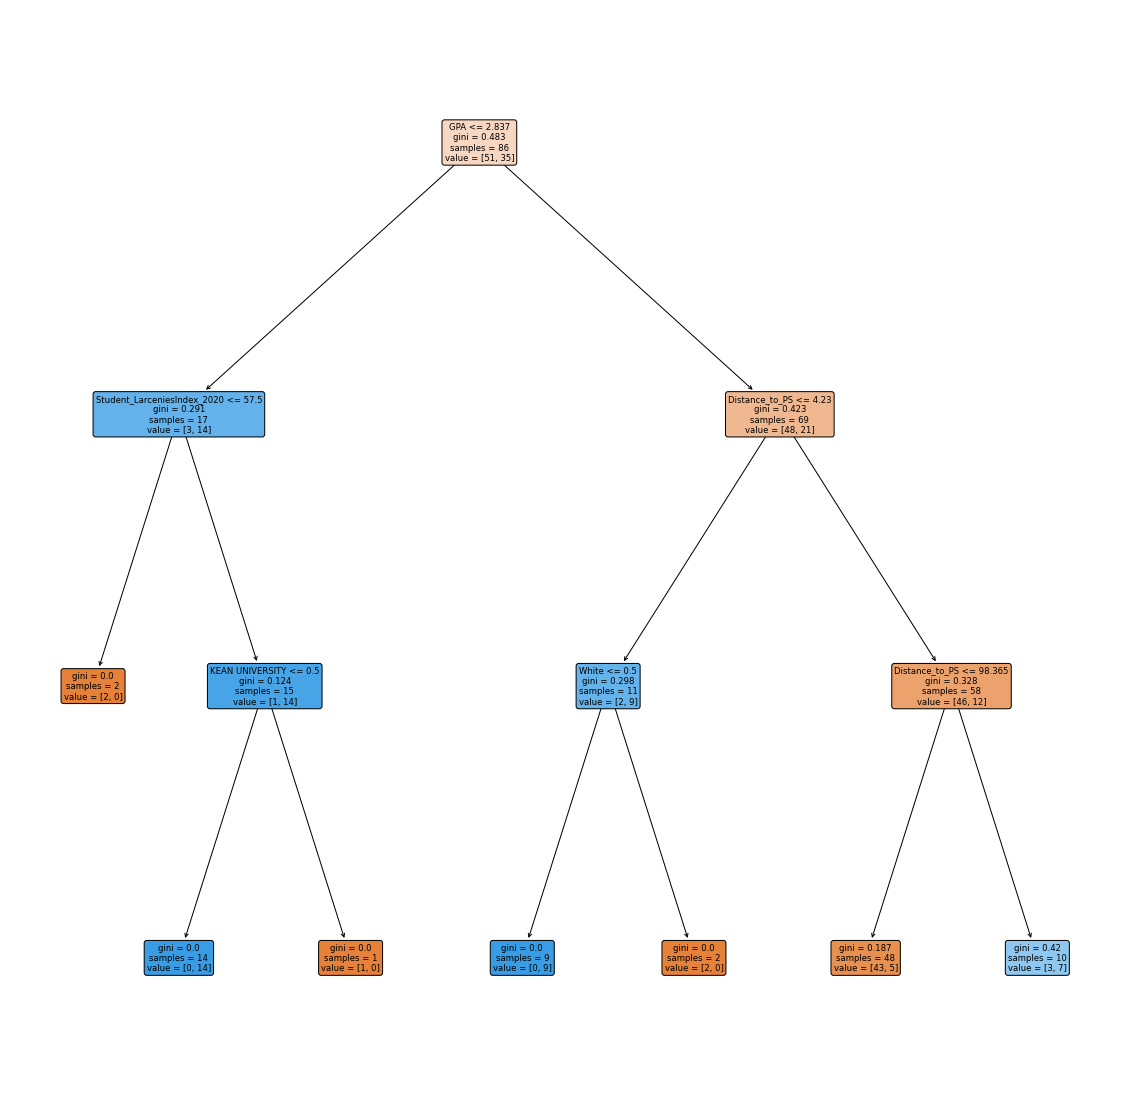

In [ ]:
feature_names = list(train_X.columns)
py.figure(figsize=(20,20))
tree.plot_tree(tree_clf1, filled=True, feature_names=feature_names, rounded=True)

In [ ]:
y_pred_tree1 = tree_clf1.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_tree1))
print("Accuracy: ", accuracy_score(validation_y, y_pred_tree1))
print("Precision: ", precision_score(validation_y, y_pred_tree1))
print("Recall: ", recall_score(validation_y, y_pred_tree1))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_tree1))

Area Under the Curve:  0.4345238095238094
Accuracy:  0.4230769230769231
Precision:  0.4444444444444444
Recall:  0.2857142857142857

 Confusion Matrix: 
  [[ 7  5]
 [10  4]]


#### Attempt #2

In [ ]:
tree_clf2 = DecisionTreeClassifier(max_depth = 4, random_state = 42)
tree_clf2.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [ ]:
y_pred_tree2 = tree_clf2.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_tree2))
print("Accuracy: ", accuracy_score(validation_y, y_pred_tree2))
print("Precision: ", precision_score(validation_y, y_pred_tree2))
print("Recall: ", recall_score(validation_y, y_pred_tree2))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_tree2))

Area Under the Curve:  0.47023809523809523
Accuracy:  0.46153846153846156
Precision:  0.5
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[7 5]
 [9 5]]


#### <font color=limegreen>Attempt #3</font>

In [ ]:
tree_clf3 = DecisionTreeClassifier(max_depth = 2, random_state = 42)
tree_clf3.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=2, random_state=42)

[Text(0.5, 0.8333333333333334, 'GPA <= 2.837\ngini = 0.483\nsamples = 86\nvalue = [51, 35]'),
 Text(0.25, 0.5, 'Student_LarceniesIndex_2020 <= 57.5\ngini = 0.291\nsamples = 17\nvalue = [3, 14]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.124\nsamples = 15\nvalue = [1, 14]'),
 Text(0.75, 0.5, 'Distance_to_PS <= 4.23\ngini = 0.423\nsamples = 69\nvalue = [48, 21]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.298\nsamples = 11\nvalue = [2, 9]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.328\nsamples = 58\nvalue = [46, 12]')]

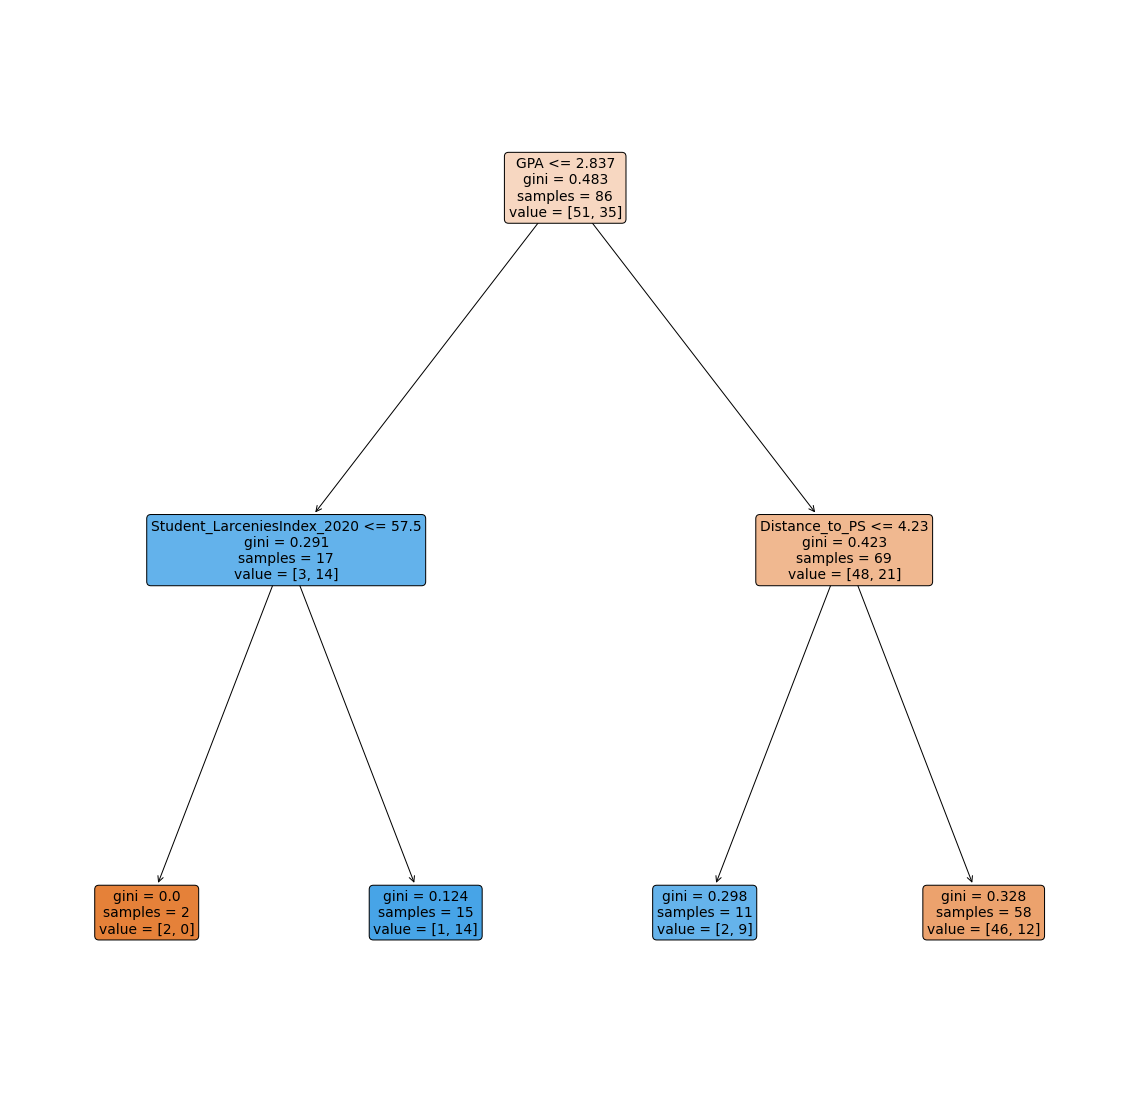

In [ ]:
feature_names =list(train_X.columns)
py.figure(figsize=(20,20))
tree.plot_tree(tree_clf3, filled=True, feature_names=feature_names, rounded=True)

In [ ]:
y_pred_tree3 = tree_clf3.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_tree3))
print("Accuracy: ", accuracy_score(validation_y, y_pred_tree3))
print("Precision: ", precision_score(validation_y, y_pred_tree3))
print("Recall: ", recall_score(validation_y, y_pred_tree3))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_tree3))

Area Under the Curve:  0.5892857142857143
Accuracy:  0.5769230769230769
Precision:  0.6666666666666666
Recall:  0.42857142857142855

 Confusion Matrix: 
  [[9 3]
 [8 6]]


#### Attempt #4

In [ ]:
tree_clf4 = DecisionTreeClassifier(min_samples_leaf = 3, random_state = 42)
tree_clf4.fit(train_X, train_y)

DecisionTreeClassifier(min_samples_leaf=3, random_state=42)

In [ ]:
y_pred_tree4 = tree_clf4.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_tree4))
print("Accuracy: ", accuracy_score(validation_y, y_pred_tree4))
print("Precision: ", precision_score(validation_y, y_pred_tree4))
print("Recall: ", recall_score(validation_y, y_pred_tree4))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_tree4))

Area Under the Curve:  0.5059523809523809
Accuracy:  0.5
Precision:  0.5454545454545454
Recall:  0.42857142857142855

 Confusion Matrix: 
  [[7 5]
 [8 6]]


#### Attempt #5

In [ ]:
tree_clf5 = DecisionTreeClassifier(min_samples_leaf = 4, random_state = 42)
tree_clf5.fit(train_X, train_y)

DecisionTreeClassifier(min_samples_leaf=4, random_state=42)

In [ ]:
y_pred_tree5 = tree_clf5.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_tree5))
print("Accuracy: ", accuracy_score(validation_y, y_pred_tree5))
print("Precision: ", precision_score(validation_y, y_pred_tree5))
print("Recall: ", recall_score(validation_y, y_pred_tree5))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_tree5))

Area Under the Curve:  0.511904761904762
Accuracy:  0.5
Precision:  0.5555555555555556
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[8 4]
 [9 5]]


#### Attempt #6

In [ ]:
tree_clf6 = DecisionTreeClassifier(criterion = "entropy", max_depth = 3, random_state = 42)
tree_clf6.fit(train_X, train_y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [ ]:
y_pred_tree6 = tree_clf6.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_tree6))
print("Accuracy: ", accuracy_score(validation_y, y_pred_tree6))
print("Precision: ", precision_score(validation_y, y_pred_tree6))
print("Recall: ", recall_score(validation_y, y_pred_tree6))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_tree6))

Area Under the Curve:  0.4761904761904762
Accuracy:  0.46153846153846156
Precision:  0.5
Recall:  0.2857142857142857

 Confusion Matrix: 
  [[ 8  4]
 [10  4]]


#### Attempt #7

In [ ]:
tree_clf7 = DecisionTreeClassifier(criterion = "entropy", min_samples_leaf = 3, random_state = 42)
tree_clf7.fit(train_X, train_y)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3, random_state=42)

In [ ]:
y_pred_tree7 = tree_clf7.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_tree7))
print("Accuracy: ", accuracy_score(validation_y, y_pred_tree7))
print("Precision: ", precision_score(validation_y, y_pred_tree7))
print("Recall: ", recall_score(validation_y, y_pred_tree7))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_tree7))

Area Under the Curve:  0.5059523809523809
Accuracy:  0.5
Precision:  0.5454545454545454
Recall:  0.42857142857142855

 Confusion Matrix: 
  [[7 5]
 [8 6]]


#### Best Decision Tree Classifier

In [ ]:
best_tree_clf = tree_clf3

In [ ]:
tree_featureImportance_dict = dict()

for name, score in zip(train_X.columns, best_tree_clf.feature_importances_):
    tree_featureImportance_dict[name] = score
    
tree_featureImportance = pd.Series(tree_featureImportance_dict)
tree_featureImportance

Gender                        0.000000
Hispanic                      0.000000
Asian                         0.000000
Black                         0.000000
White                         0.000000
                                ...   
Student_BurglariesCateg       0.000000
Student_LarceniesCateg        0.000000
Student_VehicleTheftsCateg    0.000000
Distance_to_HS                0.000000
Distance_to_PS                0.398563
Length: 165, dtype: float64

In [ ]:
tree_featureImportance[tree_featureImportance.values > 0].sort_values(ascending=False)

GPA                            0.424107
Distance_to_PS                 0.398563
Student_LarceniesIndex_2020    0.177330
dtype: float64

### Random Forests

<font color=red>Must use unscaled in order to make meaningful interpretations of the trees</font>

#### Attempt #1

In [ ]:
rf_clf1 = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_clf1.fit(train_X, train_y)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rf1 = rf_clf1.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_rf1))
print("Accuracy: ", accuracy_score(validation_y, y_pred_rf1))
print("Precision: ", precision_score(validation_y, y_pred_rf1))
print("Recall: ", recall_score(validation_y, y_pred_rf1))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_rf1))

Area Under the Curve:  0.601190476190476
Accuracy:  0.5769230769230769
Precision:  0.8
Recall:  0.2857142857142857

 Confusion Matrix: 
  [[11  1]
 [10  4]]


#### Attempt #2

In [ ]:
rf_clf2 = RandomForestClassifier(n_estimators = 200, random_state = 42)
rf_clf2.fit(train_X, train_y)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
y_pred_rf2 = rf_clf2.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_rf2))
print("Accuracy: ", accuracy_score(validation_y, y_pred_rf2))
print("Precision: ", precision_score(validation_y, y_pred_rf2))
print("Recall: ", recall_score(validation_y, y_pred_rf2))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_rf2))

Area Under the Curve:  0.6369047619047619
Accuracy:  0.6153846153846154
Precision:  0.8333333333333334
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[11  1]
 [ 9  5]]


#### Attempt #3

In [ ]:
rf_clf3 = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf_clf3.fit(train_X, train_y)

RandomForestClassifier(n_estimators=500, random_state=42)

In [ ]:
y_pred_rf3 = rf_clf3.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_rf3))
print("Accuracy: ", accuracy_score(validation_y, y_pred_rf3))
print("Precision: ", precision_score(validation_y, y_pred_rf3))
print("Recall: ", recall_score(validation_y, y_pred_rf3))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_rf3))

Area Under the Curve:  0.6369047619047619
Accuracy:  0.6153846153846154
Precision:  0.8333333333333334
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[11  1]
 [ 9  5]]


#### Attempt #4

In [ ]:
rf_clf4 = RandomForestClassifier(n_estimators = 300, random_state = 42)
rf_clf4.fit(train_X, train_y)

RandomForestClassifier(n_estimators=300, random_state=42)

In [ ]:
y_pred_rf4 = rf_clf4.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_rf4))
print("Accuracy: ", accuracy_score(validation_y, y_pred_rf4))
print("Precision: ", precision_score(validation_y, y_pred_rf4))
print("Recall: ", recall_score(validation_y, y_pred_rf4))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_rf4))

Area Under the Curve:  0.6369047619047619
Accuracy:  0.6153846153846154
Precision:  0.8333333333333334
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[11  1]
 [ 9  5]]


#### Attempt #5

In [ ]:
rf_clf5 = RandomForestClassifier(n_estimators = 200, max_depth = 5, random_state = 42)
rf_clf5.fit(train_X, train_y)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)

In [ ]:
y_pred_rf5 = rf_clf5.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_rf5))
print("Accuracy: ", accuracy_score(validation_y, y_pred_rf5))
print("Precision: ", precision_score(validation_y, y_pred_rf5))
print("Recall: ", recall_score(validation_y, y_pred_rf5))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_rf5))

Area Under the Curve:  0.6369047619047619
Accuracy:  0.6153846153846154
Precision:  0.8333333333333334
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[11  1]
 [ 9  5]]


#### Attempt #6

In [ ]:
rf_clf6 = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 5, random_state = 42)
rf_clf6.fit(train_X, train_y)

RandomForestClassifier(min_samples_leaf=5, n_estimators=200, random_state=42)

In [ ]:
y_pred_rf6 = rf_clf6.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_rf6))
print("Accuracy: ", accuracy_score(validation_y, y_pred_rf6))
print("Precision: ", precision_score(validation_y, y_pred_rf6))
print("Recall: ", recall_score(validation_y, y_pred_rf6))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_rf6))

Area Under the Curve:  0.5952380952380953
Accuracy:  0.5769230769230769
Precision:  0.7142857142857143
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[10  2]
 [ 9  5]]


#### <font color=limegreen>Attempt #7</font>

In [ ]:
rf_clf7 = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 3, random_state = 42)
rf_clf7.fit(train_X, train_y)

RandomForestClassifier(min_samples_leaf=3, n_estimators=200, random_state=42)

In [ ]:
y_pred_rf7 = rf_clf7.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_rf7))
print("Accuracy: ", accuracy_score(validation_y, y_pred_rf7))
print("Precision: ", precision_score(validation_y, y_pred_rf7))
print("Recall: ", recall_score(validation_y, y_pred_rf7))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_rf7))

Area Under the Curve:  0.6309523809523809
Accuracy:  0.6153846153846154
Precision:  0.75
Recall:  0.42857142857142855

 Confusion Matrix: 
  [[10  2]
 [ 8  6]]


#### Attempt #8

In [ ]:
rf_clf8 = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 5, oob_score = True, random_state = 42)
rf_clf8.fit(train_X, train_y)

RandomForestClassifier(min_samples_leaf=5, n_estimators=200, oob_score=True,
                       random_state=42)

In [ ]:
y_pred_rf8 = rf_clf8.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_rf8))
print("Accuracy: ", accuracy_score(validation_y, y_pred_rf8))
print("Precision: ", precision_score(validation_y, y_pred_rf8))
print("Recall: ", recall_score(validation_y, y_pred_rf8))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_rf8))

Area Under the Curve:  0.5952380952380953
Accuracy:  0.5769230769230769
Precision:  0.7142857142857143
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[10  2]
 [ 9  5]]


#### Best Random Forest Classifier

In [ ]:
best_rf_clf = rf_clf7

In [ ]:
rf_featureImportance_dict = dict()

for name, score in zip(train_X.columns, best_rf_clf.feature_importances_):
    rf_featureImportance_dict[name] = score
    
rf_featureImportance = pd.Series(rf_featureImportance_dict)
rf_featureImportance

Gender                        0.002717
Hispanic                      0.010774
Asian                         0.008765
Black                         0.032557
White                         0.004482
                                ...   
Student_BurglariesCateg       0.000208
Student_LarceniesCateg        0.000000
Student_VehicleTheftsCateg    0.000000
Distance_to_HS                0.041028
Distance_to_PS                0.106952
Length: 165, dtype: float64

In [ ]:
rf_featureImportance.sort_values(ascending=False).iloc[:20]

Distance_to_PS                      0.106952
GPA                                 0.075689
Distance_to_HS                      0.041028
HSGrad_Age                          0.034305
Black                               0.032557
Student_RapesIndex_2020             0.029340
Absences                            0.027459
HS_VehicleTheftsIndex_2020          0.027343
Honors                              0.027226
Student_AssaultsIndex_2020          0.021447
Student_PersonalCrimesIndex_2020    0.020329
Student_PropertyCrimesIndex_2020    0.020211
Student_CrimesIndex_2020            0.019867
Student_RobberiesIndex_2020         0.019559
Student_AreaPopulation_2020         0.017242
Student_BurglariesIndex_2020        0.015924
SAT_Writing                         0.015846
SAT_Math                            0.015400
Student_VehicleTheftsIndex_2020     0.014913
RAMAPO COLLEGE OF NEW JERSEY        0.014816
dtype: float64

### Boosting

<font color=red>Must use unscaled in order to make meaningful interpretations of the trees</font>

#### Attempt #1

In [ ]:
boost_clf1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 1, random_state = 42)
boost_clf1.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost1 = boost_clf1.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost1))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost1))
print("Precision: ", precision_score(validation_y, y_pred_boost1))
print("Recall: ", recall_score(validation_y, y_pred_boost1))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost1))

Area Under the Curve:  0.5059523809523809
Accuracy:  0.5
Precision:  0.5454545454545454
Recall:  0.42857142857142855

 Confusion Matrix: 
  [[7 5]
 [8 6]]


#### Attempt #2

In [ ]:
boost_clf2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 0.5, random_state = 42)
boost_clf2.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost2 = boost_clf2.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost2))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost2))
print("Precision: ", precision_score(validation_y, y_pred_boost2))
print("Recall: ", recall_score(validation_y, y_pred_boost2))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost2))

Area Under the Curve:  0.5476190476190477
Accuracy:  0.5384615384615384
Precision:  0.6
Recall:  0.42857142857142855

 Confusion Matrix: 
  [[8 4]
 [8 6]]


#### Attempt #3

In [ ]:
boost_clf3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 1.5, random_state = 42)
boost_clf3.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1.5, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost3 = boost_clf3.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost3))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost3))
print("Precision: ", precision_score(validation_y, y_pred_boost3))
print("Recall: ", recall_score(validation_y, y_pred_boost3))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost3))

Area Under the Curve:  0.47023809523809523
Accuracy:  0.46153846153846156
Precision:  0.5
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[7 5]
 [9 5]]


#### <font color=limegreen>Attempt #4</font>

In [ ]:
boost_clf4 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 2, random_state = 42)
boost_clf4.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=2, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost4 = boost_clf4.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost4))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost4))
print("Precision: ", precision_score(validation_y, y_pred_boost4))
print("Recall: ", recall_score(validation_y, y_pred_boost4))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost4))

Area Under the Curve:  0.5773809523809523
Accuracy:  0.5769230769230769
Precision:  0.6153846153846154
Recall:  0.5714285714285714

 Confusion Matrix: 
  [[7 5]
 [6 8]]


#### Attempt #5

In [ ]:
boost_clf5 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
                                algorithm = "SAMME", learning_rate = 1, random_state = 42)
boost_clf5.fit(train_X, train_y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost5 = boost_clf5.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost5))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost5))
print("Precision: ", precision_score(validation_y, y_pred_boost5))
print("Recall: ", recall_score(validation_y, y_pred_boost5))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost5))

Area Under the Curve:  0.3928571428571428
Accuracy:  0.38461538461538464
Precision:  0.4
Recall:  0.2857142857142857

 Confusion Matrix: 
  [[ 6  6]
 [10  4]]


#### Attempt #6

In [ ]:
boost_clf6 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 1, random_state = 42)
boost_clf6.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=1, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost6 = boost_clf6.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost6))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost6))
print("Precision: ", precision_score(validation_y, y_pred_boost6))
print("Recall: ", recall_score(validation_y, y_pred_boost6))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost6))

Area Under the Curve:  0.5178571428571428
Accuracy:  0.5
Precision:  0.5714285714285714
Recall:  0.2857142857142857

 Confusion Matrix: 
  [[ 9  3]
 [10  4]]


#### Attempt #7

In [ ]:
boost_clf7 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 5), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 1, random_state = 42)
boost_clf7.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=1, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost7 = boost_clf7.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost7))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost7))
print("Precision: ", precision_score(validation_y, y_pred_boost7))
print("Recall: ", recall_score(validation_y, y_pred_boost7))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost7))

Area Under the Curve:  0.4761904761904762
Accuracy:  0.46153846153846156
Precision:  0.5
Recall:  0.2857142857142857

 Confusion Matrix: 
  [[ 8  4]
 [10  4]]


#### Attempt #8

In [ ]:
boost_clf8 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 5), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 0.5, random_state = 42)
boost_clf8.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost8 = boost_clf8.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost8))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost8))
print("Precision: ", precision_score(validation_y, y_pred_boost8))
print("Recall: ", recall_score(validation_y, y_pred_boost8))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost8))

Area Under the Curve:  0.47023809523809523
Accuracy:  0.46153846153846156
Precision:  0.5
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[7 5]
 [9 5]]


#### Attempt #9

In [ ]:
boost_clf9 = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf = 3), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 1, random_state = 42)
boost_clf9.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=3),
                   learning_rate=1, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost9 = boost_clf9.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost9))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost9))
print("Precision: ", precision_score(validation_y, y_pred_boost9))
print("Recall: ", recall_score(validation_y, y_pred_boost9))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost9))

Area Under the Curve:  0.5952380952380953
Accuracy:  0.5769230769230769
Precision:  0.7142857142857143
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[10  2]
 [ 9  5]]


#### Attempt #10

In [ ]:
boost_clf10 = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf = 3), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 0.5, random_state = 42)
boost_clf10.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=3),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost10 = boost_clf10.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost10))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost10))
print("Precision: ", precision_score(validation_y, y_pred_boost10))
print("Recall: ", recall_score(validation_y, y_pred_boost10))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost10))

Area Under the Curve:  0.5535714285714285
Accuracy:  0.5384615384615384
Precision:  0.625
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[9 3]
 [9 5]]


#### Attempt #11

In [ ]:
boost_clf11 = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf = 3), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 1.5, random_state = 42)
boost_clf11.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=3),
                   learning_rate=1.5, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost11 = boost_clf11.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost11))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost11))
print("Precision: ", precision_score(validation_y, y_pred_boost11))
print("Recall: ", recall_score(validation_y, y_pred_boost11))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost11))

Area Under the Curve:  0.5952380952380953
Accuracy:  0.5769230769230769
Precision:  0.7142857142857143
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[10  2]
 [ 9  5]]


#### Attempt #12

In [ ]:
boost_clf12 = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf = 5), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 1, random_state = 42)
boost_clf12.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=5),
                   learning_rate=1, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost12 = boost_clf12.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost12))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost12))
print("Precision: ", precision_score(validation_y, y_pred_boost12))
print("Recall: ", recall_score(validation_y, y_pred_boost12))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost12))

Area Under the Curve:  0.5892857142857143
Accuracy:  0.5769230769230769
Precision:  0.6666666666666666
Recall:  0.42857142857142855

 Confusion Matrix: 
  [[9 3]
 [8 6]]


#### Attempt #13

In [ ]:
boost_clf13 = AdaBoostClassifier(DecisionTreeClassifier(min_samples_leaf = 2), n_estimators = 200,
                                algorithm = "SAMME.R", learning_rate = 1, random_state = 42)
boost_clf13.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=2),
                   learning_rate=1, n_estimators=200, random_state=42)

In [ ]:
y_pred_boost13 = boost_clf13.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost13))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost13))
print("Precision: ", precision_score(validation_y, y_pred_boost13))
print("Recall: ", recall_score(validation_y, y_pred_boost13))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost13))

Area Under the Curve:  0.5178571428571428
Accuracy:  0.5
Precision:  0.5714285714285714
Recall:  0.2857142857142857

 Confusion Matrix: 
  [[ 9  3]
 [10  4]]


#### Attempt #14

In [ ]:
boost_clf14 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 100,
                                algorithm = "SAMME.R", learning_rate = 0.5, random_state = 42)
boost_clf14.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=100, random_state=42)

In [ ]:
y_pred_boost14 = boost_clf14.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost14))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost14))
print("Precision: ", precision_score(validation_y, y_pred_boost14))
print("Recall: ", recall_score(validation_y, y_pred_boost14))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost14))

Area Under the Curve:  0.511904761904762
Accuracy:  0.5
Precision:  0.5555555555555556
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[8 4]
 [9 5]]


#### Attempt #15

In [ ]:
boost_clf15 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 100,
                                algorithm = "SAMME.R", learning_rate = 1.5, random_state = 42)
boost_clf15.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1.5, n_estimators=100, random_state=42)

In [ ]:
y_pred_boost15 = boost_clf15.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost15))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost15))
print("Precision: ", precision_score(validation_y, y_pred_boost15))
print("Recall: ", recall_score(validation_y, y_pred_boost15))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost15))

Area Under the Curve:  0.5535714285714285
Accuracy:  0.5384615384615384
Precision:  0.625
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[9 3]
 [9 5]]


#### Attempt #16

In [ ]:
boost_clf16 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 300,
                                algorithm = "SAMME.R", learning_rate = 1.5, random_state = 42)
boost_clf16.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1.5, n_estimators=300, random_state=42)

In [ ]:
y_pred_boost16 = boost_clf16.predict(validation_X)
print("Area Under the Curve: ", roc_auc_score(validation_y, y_pred_boost16))
print("Accuracy: ", accuracy_score(validation_y, y_pred_boost16))
print("Precision: ", precision_score(validation_y, y_pred_boost16))
print("Recall: ", recall_score(validation_y, y_pred_boost16))
print('\n',"Confusion Matrix: \n ", confusion_matrix(validation_y, y_pred_boost16))

Area Under the Curve:  0.511904761904762
Accuracy:  0.5
Precision:  0.5555555555555556
Recall:  0.35714285714285715

 Confusion Matrix: 
  [[8 4]
 [9 5]]


#### Best Boosting Classifier

In [ ]:
best_boost_clf = boost_clf4

In [ ]:
boost_featureImportance_dict = dict()

for name, score in zip(train_X.columns, best_boost_clf.feature_importances_):
    boost_featureImportance_dict[name] = score
    
boost_featureImportance = pd.Series(boost_featureImportance_dict)
boost_featureImportance

Gender                        0.000
Hispanic                      0.000
Asian                         0.010
Black                         0.000
White                         0.000
                              ...  
Student_BurglariesCateg       0.000
Student_LarceniesCateg        0.000
Student_VehicleTheftsCateg    0.000
Distance_to_HS                0.005
Distance_to_PS                0.130
Length: 165, dtype: float64

In [ ]:
boost_featureImportance.sort_values(ascending=False).iloc[:20]

GPA                                    0.840
Distance_to_PS                         0.130
Asian                                  0.010
Multinational                          0.005
Distance_to_HS                         0.005
Absences                               0.005
Student_RapesIndex_2020                0.005
HS_PersonalCrimesIndex_2020            0.000
HS_CrimesIndex_2020                    0.000
RUTGERS, THE STATE UNIVERSITY OF NJ    0.000
SETON HALL UNIVERSITY                  0.000
STANFORD UNIVERSITY                    0.000
STEVENS INSTITUTE OF TECHNOLOGY        0.000
STOCKTON UNIVERSITY                    0.000
SYRACUSE UNIVERSITY                    0.000
TEMPLE UNIVERSITY                      0.000
UNION COUNTY COLLEGE                   0.000
UNIVERSITY OF NEW HAVEN                0.000
UNIVERSITY OF WISCONSIN-MADISON        0.000
HS_RapesIndex_2020                     0.000
dtype: float64

### Ensemble Learning

*Want methods which are diverse*

#### <font color=limegreen>Attempt #1</font>

In [ ]:
voting_clf1 = VotingClassifier(estimators=[('sgd', best_SGD_clf),
                                           ('svm', best_svm_clf), 
                                           ('boost', best_boost_clf)], voting='hard')
voting_clf1.fit(train_X, train_y)

VotingClassifier(estimators=[('sgd', SGDClassifier(random_state=42)),
                             ('svm', SVC(random_state=42)),
                             ('boost',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                 learning_rate=2,
                                                 n_estimators=200,
                                                 random_state=42))])

In [ ]:
for clf in (best_SGD_clf, best_svm_clf, best_boost_clf, voting_clf1):
    if clf == best_SGD_clf:
        y_pred = cross_val_predict(clf, validation_X, validation_y, cv = 5)
    else:
        y_pred = clf.predict(validation_X)
    
    print("Area Under the Curve: ", clf.__class__.__name__, roc_auc_score(validation_y, y_pred))
    print("Accuracy: ", clf.__class__.__name__, accuracy_score(validation_y, y_pred))
    print("Precision: ", clf.__class__.__name__, precision_score(validation_y, y_pred))
    print("Recall: ", clf.__class__.__name__, recall_score(validation_y, y_pred))
    print('\n',"Confusion Matrix: \n ",confusion_matrix(validation_y, y_pred))
    print()
    print()

Area Under the Curve:  SGDClassifier 0.5178571428571428
Accuracy:  SGDClassifier 0.5384615384615384
Precision:  SGDClassifier 0.55
Recall:  SGDClassifier 0.7857142857142857

 Confusion Matrix: 
  [[ 3  9]
 [ 3 11]]


Area Under the Curve:  SVC 0.5535714285714285
Accuracy:  SVC 0.5384615384615384
Precision:  SVC 0.625
Recall:  SVC 0.35714285714285715

 Confusion Matrix: 
  [[9 3]
 [9 5]]


Area Under the Curve:  AdaBoostClassifier 0.5773809523809523
Accuracy:  AdaBoostClassifier 0.5769230769230769
Precision:  AdaBoostClassifier 0.6153846153846154
Recall:  AdaBoostClassifier 0.5714285714285714

 Confusion Matrix: 
  [[7 5]
 [6 8]]


Area Under the Curve:  VotingClassifier 0.6428571428571428
Accuracy:  VotingClassifier 0.6538461538461539
Precision:  VotingClassifier 0.6470588235294118
Recall:  VotingClassifier 0.7857142857142857

 Confusion Matrix: 
  [[ 6  6]
 [ 3 11]]




#### Attempt #2

In [ ]:
voting_clf2 = VotingClassifier(estimators=[('svm', best_svm_clf), 
                                           ('boost', best_boost_clf)], voting='hard')
voting_clf2.fit(train_X, train_y)

VotingClassifier(estimators=[('svm', SVC(random_state=42)),
                             ('boost',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                 learning_rate=2,
                                                 n_estimators=200,
                                                 random_state=42))])

In [ ]:
for clf in (best_svm_clf, best_boost_clf, voting_clf2):
    y_pred = clf.predict(validation_X)
    
    print("Area Under the Curve: ", clf.__class__.__name__, roc_auc_score(validation_y, y_pred))
    print("Accuracy: ", clf.__class__.__name__, accuracy_score(validation_y, y_pred))
    print("Precision: ", clf.__class__.__name__, precision_score(validation_y, y_pred))
    print("Recall: ", clf.__class__.__name__, recall_score(validation_y, y_pred))
    print('\n',"Confusion Matrix: \n ",confusion_matrix(validation_y, y_pred))
    print()
    print()

Area Under the Curve:  SVC 0.5535714285714285
Accuracy:  SVC 0.5384615384615384
Precision:  SVC 0.625
Recall:  SVC 0.35714285714285715

 Confusion Matrix: 
  [[9 3]
 [9 5]]


Area Under the Curve:  AdaBoostClassifier 0.5773809523809523
Accuracy:  AdaBoostClassifier 0.5769230769230769
Precision:  AdaBoostClassifier 0.6153846153846154
Recall:  AdaBoostClassifier 0.5714285714285714

 Confusion Matrix: 
  [[7 5]
 [6 8]]


Area Under the Curve:  VotingClassifier 0.4880952380952381
Accuracy:  VotingClassifier 0.46153846153846156
Precision:  VotingClassifier 0.5
Recall:  VotingClassifier 0.14285714285714285

 Confusion Matrix: 
  [[10  2]
 [12  2]]




#### Attempt #3

In [ ]:
voting_clf3 = VotingClassifier(estimators=[('sgd', best_SGD_clf), 
                                           ('boost', best_boost_clf)], voting='hard')
voting_clf3.fit(train_X, train_y)

VotingClassifier(estimators=[('sgd', SGDClassifier(random_state=42)),
                             ('boost',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                 learning_rate=2,
                                                 n_estimators=200,
                                                 random_state=42))])

In [ ]:
for clf in (best_SGD_clf, best_boost_clf, voting_clf3):
    if clf == best_SGD_clf:
        y_pred = cross_val_predict(clf, validation_X, validation_y, cv = 5)
    else:
        y_pred = clf.predict(validation_X)
    
    print("Area Under the Curve: ", clf.__class__.__name__, roc_auc_score(validation_y, y_pred))
    print("Accuracy: ", clf.__class__.__name__, accuracy_score(validation_y, y_pred))
    print("Precision: ", clf.__class__.__name__, precision_score(validation_y, y_pred))
    print("Recall: ", clf.__class__.__name__, recall_score(validation_y, y_pred))
    print('\n',"Confusion Matrix: \n ",confusion_matrix(validation_y, y_pred))
    print()
    print()

Area Under the Curve:  SGDClassifier 0.5178571428571428
Accuracy:  SGDClassifier 0.5384615384615384
Precision:  SGDClassifier 0.55
Recall:  SGDClassifier 0.7857142857142857

 Confusion Matrix: 
  [[ 3  9]
 [ 3 11]]


Area Under the Curve:  AdaBoostClassifier 0.5773809523809523
Accuracy:  AdaBoostClassifier 0.5769230769230769
Precision:  AdaBoostClassifier 0.6153846153846154
Recall:  AdaBoostClassifier 0.5714285714285714

 Confusion Matrix: 
  [[7 5]
 [6 8]]


Area Under the Curve:  VotingClassifier 0.5773809523809523
Accuracy:  VotingClassifier 0.5769230769230769
Precision:  VotingClassifier 0.6153846153846154
Recall:  VotingClassifier 0.5714285714285714

 Confusion Matrix: 
  [[7 5]
 [6 8]]




#### Attempt #4

In [ ]:
voting_clf4 = VotingClassifier(estimators=[('sgd', best_SGD_clf),
                                           ('svm', best_svm_clf), 
                                           ('rf', best_rf_clf)], voting='hard')
voting_clf4.fit(train_X, train_y)

VotingClassifier(estimators=[('sgd', SGDClassifier(random_state=42)),
                             ('svm', SVC(random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_leaf=3,
                                                     n_estimators=200,
                                                     random_state=42))])

In [ ]:
for clf in (best_SGD_clf, best_svm_clf, best_rf_clf, voting_clf4):
    if clf == best_SGD_clf:
        y_pred = cross_val_predict(clf, validation_X, validation_y, cv = 5)
    else:
        y_pred = clf.predict(validation_X)
    
    print("Area Under the Curve: ", clf.__class__.__name__, roc_auc_score(validation_y, y_pred))
    print("Accuracy: ", clf.__class__.__name__, accuracy_score(validation_y, y_pred))
    print("Precision: ", clf.__class__.__name__, precision_score(validation_y, y_pred))
    print("Recall: ", clf.__class__.__name__, recall_score(validation_y, y_pred))
    print('\n',"Confusion Matrix: \n ",confusion_matrix(validation_y, y_pred))
    print()
    print()

Area Under the Curve:  SGDClassifier 0.5178571428571428
Accuracy:  SGDClassifier 0.5384615384615384
Precision:  SGDClassifier 0.55
Recall:  SGDClassifier 0.7857142857142857

 Confusion Matrix: 
  [[ 3  9]
 [ 3 11]]


Area Under the Curve:  SVC 0.5535714285714285
Accuracy:  SVC 0.5384615384615384
Precision:  SVC 0.625
Recall:  SVC 0.35714285714285715

 Confusion Matrix: 
  [[9 3]
 [9 5]]


Area Under the Curve:  RandomForestClassifier 0.6309523809523809
Accuracy:  RandomForestClassifier 0.6153846153846154
Precision:  RandomForestClassifier 0.75
Recall:  RandomForestClassifier 0.42857142857142855

 Confusion Matrix: 
  [[10  2]
 [ 8  6]]


Area Under the Curve:  VotingClassifier 0.6190476190476191
Accuracy:  VotingClassifier 0.6153846153846154
Precision:  VotingClassifier 0.6666666666666666
Recall:  VotingClassifier 0.5714285714285714

 Confusion Matrix: 
  [[8 4]
 [6 8]]




In [ ]:
voting_predictorCoeff = pd.Series(voting_clf1.named_estimators_["sgd"].coef_[0], index=list(train_X.columns))
voting_predictorCoeff

Gender                             0.000000
Hispanic                        -324.210526
Asian                           -349.473684
Black                            374.736842
White                           -172.631579
                                  ...      
Student_BurglariesCateg          -96.842105
Student_LarceniesCateg          -240.000000
Student_VehicleTheftsCateg         0.000000
Distance_to_HS                  2827.964071
Distance_to_PS                286115.220656
Length: 165, dtype: float64

In [ ]:
# Top 10 Postively Correlated
voting_predictorCoeff.sort_values(ascending=False).iloc[:10]

HS_Area                       3.077337e+07
Student_Area                  2.397163e+07
HS_AreaPopulation_2020        3.382695e+06
Distance_to_PS                2.861152e+05
NumFreeLunch                  1.061137e+05
NumReducedLunch               4.077474e+04
HS_MurdersIndex_2020          1.457263e+04
HS_VehicleTheftsIndex_2020    6.745263e+03
Distance_to_HS                2.827964e+03
%_White                       2.370105e+03
dtype: float64

In [ ]:
# Top 10 Negatively Correlated
voting_predictorCoeff.sort_values(ascending=True).iloc[:10]

Student_AreaPopulation_2020        -3.556181e+06
HSGrad_Age                         -1.755166e+06
SAT_Math                           -1.499832e+05
SAT_Reading                        -1.379789e+05
SAT_Writing                        -1.348295e+05
Student_RobberiesIndex_2020        -6.683368e+04
HS_BurglariesIndex_2020            -4.057263e+04
HS_RobberiesIndex_2020             -3.685895e+04
Student_BurglariesIndex_2020       -3.196632e+04
Student_PersonalCrimesIndex_2020   -2.848421e+04
dtype: float64

# Final Model

In [ ]:
# Create a Dataset That Is the Union of the Training and Validation Sets
both_X = train_X.append(validation_X)
both_y = train_y.append(validation_y)

# Verify the Final Datasets Have the Correct Dimensions
print("PREDICTORS:")
print("\tTraining: ", len(train_X))
print("\tValidation: ", len(validation_X))
print("\tFinal: ", len(both_X), "\n")

print("TARGET:")
print("\tTraining: ", len(train_y))
print("\tValidation: ", len(validation_y))
print("\tFinal: ", len(both_y))

PREDICTORS:
	Training:  86
	Validation:  26
	Final:  112 

TARGET:
	Training:  86
	Validation:  26
	Final:  112


In [ ]:
# The Best Performing Classifier Is the Boosting Classifier
final_clf = voting_clf1
final_clf.fit(both_X, both_y)

y_pred_final = final_clf.predict(test_X)
print("Area Under the Curve: ", roc_auc_score(test_y, y_pred_final))
print("Accuracy: ", accuracy_score(test_y, y_pred_final))
print("Precision: ", precision_score(test_y, y_pred_final))
print("Recall: ", recall_score(test_y, y_pred_final))
print('\n',"Confusion Matrix: \n ", confusion_matrix(test_y, y_pred_final))

Area Under the Curve:  0.75
Accuracy:  0.75
Precision:  0.6666666666666666
Recall:  1.0

 Confusion Matrix: 
  [[3 3]
 [0 6]]


In [ ]:
final_predictorCoeff = pd.Series(final_clf.named_estimators_["sgd"].coef_[0], index=list(both_X.columns))
final_predictorCoeff

Gender                          -160.453044
Hispanic                        -245.398773
Asian                           -193.487494
Black                            287.871638
White                           -103.822558
                                  ...      
Student_BurglariesCateg          -33.034450
Student_LarceniesCateg          -122.699387
Student_VehicleTheftsCateg        28.315243
Distance_to_HS                  3786.769952
Distance_to_PS                249719.190330
Length: 165, dtype: float64

In [ ]:
# Top 10 Postively Correlated
final_predictorCoeff.sort_values(ascending=False).iloc[:10]

Student_Area                  4.259502e+07
HS_Area                       3.257017e+07
HS_AreaPopulation_2020        4.706107e+06
Distance_to_PS                2.497192e+05
NumFreeLunch                  1.748820e+05
NumReducedLunch               4.477584e+04
HS_VehicleTheftsIndex_2020    6.814535e+03
%_White                       4.602171e+03
Distance_to_HS                3.786770e+03
Absences                      2.444549e+03
dtype: float64

In [ ]:
# Top 10 Negatively Correlated
final_predictorCoeff.sort_values(ascending=True).iloc[:10]

Student_AreaPopulation_2020   -2.576602e+06
HSGrad_Age                    -9.405144e+05
SAT_Math                      -7.797546e+04
SAT_Reading                   -7.753657e+04
SAT_Writing                   -7.630014e+04
Student_RobberiesIndex_2020   -5.742331e+04
HS_RobberiesIndex_2020        -4.482303e+04
HS_BurglariesIndex_2020       -3.188296e+04
Student_MurdersIndex_2020     -2.521000e+04
HS_PersonalCrimesIndex_2020   -2.373289e+04
dtype: float64

In [ ]:
final_featureImportance_dict = dict()

for name, score in zip(train_X.columns, final_clf.named_estimators_["boost"].feature_importances_):
    final_featureImportance_dict[name] = score
    
final_featureImportance = pd.Series(final_featureImportance_dict)
final_featureImportance

Gender                        0.000
Hispanic                      0.000
Asian                         0.000
Black                         0.000
White                         0.000
                              ...  
Student_BurglariesCateg       0.000
Student_LarceniesCateg        0.000
Student_VehicleTheftsCateg    0.000
Distance_to_HS                0.000
Distance_to_PS                0.175
Length: 165, dtype: float64

In [ ]:
final_featureImportance.sort_values(ascending=False).iloc[:20]

SAT_Math                                    0.815
Distance_to_PS                              0.175
GPA                                         0.005
Student_CrimesIndex_2020                    0.005
UNION COUNTY COLLEGE                        0.000
RUTGERS, THE STATE UNIVERSITY OF NJ         0.000
SETON HALL UNIVERSITY                       0.000
STANFORD UNIVERSITY                         0.000
STEVENS INSTITUTE OF TECHNOLOGY             0.000
STOCKTON UNIVERSITY                         0.000
SYRACUSE UNIVERSITY                         0.000
TEMPLE UNIVERSITY                           0.000
Distance_to_HS                              0.000
RIDER UNIVERSITY                            0.000
UNIVERSITY OF NEW HAVEN                     0.000
UNIVERSITY OF WISCONSIN-MADISON             0.000
VAUGHN COLLEGE OF AERONAUTICS AND TECHNO    0.000
VIRGINIA STATE UNIVERSITY                   0.000
WILLIAM PATERSON UNIVERSITY                 0.000
HS_CrimesIndex_2020                         0.000


# Model Deployment

In [ ]:
y_pred_deployment = final_clf.predict(modelDeploymentData_X)
print("Area Under the Curve: ", roc_auc_score(modelDeploymentData_y, y_pred_deployment))
print("Accuracy: ", accuracy_score(modelDeploymentData_y, y_pred_deployment))
print("Precision: ", precision_score(modelDeploymentData_y, y_pred_deployment))
print("Recall: ", recall_score(modelDeploymentData_y, y_pred_deployment))
print('\n',"Confusion Matrix: \n ", confusion_matrix(modelDeploymentData_y, y_pred_deployment))

Area Under the Curve:  0.5128205128205129
Accuracy:  0.5454545454545454
Precision:  0.6
Recall:  0.6923076923076923

 Confusion Matrix: 
  [[3 6]
 [4 9]]
